# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [419]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [192]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [195]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [297]:
 # define your regions here
presel = {
    
        "mu": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt300": "( ( fj_pt>300) )",   
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",

            ### signal region
#             "LepIsolation": " ( (lep_pt<55) & (lep_isolation<0.15) ) | (lep_pt>=55)",
#             "LepMisolation": " ( (lep_pt>=55) & (lep_misolation<0.2) ) | (lep_pt<55)",
        },
        "ele": {
            "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
            "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
            "fj_pt300": "( ( fj_pt>300) )", 
            "dphi<1.57": "(abs_met_fj_dphi<1.57)",
            "tagger>0.5": "fj_ParT_score_finetuned>0.5",            
            
            ### signal region
#             "LepIsolation": " ( (lep_pt<120) & (lep_isolation<0.15) ) | (lep_pt>=120)",
        },
}

from make_stacked_hists import make_events_dict
channels = ["ele", "mu"]
samples = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data"
]

years = ["2017", "2016", "2016APV", "2018"]

In [ ]:
# events_dict = {}

In [34]:
# ### old corrections
# samples_dir = {
#     "2016":    "../eos/postprocessOct13_hidNeurons_2016",
#     "2016APV": "../eos/postprocessOct13_hidNeurons_2016APV",    
#     "2017":    "../eos/postprocessOct9_hidNeurons_2017",
#     "2018":    "../eos/postprocessOct5_hidNeurons_2018",
# }
# events_dict["old_corrections"] = {}
# for year in years:

#     out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
#     events_dict["old_corrections"] = {**events_dict["old_corrections"], **out}

In [298]:
### new corrections
samples_dir = {
    "2016":    "../eos/postprocessNov12_2016",
    "2016APV": "../eos/postprocessNov12_2016APV",
    "2017":    "../eos/postprocessNov12_2017",
    "2018":    "../eos/postprocessNov12_2018",
}
events_dict["new_correctionsNOMISO"] = {}
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="onlylepiso")
    events_dict["new_correctionsNOMISO"] = {**events_dict["new_correctionsNOMISO"], **out}

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3841 events
INFO:root:Applying lep_fj_dr08 selection on 3841 events
INFO:root:Applying fj_pt300 selection on 3841 events
INFO:root:Applying dphi<1.57 selection on 67 events
INFO:root:Applying tagger>0.5 selection on 4 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1 events
INFO:root:tot event weight 1.4999680616333395 

INFO:root:Finding DYJetsToLL_M-10to50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 362 events
INFO:root:Applying lep_fj_dr08 selection on 362 events
INFO:root:Applying fj_pt300 selection on 362 events
INFO:root:Applying dphi<1.57 selection on 71 events
INFO:root:Applying tagger>0.5 selection on 28 events
INFO:root:Will fill the DYJets dataframe with the remaining 8 events
INFO:

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 129307 events
INFO:root:Applying lep_fj_dr08 selection on 129307 events
INFO:root:Applying fj_pt300 selection on 129307 events
INFO:root:Applying dphi<1.57 selection on 118177 events
INFO:root:Applying tagger>0.5 selection on 72837 events
INFO:root:Will fill the DYJets dataframe with the remaining 1878 events
INFO:root:tot event weight 16.85360866387149 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 921 events
INFO:root:Applying lep_fj_dr08 selection on 921 events
INFO:root:Applying fj_pt300 selection on 921 events
INFO:root:Applying dphi<1.57 selection on 220 events
INFO:root:Applying tagger>0.5 selection on 146 events
INFO:root:Will fill the VBF dataframe with the remaining 118 events
INFO:root:tot event weight 4.910847480545672 

INFO:root:Findi

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 156188 events
INFO:root:Applying lep_fj_dr08 selection on 156188 events
INFO:root:Applying fj_pt300 selection on 156188 events
INFO:root:Applying dphi<1.57 selection on 135692 events
INFO:root:Applying tagger>0.5 selection on 105758 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 21451 events
INFO:root:tot event weight 974.4568697850626 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 866757 events
INFO:root:Applying lep_fj_dr08 selection on 866757 events
INFO:root:Applying fj_pt300 selection on 866757 events
INFO:root:Applying dphi<1.57 selection on 332276 events
INFO:root:Applying tagger>0.5 selection on 237637 events
INFO:root:Will fill the TTbar dataframe with the remaining 16285 events
INFO:root:tot event weight 1884.93593006057 

INFO:root:Fin

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 197217 events
INFO:root:Applying lep_fj_dr08 selection on 197217 events
INFO:root:Applying fj_pt300 selection on 197217 events
INFO:root:Applying dphi<1.57 selection on 183730 events
INFO:root:Applying tagger>0.5 selection on 145798 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 19706 events
INFO:root:tot event weight 193.4490142781816 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 111330 events
INFO:root:Applying lep_fj_dr08 selection on 111330 events
INFO:root:Applying fj_pt300 selection on 111330 events
INFO:root:Applying dphi<1.57 selection on 5873 events
INFO:root:Applying tagger>0.5 selection on 3497 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 467 events
INFO:root:tot event weight 181.06049459329256 

INFO:

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 107043 events
INFO:root:Applying lep_fj_dr08 selection on 107043 events
INFO:root:Applying fj_pt300 selection on 107043 events
INFO:root:Applying dphi<1.57 selection on 28972 events
INFO:root:Applying tagger>0.5 selection on 14581 events
INFO:root:Will fill the Data dataframe with the remaining 2082 events
INFO:root:tot event weight 2082.0 

INFO:root:Finding SingleElectron_Run2017D samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 47719 events
INFO:root:Applying lep_fj_dr08 selection on 47719 events
INFO:root:Applying fj_pt300 selection on 47719 events
INFO:root:Applying dphi<1.57 selection on 13103 events
INFO:root:Applying tagger>0.5 selection on 6642 events
INFO:root:Will fill the Data dataframe with the remaining 960 events
INFO:root:tot event weight 960.0 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:No parquet file for WJetsToLNu_HT-70To100
INFO

INFO:root:Will fill the QCD dataframe with the remaining 42 events
INFO:root:tot event weight 0.64599367574785 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2412 events
INFO:root:Applying lep_fj_dr08 selection on 2412 events
INFO:root:Applying fj_pt300 selection on 2412 events
INFO:root:Applying dphi<1.57 selection on 2312 events
INFO:root:Applying tagger>0.5 selection on 959 events
INFO:root:Will fill the QCD dataframe with the remaining 87 events
INFO:root:tot event weight 27.103549016899937 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1567 events
INFO:root:Applying lep_fj_dr08 selection on 1567 events
INFO:root:Applying fj_pt300 selection on 1567 events
INFO:root:Applying dphi<1.57 selection on 1381 events
INFO:root:Applying tagger>0.

Skipping sample DYJetsToLL_M-50_HT-2500toInf
Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:Applying lep_fj_dr003 selection on 1058 events
INFO:root:Applying lep_fj_dr08 selection on 1058 events
INFO:root:Applying fj_pt300 selection on 1058 events
INFO:root:Applying dphi<1.57 selection on 625 events
INFO:root:Applying tagger>0.5 selection on 235 events
INFO:root:Will fill the WZQQ dataframe with the remaining 42 events
INFO:root:tot event weight 5.453046560054816 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu


Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 128874 events
INFO:root:Applying lep_fj_dr08 selection on 128874 events
INFO:root:Applying fj_pt300 selection on 128874 events
INFO:root:Applying dphi<1.57 selection on 92579 events
INFO:root:Applying tagger>0.5 selection on 68071 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 16039 events
INFO:root:tot event weight 1571.76195344938 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1583 events
INFO:root:Applying lep_fj_dr08 selection on 1583 events
INFO:root:Applying fj_pt300 selection on 1583 events
INFO:root:Applying dphi<1.57 selection on 996 events
INFO:root:Applying tagger>0.5 selection on 417 events
INFO:root:Will fill the WZQQ dataframe with the remaining 95 events
INFO:root:tot event weight 25.20619312364679 

INFO:root:Finding WJetsToLN

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying tagger>0.5 selection on 42714 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2136 events
INFO:root:tot event weight 1.702001104812421 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11238 events
INFO:root:Applying lep_fj_dr08 selection on 11238 events
INFO:root:Applying fj_pt300 selection on 11238 events
INFO:root:Applying dphi<1.57 selection on 4739 events
INFO:root:Applying tagger>0.5 selection on 2970 events
INFO:root:Will fill the ttH dataframe with the remaining 1321 events
INFO:root:tot event weight 4.466375763517001 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1308 events
INFO:root:Applying lep_fj_dr08 selection on 1308 events
INFO:root:Applying fj_pt300 selection on 1308 events
INFO:r

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 275765 events
INFO:root:Applying lep_fj_dr08 selection on 275765 events
INFO:root:Applying fj_pt300 selection on 275765 events
INFO:root:Applying dphi<1.57 selection on 49893 events
INFO:root:Applying tagger>0.5 selection on 24312 events
INFO:root:Will fill the DYJets dataframe with the remaining 3791 events
INFO:root:tot event weight 209.58989204841802 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017F
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4515 events
INFO:root:Applying lep_fj_dr08 selection on 4515 events
INFO:root:Applying fj_pt300 selection on 4515 events
INFO:root:Applying dphi<1.57 selection on 75 events
INFO:root:Applying tagger>0.5 selection on 5 events
INFO:root:

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1530 events
INFO:root:Applying lep_fj_dr08 selection on 1530 events
INFO:root:Applying fj_pt300 selection on 1530 events
INFO:root:Applying dphi<1.57 selection on 441 events
INFO:root:Applying tagger>0.5 selection on 344 events
INFO:root:Will fill the VBF dataframe with the remaining 282 events
INFO:root:tot event weight 11.991320086872314 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 13882 events
INFO:root:Applying lep_fj_dr08 selection on 13882 events
INFO:root:Applying fj_pt300 selection on 13882 events
INFO:root:Applying dphi<1.57 selection on 4345 events
INFO:root:Applying tagger>0.5 selection on 3204 events
INFO:root:Will fill the VH dataframe with the remaining 2511 events
INFO:root:tot event weight 1.6984943647051978 

INFO:root:Finding WJetsToLNu_HT-800To12

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 221678 events
INFO:root:Applying lep_fj_dr08 selection on 221678 events
INFO:root:Applying fj_pt300 selection on 221678 events
INFO:root:Applying dphi<1.57 selection on 193734 events
INFO:root:Applying tagger>0.5 selection on 152453 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 38301 events
INFO:root:tot event weight 1834.8530233215113 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 984351 events
INFO:root:Applying lep_fj_dr08 selection on 984351 events
INFO:root:Applying fj_pt300 selection on 984351 events
INFO:root:Applying dphi<1.57 selection on 373199 events
INFO:root:Applying tagger>0.5 selection on 265179 events
INFO:root:Will fill the TTbar dataframe with the remaining 21952 events
INFO:root:tot event weight 2529.777054454374 

INFO:root:F

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 282798 events
INFO:root:Applying lep_fj_dr08 selection on 282798 events
INFO:root:Applying fj_pt300 selection on 282798 events
INFO:root:Applying dphi<1.57 selection on 265191 events
INFO:root:Applying tagger>0.5 selection on 213895 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 40896 events
INFO:root:tot event weight 424.26593685538217 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 142095 events
INFO:root:Applying lep_fj_dr08 selection on 142095 events
INFO:root:Applying fj_pt300 selection on 142095 events
INFO:root:Applying dphi<1.57 selection on 6498 events
INFO:root:Applying tagger>0.5 selection on 3866 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 575 events
INFO:root:tot event weight 235.28714387902147 

INFO

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 451324 events
INFO:root:Applying lep_fj_dr08 selection on 451324 events
INFO:root:Applying fj_pt300 selection on 451324 events
INFO:root:Applying dphi<1.57 selection on 112818 events
INFO:root:Applying tagger>0.5 selection on 72403 events
INFO:root:Will fill the Data dataframe with the remaining 5543 events
INFO:root:tot event weight 5543.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 38884 events
INFO:root:Applying lep_fj_dr08 selection on 38884 events
INFO:root:Applying fj_pt300 selection on 38884 events
INFO:root:Applying dphi<1.57 selection on 18148 events
INFO:root:Applying tagger>0.5 selection on 12814 events
INFO:root:Will fill the SingleTop dataframe with the remaining 672 events
INFO:root:tot event weight 2.083114952205025 

INFO:root:Finding SingleMuon_Run2017D samples and should combine 

INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 36975 events
INFO:root:Applying lep_fj_dr08 selection on 36975 events
INFO:root:Applying fj_pt300 selection on 36975 events
INFO:root:Applying dphi<1.57 selection on 36405 events
INFO:root:Applying tagger>0.5 selection on 27649 events
INFO:root:Will fill the QCD dataframe with the remaining 605 events
INFO:root:tot event weight 8.97537021150715 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD


Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 29448 events
INFO:root:Applying lep_fj_dr08 selection on 29448 events
INFO:root:Applying fj_pt300 selection on 29448 events
INFO:root:Applying dphi<1.57 selection on 28791 events
INFO:root:Applying tagger>0.5 selection on 22066 events
INFO:root:Will fill the QCD dataframe with the remaining 609 events
INFO:root:tot event weight 193.39292269574335 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 15446 events
INFO:root:Applying lep_fj_dr08 selection on 15446 events
INFO:root:Applying fj_pt300 selection on 15446 events
INFO:root:Applying dphi<1.57 selection on 11489 events
INFO:root:Applying tagger>0.5 selection on 8077 events
INFO:root:Will fill the QCD dataframe with the remaining 283 events
INFO:root:tot event weight 3777.0900118530385 

INFO:root:Finding WJetsToQQ_HT-800t

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 182492 events
INFO:root:Applying lep_fj_dr08 selection on 182492 events
INFO:root:Applying fj_pt300 selection on 182492 events
INFO:root:Applying dphi<1.57 selection on 129455 events
INFO:root:Applying tagger>0.5 selection on 95012 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 26400 events
INFO:root:tot event weight 2754.3155674506334 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10761 events
INFO:root:Applying lep_fj_dr08 selection on 10761 events
INFO:root:Applying fj_pt300 selection on 10761 events
INFO:root:Applying dphi<1.57 selection on 5600 events
INFO:root:Applying tagger>0.5 selection on 3598 events
INFO:root:Will fill the WZQQ dataframe with the remaining 415 events
INFO:root:tot event weight 95.31682014685545 

INFO:root:Finding 

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 82094 events
INFO:root:Applying lep_fj_dr08 selection on 82094 events
INFO:root:Applying fj_pt300 selection on 82094 events
INFO:root:Applying dphi<1.57 selection on 79109 events
INFO:root:Applying tagger>0.5 selection on 63237 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6414 events
INFO:root:tot event weight 5.179077655082077 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11405 events
INFO:root:Applying lep_fj_dr08 selection on 11405 events
INFO:root:Applying fj_pt300 selection on 11405 events
INFO:root:Applying dphi<1.57 selection on 5252 events
INFO:root:Applying tagger>0.5 selection on 3435 events
INFO:root:Will fill the ttH dataframe with the remaining 1744 events
INFO:root:tot event weight 5.97085638081092 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQ

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 203253 events
INFO:root:Applying lep_fj_dr08 selection on 203253 events
INFO:root:Applying fj_pt300 selection on 203253 events
INFO:root:Applying dphi<1.57 selection on 32432 events
INFO:root:Applying tagger>0.5 selection on 18087 events
INFO:root:Will fill the DYJets dataframe with the remaining 4033 events
INFO:root:tot event weight 227.5878514825485 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 616108 events
INFO:root:Applying lep_fj_dr08 selection on 616108 events
INFO:root:Applying fj_pt300 selection on 616108 events
INFO:root:Applying dphi<1.57 selection on 152568 events
INFO:root:Applying tagger>0.5 selection on 96321 events
INFO:root:Will fill the Data dataframe with the remaining 7800 events
INFO:root:tot event weight 7800.0 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 125157 events
INFO:root:Applying lep_fj_dr08 selection on 125157 events
INFO:root:Applying fj_pt300 selection on 125157 events
INFO:root:Applying dphi<1.57 selection on 112562 events
INFO:root:Applying tagger>0.5 selection on 69701 events
INFO:root:Will fill the DYJets dataframe with the remaining 1857 events
INFO:root:tot event weight 6.96063060207233 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 452 events
INFO:root:Applying lep_fj_dr08 selection on 452 events
INFO:root:Applying fj_pt300 selection on 452 events
INFO:root:Applying dphi<1.57 selection on 96 events
INFO:root:Applying tagger>0.5 selection on 62 events
INFO:root:Will fill the VBF dataframe with the remaining 47 events
INFO:root:tot event weight 1.7204956917887733 

INFO:root:Finding 

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 63781 events
INFO:root:Applying lep_fj_dr08 selection on 63781 events
INFO:root:Applying fj_pt300 selection on 63781 events
INFO:root:Applying dphi<1.57 selection on 55347 events
INFO:root:Applying tagger>0.5 selection on 43709 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 7824 events
INFO:root:tot event weight 338.92270711279576 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 75025 events
INFO:root:Applying lep_fj_dr08 selection on 75025 events
INFO:root:Applying fj_pt300 selection on 75025 events
INFO:root:Applying dphi<1.57 selection on 28112 events
INFO:root:Applying tagger>0.5 selection on 20327 events
INFO:root:Will fill the TTbar dataframe with the remaining 1449 events
INFO:root:tot event weight 746.9938727877566 

INFO:root:Finding SingleElectron_Run2016G samples and should combine the

INFO:root:Applying lep_fj_dr003 selection on 210 events
INFO:root:Applying lep_fj_dr08 selection on 210 events
INFO:root:Applying fj_pt300 selection on 210 events
INFO:root:Applying dphi<1.57 selection on 205 events
INFO:root:Applying tagger>0.5 selection on 85 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5241 events
INFO:root:Applying lep_fj_dr08 selection on 5241 events
INFO:root:Applying fj_pt300 selection on 5241 events
INFO:root:Applying dphi<1.57 selection on 1562 events
INFO:root:Applying tagger>0.5 selection on 1011 events
INFO:root:Will fill the VH dataframe with the remaining 703 events
INFO:root:tot event weight 0.6958099435177802 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using alread

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 20179 events
INFO:root:Applying lep_fj_dr08 selection on 20179 events
INFO:root:Applying fj_pt300 selection on 20179 events
INFO:root:Applying dphi<1.57 selection on 3602 events
INFO:root:Applying tagger>0.5 selection on 1616 events
INFO:root:Will fill the DYJets dataframe with the remaining 271 events
INFO:root:tot event weight 14.50576377884003 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1039 events
INFO:root:Applying lep_fj_dr08 selection on 1039 events
INFO:root:Applying fj_pt300 selection on 1039 events
INFO:root:Applying dphi<1.57 selection on 1012 events
INFO:root:Applying tagger>0.5 selection on 430 events
INFO:root:Will fill the QCD dataframe with the remaining 10 events
INFO:root:tot event weight 0.0033997211201333083 

INFO:root:Finding WW samples and sho

Skipping sample DYJetsToLL_M-50_HT-2500toInf
Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 624 events
INFO:root:Applying lep_fj_dr08 selection on 624 events
INFO:root:Applying fj_pt300 selection on 624 events
INFO:root:Applying dphi<1.57 selection on 327 events
INFO:root:Applying tagger>0.5 selection on 136 events
INFO:root:Will fill the WZQQ dataframe with the remaining 12 events
INFO:root:tot event weight 0.7750211874995596 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 49996 events
INFO:root:Applying lep_fj_dr08 selection on 49996 events
INFO:root:Applying fj_pt300 selection on 49996 events
INFO:root:Applying dphi<1.57 selection on 35364 events
INFO:root:Applying tagger>0.5 selection on 26163 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5551 events
INFO:root:tot event weight 542.1703284011126 

INFO:root:Finding WJetsToQQ

Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 761 events
INFO:root:Applying lep_fj_dr08 selection on 761 events
INFO:root:Applying fj_pt300 selection on 761 events
INFO:root:Applying dphi<1.57 selection on 439 events
INFO:root:Applying tagger>0.5 selection on 191 events
INFO:root:Will fill the WZQQ dataframe with the remaining 40 events
INFO:root:tot event weight 7.067849577936187 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 33311 events
INFO:root:Applying lep_fj_dr08 selection on 33311 events
INFO:root:Applying fj_pt300 selection on 33311 events
INFO:root:Applying dphi<1.57 selection on 31824 events
INFO:root:Applying tagger>0.5 selection on 24897 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1069 events
INFO:root:tot event weight 0.5590883212842106 

INFO:root:Finding ttHToNon

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 767 events
INFO:root:Applying lep_fj_dr08 selection on 767 events
INFO:root:Applying fj_pt300 selection on 767 events
INFO:root:Applying dphi<1.57 selection on 667 events
INFO:root:Applying tagger>0.5 selection on 321 events
INFO:root:Will fill the WZQQ dataframe with the remaining 55 events
INFO:root:tot event weight 3.2839459191661406 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5202 events
INFO:root:Applying lep_fj_dr08 selection on 5202 events
INFO:root:Applying fj_pt300 selection on 5202 events
INFO:root:Applying dphi<1.57 selection on 5016 events
INFO:root:Applying tagger>0.5 selection on 2198 events
INFO:root:Will fill the QCD dataframe with the remaining 117 events
INFO:root:tot event weight 1.3003455392652528 

INFO:root:Finding WJetsToQQ_HT-400to600 samples 

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 259992 events
INFO:root:Applying lep_fj_dr08 selection on 259992 events
INFO:root:Applying fj_pt300 selection on 259992 events
INFO:root:Applying dphi<1.57 selection on 42325 events
INFO:root:Applying tagger>0.5 selection on 20346 events
INFO:root:Will fill the DYJets dataframe with the remaining 3227 events
INFO:root:tot event weight 74.44193621477876 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1317 events
INFO:root:Applying lep_fj_dr08 selection on 1317 events
INFO:root:Applying fj_pt300 selection on 1317 events
INFO:root:Applying dphi<1.57 selection on 33 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding SingleMuon_Run2016H 

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 413823 events
INFO:root:Applying lep_fj_dr08 selection on 413823 events
INFO:root:Applying fj_pt300 selection on 413823 events
INFO:root:Applying dphi<1.57 selection on 101860 events
INFO:root:Applying tagger>0.5 selection on 65680 events
INFO:root:Will fill the Data dataframe with the remaining 5022 events
INFO:root:tot event weight 5022.0 

INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 19987 events
INFO:root:Applying lep_fj_dr08 selection on 19987 events
INFO:root:Applying fj_pt300 selection on 19987 events
INFO:root:Applying dphi<1.57 selection on 4932 events
INFO:root:Applying tagger>0.5 selection on 3213 events
INFO:root:Will fill the Data dataframe with the remaining 209 events
INFO:root:tot event weight 209.0 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Ap

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 96468 events
INFO:root:Applying lep_fj_dr08 selection on 96468 events
INFO:root:Applying fj_pt300 selection on 96468 events
INFO:root:Applying dphi<1.57 selection on 83726 events
INFO:root:Applying tagger>0.5 selection on 66380 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 15938 events
INFO:root:tot event weight 712.6638977194787 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 92239 events
INFO:root:Applying lep_fj_dr08 selection on 92239 events
INFO:root:Applying fj_pt300 selection on 92239 events
INFO:root:Applying dphi<1.57 selection on 34038 events
INFO:root:Applying tagger>0.5 selection on 24324 events
INFO:root:Will fill the TTbar dataframe with the remaining 2197 events
INFO:root:tot event weight 1090.0900720487289 

INFO:root:Finding SingleElectron_Run2016G samples and should combine th

INFO:root:No parquet file for WJetsToLNu_HT-70To100
INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 15845 events
INFO:root:Applying lep_fj_dr08 selection on 15845 events
INFO:root:Applying fj_pt300 selection on 15845 events
INFO:root:Applying dphi<1.57 selection on 7345 events
INFO:root:Applying tagger>0.5 selection on 5282 events
INFO:root:Will fill the SingleTop dataframe with the remaining 305 events
INFO:root:tot event weight 0.9199819516699632 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets


Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 24958 events
INFO:root:Applying lep_fj_dr08 selection on 24958 events
INFO:root:Applying fj_pt300 selection on 24958 events
INFO:root:Applying dphi<1.57 selection on 4679 events
INFO:root:Applying tagger>0.5 selection on 2225 events
INFO:root:Will fill the DYJets dataframe with the remaining 506 events
INFO:root:tot event weight 33.73418069488788 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 13525 events
INFO:root:Applying lep_fj_dr08 selection on 13525 events
INFO:root:Applying fj_pt300 selection on 13525 events
INFO:root:Applying dphi<1.57 selection on 13376 events
INFO:root:Applying tagger>0.5 selection on 9897 events
INFO:root:Will fill the QCD dataframe with the remaining 188 events
INFO:root:tot event weight 0.050114643427474 

INFO:root:Finding WW samples and s

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 130622 events
INFO:root:Applying lep_fj_dr08 selection on 130622 events
INFO:root:Applying fj_pt300 selection on 130622 events
INFO:root:Applying dphi<1.57 selection on 127636 events
INFO:root:Applying tagger>0.5 selection on 98599 events
INFO:root:Will fill the QCD dataframe with the remaining 2439 events
INFO:root:tot event weight 89.94598202583767 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 55126 events
INFO:root:Applying lep_fj_dr08 selection on 55126 events
INFO:root:Applying fj_pt300 selection on 55126 events
INFO:root:Applying dphi<1.57 selection on 39821 events
INFO:root:Applying tagger>0.5 selection on 28005 events
INFO:root:Will fill the QCD dataframe with the remaining 1093 events
INFO:root:tot event weight 2173.6753867446014 

INFO:root:Finding WJetsToQQ_H

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 76610 events
INFO:root:Applying lep_fj_dr08 selection on 76610 events
INFO:root:Applying fj_pt300 selection on 76610 events
INFO:root:Applying dphi<1.57 selection on 53257 events
INFO:root:Applying tagger>0.5 selection on 39236 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10536 events
INFO:root:tot event weight 1045.8092051735496 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6603 events
INFO:root:Applying lep_fj_dr08 selection on 6603 events
INFO:root:Applying fj_pt300 selection on 6603 events
INFO:root:Applying dphi<1.57 selection on 3271 events
INFO:root:Applying tagger>0.5 selection on 2113 events
INFO:root:Will fill the WZQQ dataframe with the remaining 232 events
INFO:root:tot event weight 41.58039243607799 

INFO:root:Finding WJetsTo

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11499 events
INFO:root:Applying lep_fj_dr08 selection on 11499 events
INFO:root:Applying fj_pt300 selection on 11499 events
INFO:root:Applying dphi<1.57 selection on 5085 events
INFO:root:Applying tagger>0.5 selection on 3399 events
INFO:root:Will fill the ttH dataframe with the remaining 1773 events
INFO:root:tot event weight 2.5178706230839003 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 14905 events
INFO:root:Applying lep_fj_dr08 selection on 14905 events
INFO:root:Applying fj_pt300 selection on 14905 events
INFO:root:Applying dphi<1.57 selection on 12719 events
INFO:root:Applying tagger>0.5 selection on 9668 events
INFO:root:Will fill the WZQQ dataframe with the remaining 700 events


Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 191734 events
INFO:root:Applying lep_fj_dr08 selection on 191734 events
INFO:root:Applying fj_pt300 selection on 191734 events
INFO:root:Applying dphi<1.57 selection on 30117 events
INFO:root:Applying tagger>0.5 selection on 16712 events
INFO:root:Will fill the DYJets dataframe with the remaining 3691 events
INFO:root:tot event weight 85.84552320033765 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1272 events
INFO:root:Applying lep_fj_dr08 selection on 1272 events
INFO:root:Applying fj_pt300 selection on 1272 events
INFO:root:Applying dphi<1.57 selection on 21 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding DYJetsToLL_Pt-400To6

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 133624 events
INFO:root:Applying lep_fj_dr08 selection on 133624 events
INFO:root:Applying fj_pt300 selection on 133624 events
INFO:root:Applying dphi<1.57 selection on 120278 events
INFO:root:Applying tagger>0.5 selection on 72841 events
INFO:root:Will fill the DYJets dataframe with the remaining 1912 events
INFO:root:tot event weight 7.014984166453971 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 421 events
INFO:root:Applying lep_fj_dr08 selection on 421 events
INFO:root:Applying fj_pt300 selection on 421 events
INFO:root:Applying dphi<1.57 selection on 89 events
INFO:root:Applying tagger>0.5 selection on 60 events
INFO:root:Will fill the VBF dataframe with the remaining 45 events
INFO:root:tot event weight 1.9069565565600046 

INFO:root:Finding

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 71245 events
INFO:root:Applying lep_fj_dr08 selection on 71245 events
INFO:root:Applying fj_pt300 selection on 71245 events
INFO:root:Applying dphi<1.57 selection on 61488 events
INFO:root:Applying tagger>0.5 selection on 48312 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8866 events
INFO:root:tot event weight 373.23235148051094 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 90915 events
INFO:root:Applying lep_fj_dr08 selection on 90915 events
INFO:root:Applying fj_pt300 selection on 90915 events
INFO:root:Applying dphi<1.57 selection on 33901 events
INFO:root:Applying tagger>0.5 selection on 24643 events
INFO:root:Will fill the TTbar dataframe with the remaining 1829 events
INFO:root:tot event weight 819.165411393773 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them 

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:Applying lep_fj_dr003 selection on 77435 events
INFO:root:Applying lep_fj_dr08 selection on 77435 events
INFO:root:Applying fj_pt300 selection on 77435 events
INFO:root:Applying dphi<1.57 selection on 71952 events
INFO:root:Applying tagger>0.5 selection on 57606 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6985 events
INFO:root:tot event weight 73.01787263692304 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 40308 events
INFO:root:Applying lep_fj_dr08 selection on 40308 events
INFO:root:Applying fj_pt300 selection on 40308 events
INFO:root:Applying dphi<1.57 selection on 1730 events
INFO:root:Applying tagger>0.5 selection on 1033 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 131 events
INFO:root:tot event weight 54.62553384080191 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and shoul

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 25395 events
INFO:root:Applying lep_fj_dr08 selection on 25395 events
INFO:root:Applying fj_pt300 selection on 25395 events
INFO:root:Applying dphi<1.57 selection on 6742 events
INFO:root:Applying tagger>0.5 selection on 3376 events
INFO:root:Will fill the Data dataframe with the remaining 498 events
INFO:root:tot event weight 498.0 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11010 events
INFO:root:Applying lep_fj_dr08 selection on 11010 events
INFO:root:Applying fj_pt300 selection on 11010 events
INFO:root:Applying dphi<1.57 selection on 2069 events
INFO:root:Applying tagger>0.5 selection on 873 events
INFO:root:Will fill the DYJets dataframe with the remaining 161 events
INFO:root:tot event weight 22.909630117382513 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6524 events
INFO:root:Applying lep_fj_dr08 selection on 6524 events
INFO:root:Applying fj_pt300 selection on 6524 events
INFO:root:Applying dphi<1.57 selection on 6262 events
INFO:root:Applying tagger>0.5 selection on 2692 events
INFO:root:Will fill the QCD dataframe with the remaining 199 events
INFO:root:tot event weight 10.351701434075084 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4348 events
INFO:root:Applying lep_fj_dr08 selection on 4348 events
INFO:root:Applying fj_pt300 selection on 4348 events
INFO:root:Applying dphi<1.57 selection on 3716 events
INFO:root:Applying tagger>0.5 selection on 1581 events
INFO:root:Will fill the QCD dataframe with the remaining 163 events
INFO:root:tot event weight 380.84121279241066 

INFO:root:Finding WJetsToQQ_HT-800toInf samp

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:Applying lep_fj_dr003 selection on 49939 events
INFO:root:Applying lep_fj_dr08 selection on 49939 events
INFO:root:Applying fj_pt300 selection on 49939 events
INFO:root:Applying dphi<1.57 selection on 35120 events
INFO:root:Applying tagger>0.5 selection on 26073 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5600 events
INFO:root:tot event weight 599.8391081366483 

INFO:root:Finding SingleElectron_Run2016C_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 25541 events
INFO:root:Applying lep_fj_dr08 selection on 25541 events
INFO:root:Applying fj_pt300 selection on 25541 events
INFO:root:Applying dphi<1.57 selection on 6753 events
INFO:root:Applying tagger>0.5 selection on 3374 events
INFO:root:Will fill the Data dataframe with the remaining 480 events
INFO:root:tot event weight 480.0 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event we

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying fj_pt300 selection on 8732 events
INFO:root:Applying dphi<1.57 selection on 3656 events
INFO:root:Applying tagger>0.5 selection on 2411 events
INFO:root:Will fill the ttH dataframe with the remaining 1033 events
INFO:root:tot event weight 1.9361163498252107 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 518 events
INFO:root:Applying lep_fj_dr08 selection on 518 events
INFO:root:Applying fj_pt300 selection on 518 events
INFO:root:Applying dphi<1.57 selection on 428 events
INFO:root:Applying tagger>0.5 selection on 172 events
INFO:root:Will fill the WZQQ dataframe with the remaining 21 events
INFO:root:tot event weight 1.8932445807187874 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4416 events
INFO:root:Applying l

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 262038 events
INFO:root:Applying lep_fj_dr08 selection on 262038 events
INFO:root:Applying fj_pt300 selection on 262038 events
INFO:root:Applying dphi<1.57 selection on 42345 events
INFO:root:Applying tagger>0.5 selection on 20090 events
INFO:root:Will fill the DYJets dataframe with the remaining 3263 events
INFO:root:tot event weight 76.87000808025533 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1428 events
INFO:root:Applying lep_fj_dr08 selection on 1428 events
INFO:root:Applying fj_pt300 selection on 1428 events
INFO:root:Applying dphi<1.57 selection on 26 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding DYJetsToLL_Pt-400To6

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5633 events
INFO:root:Applying lep_fj_dr08 selection on 5633 events
INFO:root:Applying fj_pt300 selection on 5633 events
INFO:root:Applying dphi<1.57 selection on 1705 events
INFO:root:Applying tagger>0.5 selection on 1297 events
INFO:root:Will fill the VH dataframe with the remaining 1033 events
INFO:root:tot event weight 0.7688072387548287 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight


Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 110536 events
INFO:root:Applying lep_fj_dr08 selection on 110536 events
INFO:root:Applying fj_pt300 selection on 110536 events
INFO:root:Applying dphi<1.57 selection on 95876 events
INFO:root:Applying tagger>0.5 selection on 75882 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 18297 events
INFO:root:tot event weight 797.6830155785228 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 113086 events
INFO:root:Applying lep_fj_dr08 selection on 113086 events
INFO:root:Applying fj_pt300 selection on 113086 events
INFO:root:Applying dphi<1.57 selection on 41167 events
INFO:root:Applying tagger>0.5 selection on 29403 events
INFO:root:Will fill the TTbar dataframe with the remaining 2769 events
INFO:root:tot event weight 1227.0059154937467 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combi

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 122369 events
INFO:root:Applying lep_fj_dr08 selection on 122369 events
INFO:root:Applying fj_pt300 selection on 122369 events
INFO:root:Applying dphi<1.57 selection on 114741 events
INFO:root:Applying tagger>0.5 selection on 93027 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 17149 events
INFO:root:tot event weight 188.93136580368648 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 54047 events
INFO:root:Applying lep_fj_dr08 selection on 54047 events
INFO:root:Applying fj_pt300 selection on 54047 events
INFO:root:Applying dphi<1.57 selection on 1931 events
INFO:root:Applying tagger>0.5 selection on 1139 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 186 events
INFO:root:tot event weight 76.39420954849922 

INFO:root

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 115451 events
INFO:root:Applying lep_fj_dr08 selection on 115451 events
INFO:root:Applying fj_pt300 selection on 115451 events
INFO:root:Applying dphi<1.57 selection on 27956 events
INFO:root:Applying tagger>0.5 selection on 18124 events
INFO:root:Will fill the Data dataframe with the remaining 1609 events
INFO:root:tot event weight 1609.0 

INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 7066 events
INFO:root:Applying lep_fj_dr08 selection on 7066 events
INFO:root:Applying fj_pt300 selection on 7066 events
INFO:root:Applying dphi<1.57 selection on 2302 events
INFO:root:Applying tagger>0.5 selection on 1740 events
INFO:root:Will fill the VH dataframe with the remaining 1358 events
INFO:root:tot event weight 1.3940080463292108 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:

INFO:root:Applying fj_pt300 selection on 4860 events
INFO:root:Applying dphi<1.57 selection on 2324 events
INFO:root:Applying tagger>0.5 selection on 1574 events
INFO:root:Will fill the Diboson dataframe with the remaining 962 events
INFO:root:tot event weight 0.007678164572162902 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 42711 events
INFO:root:Applying lep_fj_dr08 selection on 42711 events
INFO:root:Applying fj_pt300 selection on 42711 events
INFO:root:Applying dphi<1.57 selection on 42054 events
INFO:root:Applying tagger>0.5 selection on 32384 events
INFO:root:Will fill the QCD dataframe with the remaining 708 events
INFO:root:tot event weight 5.212137946281712 

INFO:root:Finding SingleElectron_Run2016D_HIPM samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2016D_HIPM
INFO:root:Finding QCD_Pt_600to800 samples and

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 102405 events
INFO:root:Applying lep_fj_dr08 selection on 102405 events
INFO:root:Applying fj_pt300 selection on 102405 events
INFO:root:Applying dphi<1.57 selection on 99990 events
INFO:root:Applying tagger>0.5 selection on 77926 events
INFO:root:Will fill the QCD dataframe with the remaining 2054 events
INFO:root:tot event weight 106.54533228766303 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 51654 events
INFO:root:Applying lep_fj_dr08 selection on 51654 events
INFO:root:Applying fj_pt300 selection on 51654 events
INFO:root:Applying dphi<1.57 selection on 36946 events
INFO:root:Applying tagger>0.5 selection on 26121 events
INFO:root:Will fill the QCD dataframe with the remaining 994 events
INFO:root:tot event weight 2331.9043857258894 

INFO:root:Finding WJetsToQQ_HT

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:Applying lep_fj_dr003 selection on 244122 events
INFO:root:Applying lep_fj_dr08 selection on 244122 events
INFO:root:Applying fj_pt300 selection on 244122 events
INFO:root:Applying dphi<1.57 selection on 59580 events
INFO:root:Applying tagger>0.5 selection on 39350 events
INFO:root:Will fill the Data dataframe with the remaining 3212 events
INFO:root:tot event weight 3212.0 

INFO:root:Finding SingleMuon_Run2016E_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 174235 events
INFO:root:Applying lep_fj_dr08 selection on 174235 events
INFO:root:Applying fj_pt300 selection on 174235 events
INFO:root:Applying dphi<1.57 selection on 42580 events
INFO:root:Applying tagger>0.5 selection on 27515 events
INFO:root:Will fill the Data dataframe with the remaining 2327 events
INFO:root:tot event weight 2327.0 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight

Skipping sample QCD_Pt_170to300


INFO:root:Applying lep_fj_dr003 selection on 77479 events
INFO:root:Applying lep_fj_dr08 selection on 77479 events
INFO:root:Applying fj_pt300 selection on 77479 events
INFO:root:Applying dphi<1.57 selection on 53704 events
INFO:root:Applying tagger>0.5 selection on 39596 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10876 events
INFO:root:tot event weight 1194.5281337602412 

INFO:root:Finding SingleElectron_Run2016C_HIPM samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2016C_HIPM
INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10049 events
INFO:root:Applying lep_fj_dr08 selection on 10049 events
INFO:root:Applying fj_pt300 selection on 10049 events
INFO:root:Applying dphi<1.57 selection on 5021 events
INFO:root:Applying tagger>0.5 selection on 3292 events
INFO:root:Will fill the WZQQ dataframe

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 9813 events
INFO:root:Applying lep_fj_dr08 selection on 9813 events
INFO:root:Applying fj_pt300 selection on 9813 events
INFO:root:Applying dphi<1.57 selection on 4334 events
INFO:root:Applying tagger>0.5 selection on 2997 events
INFO:root:Will fill the ttH dataframe with the remaining 1587 events
INFO:root:tot event weight 2.9432346967579757 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10888 events
INFO:root:Applying lep_fj_dr08 selection on 10888 events
INFO:root:Applying fj_pt300 selection on 10888 events
INFO:root:Applying dphi<1.57 selection on 9230 events
INFO:root:Applying tagger>0.5 selection on 7035 events
INFO:root:Will fill the WZQQ dataframe with the remaining 479 events
INFO:root:tot event weight 38.844650599911404 

INFO:root:Finding QCD_Pt_800to10

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 194721 events
INFO:root:Applying lep_fj_dr08 selection on 194721 events
INFO:root:Applying fj_pt300 selection on 194721 events
INFO:root:Applying dphi<1.57 selection on 30076 events
INFO:root:Applying tagger>0.5 selection on 16799 events
INFO:root:Will fill the DYJets dataframe with the remaining 3731 events
INFO:root:tot event weight 87.27103519903443 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2866 events
INFO:root:Applying lep_fj_dr08 selection on 2866 events
INFO:root:Applying fj_pt300 selection on 2866 events
INFO:root:Applying dphi<1.57 selection on 52 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding DYJetsToLL_M-10to50 

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 115308 events
INFO:root:Applying lep_fj_dr08 selection on 115308 events
INFO:root:Applying fj_pt300 selection on 115308 events
INFO:root:Applying dphi<1.57 selection on 104695 events
INFO:root:Applying tagger>0.5 selection on 63360 events
INFO:root:Will fill the DYJets dataframe with the remaining 1625 events
INFO:root:tot event weight 20.2156427803709 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 401 events
INFO:root:Applying lep_fj_dr08 selection on 401 events
INFO:root:Applying fj_pt300 selection on 401 events
INFO:root:Applying dphi<1.57 selection on 93 events
INFO:root:Applying tagger>0.5 selection on 68 events
INFO:root:Will fill the VBF dataframe with the remaining 54 events
INFO:root:tot event weight 6.948919564025277 

INFO:root:Finding H

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 200598 events
INFO:root:Applying lep_fj_dr08 selection on 200598 events
INFO:root:Applying fj_pt300 selection on 200598 events
INFO:root:Applying dphi<1.57 selection on 174012 events
INFO:root:Applying tagger>0.5 selection on 135754 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 27287 events
INFO:root:tot event weight 1246.3468807203947 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 739094 events
INFO:root:Applying lep_fj_dr08 selection on 739094 events
INFO:root:Applying fj_pt300 selection on 739094 events
INFO:root:Applying dphi<1.57 selection on 278564 events
INFO:root:Applying tagger>0.5 selection on 198636 events
INFO:root:Will fill the TTbar dataframe with the remaining 13799 events
INFO:root:tot event weight 2302.228563336893 

INFO:root:F

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 229745 events
INFO:root:Applying lep_fj_dr08 selection on 229745 events
INFO:root:Applying fj_pt300 selection on 229745 events
INFO:root:Applying dphi<1.57 selection on 214194 events
INFO:root:Applying tagger>0.5 selection on 170256 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 22566 events
INFO:root:tot event weight 243.76061571442048 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 122861 events
INFO:root:Applying lep_fj_dr08 selection on 122861 events
INFO:root:Applying fj_pt300 selection on 122861 events
INFO:root:Applying dphi<1.57 selection on 5965 events
INFO:root:Applying tagger>0.5 selection on 3539 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 429 events
INFO:root:tot event weight 178.87940659496752 

INFO

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 136321 events
INFO:root:Applying lep_fj_dr08 selection on 136321 events
INFO:root:Applying fj_pt300 selection on 136321 events
INFO:root:Applying dphi<1.57 selection on 37522 events
INFO:root:Applying tagger>0.5 selection on 19345 events
INFO:root:Will fill the Data dataframe with the remaining 2741 events
INFO:root:tot event weight 2741.0 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 172 events
INFO:root:Applying lep_fj_dr08 selection on 172 events
INFO:root:Applying fj_pt300 selection on 172 events
INFO:root:Applying dphi<1.57 selection on 17 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root

INFO:root:Will fill the QCD dataframe with the remaining 74 events
INFO:root:tot event weight 33.91428464971081 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1302 events
INFO:root:Applying lep_fj_dr08 selection on 1302 events
INFO:root:Applying fj_pt300 selection on 1302 events
INFO:root:Applying dphi<1.57 selection on 1137 events
INFO:root:Applying tagger>0.5 selection on 491 events
INFO:root:Will fill the QCD dataframe with the remaining 60 events
INFO:root:tot event weight 1195.554260330301 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1880 events
INFO:root:Applying lep_fj_dr08 selection on 1880 events
INFO:root:Applying fj_pt300 selection on 1880 events
INFO:root:Applying dphi<1.57 selection on 1627 events
INFO:root:Applying ta

Skipping sample DYJetsToLL_M-50_HT-2500toInf
Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 916 events
INFO:root:Applying lep_fj_dr08 selection on 916 events
INFO:root:Applying fj_pt300 selection on 916 events
INFO:root:Applying dphi<1.57 selection on 476 events
INFO:root:Applying tagger>0.5 selection on 215 events
INFO:root:Will fill the WZQQ dataframe with the remaining 35 events
INFO:root:tot event weight 6.758936630595116 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu


Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 158958 events
INFO:root:Applying lep_fj_dr08 selection on 158958 events
INFO:root:Applying fj_pt300 selection on 158958 events
INFO:root:Applying dphi<1.57 selection on 112059 events
INFO:root:Applying tagger>0.5 selection on 82077 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 19206 events
INFO:root:tot event weight 1973.9247194344603 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1249 events
INFO:root:Applying lep_fj_dr08 selection on 1249 events
INFO:root:Applying fj_pt300 selection on 1249 events
INFO:root:Applying dphi<1.57 selection on 747 events
INFO:root:Applying tagger>0.5 selection on 316 events
INFO:root:Will fill the WZQQ dataframe with the remaining 83 events
INFO:root:tot event weight 30.68244487440734 

INFO:root:Finding WJetsT

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 92281 events
INFO:root:Applying lep_fj_dr08 selection on 92281 events
INFO:root:Applying fj_pt300 selection on 92281 events
INFO:root:Applying dphi<1.57 selection on 88227 events
INFO:root:Applying tagger>0.5 selection on 69147 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3399 events
INFO:root:tot event weight 2.198875489639587 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 30234 events
INFO:root:Applying lep_fj_dr08 selection on 30234 events
INFO:root:Applying fj_pt300 selection on 30234 events
INFO:root:Applying dphi<1.57 selection on 12679 events
INFO:root:Applying tagger>0.5 selection on 8046 events
INFO:root:Will fill the ttH dataframe with the remaining 3405 events
INFO:root:tot event weight 5.485865438962404 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under W

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 233704 events
INFO:root:Applying lep_fj_dr08 selection on 233704 events
INFO:root:Applying fj_pt300 selection on 233704 events
INFO:root:Applying dphi<1.57 selection on 39949 events
INFO:root:Applying tagger>0.5 selection on 19201 events
INFO:root:Will fill the DYJets dataframe with the remaining 3149 events
INFO:root:tot event weight 254.51094745114636 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2018B
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3355 events
INFO:root:Applying lep_fj_dr08 selection on 3355 events
INFO:root:Applying fj_pt300 selection on 3355 events
INFO:root:Applying dphi<1.57 selection on 72 events
INFO:root:Applying tagger>0.5 selection on 4 events
INFO:root:

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 601 events
INFO:root:Applying lep_fj_dr08 selection on 601 events
INFO:root:Applying fj_pt300 selection on 601 events
INFO:root:Applying dphi<1.57 selection on 148 events
INFO:root:Applying tagger>0.5 selection on 113 events
INFO:root:Will fill the VBF dataframe with the remaining 92 events
INFO:root:tot event weight 11.993777517485418 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 13412 events
INFO:root:Applying lep_fj_dr08 selection on 13412 events
INFO:root:Applying fj_pt300 selection on 13412 events
INFO:root:Applying dphi<1.57 selection on 4182 events
INFO:root:Applying tagger>0.5 selection on 3087 events
INFO:root:Will fill the VH dataframe with the remaining 2415 events
INFO:root:tot event weight 2.141932521832679 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu


Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 283574 events
INFO:root:Applying lep_fj_dr08 selection on 283574 events
INFO:root:Applying fj_pt300 selection on 283574 events
INFO:root:Applying dphi<1.57 selection on 246336 events
INFO:root:Applying tagger>0.5 selection on 194333 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 48386 events
INFO:root:tot event weight 2317.3349142665684 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 833165 events
INFO:root:Applying lep_fj_dr08 selection on 833165 events
INFO:root:Applying fj_pt300 selection on 833165 events
INFO:root:Applying dphi<1.57 selection on 310242 events
INFO:root:Applying tagger>0.5 selection on 221109 events
INFO:root:Will fill the TTbar dataframe with the remaining 18594 events
INFO:root:tot event weight 3145.7573195605323 

INFO:root:

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 330317 events
INFO:root:Applying lep_fj_dr08 selection on 330317 events
INFO:root:Applying fj_pt300 selection on 330317 events
INFO:root:Applying dphi<1.57 selection on 309891 events
INFO:root:Applying tagger>0.5 selection on 250602 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 48427 events
INFO:root:tot event weight 556.1111706061138 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 155672 events
INFO:root:Applying lep_fj_dr08 selection on 155672 events
INFO:root:Applying fj_pt300 selection on 155672 events
INFO:root:Applying dphi<1.57 selection on 6429 events
INFO:root:Applying tagger>0.5 selection on 3749 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 520 events
INFO:root:tot event weight 221.40434226892413 

INFO:

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 47070 events
INFO:root:Applying lep_fj_dr08 selection on 47070 events
INFO:root:Applying fj_pt300 selection on 47070 events
INFO:root:Applying dphi<1.57 selection on 21699 events
INFO:root:Applying tagger>0.5 selection on 15435 events
INFO:root:Will fill the SingleTop dataframe with the remaining 795 events
INFO:root:tot event weight 2.7351584891365643 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 20115 events
INFO:root:Applying lep_fj_dr08 selection on 20115 events
INFO:root:Applying fj_pt300 selection on 20115 events
INFO:root:Applying dphi<1.57 selection on 3714 events
INFO:root:Applying tagger>0.5 selection on 1703 events
INFO:root:Will fill the DYJets dataframe with the remaining 413 events
INFO:root:tot event weight 114.66754779764798 

INFO:root:Finding 

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 27034 events
INFO:root:Applying lep_fj_dr08 selection on 27034 events
INFO:root:Applying fj_pt300 selection on 27034 events
INFO:root:Applying dphi<1.57 selection on 26420 events
INFO:root:Applying tagger>0.5 selection on 20351 events
INFO:root:Will fill the QCD dataframe with the remaining 540 events
INFO:root:tot event weight 250.0648646313843 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 14525 events
INFO:root:Applying lep_fj_dr08 selection on 14525 events
INFO:root:Applying fj_pt300 selection on 14525 events
INFO:root:Applying dphi<1.57 selection on 10465 events
INFO:root:Applying tagger>0.5 selection on 7207 events
INFO:root:Will fill the QCD dataframe with the remaining 292 events
INFO:root:tot event weight 5832.053575131578 

INFO:root:Finding WJetsToQQ_HT-800toI

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 223960 events
INFO:root:Applying lep_fj_dr08 selection on 223960 events
INFO:root:Applying fj_pt300 selection on 223960 events
INFO:root:Applying dphi<1.57 selection on 155768 events
INFO:root:Applying tagger>0.5 selection on 114224 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 31660 events
INFO:root:tot event weight 3382.463204837827 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 9034 events
INFO:root:Applying lep_fj_dr08 selection on 9034 events
INFO:root:Applying fj_pt300 selection on 9034 events
INFO:root:Applying dphi<1.57 selection on 4454 events
INFO:root:Applying tagger>0.5 selection on 2859 events
INFO:root:Will fill the WZQQ dataframe with the remaining 360 events
INFO:root:tot event weight 131.13216450880054 

INFO:root:Finding WJ

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 130822 events
INFO:root:Applying lep_fj_dr08 selection on 130822 events
INFO:root:Applying fj_pt300 selection on 130822 events
INFO:root:Applying dphi<1.57 selection on 125993 events
INFO:root:Applying tagger>0.5 selection on 101595 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10398 events
INFO:root:tot event weight 7.004420077378851 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 30352 events
INFO:root:Applying lep_fj_dr08 selection on 30352 events
INFO:root:Applying fj_pt300 selection on 30352 events
INFO:root:Applying dphi<1.57 selection on 13774 events
INFO:root:Applying tagger>0.5 selection on 9169 events
INFO:root:Will fill the ttH dataframe with the remaining 4699 events
INFO:root:tot event weight 7.512869584671038 

INFO:root:Finding ZJetsT

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 173479 events
INFO:root:Applying lep_fj_dr08 selection on 173479 events
INFO:root:Applying fj_pt300 selection on 173479 events
INFO:root:Applying dphi<1.57 selection on 27799 events
INFO:root:Applying tagger>0.5 selection on 15378 events
INFO:root:Will fill the DYJets dataframe with the remaining 3332 events
INFO:root:tot event weight 266.1747889805164 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 297063 events
INFO:root:Applying lep_fj_dr08 selection on 297063 events
INFO:root:Applying fj_pt300 selection on 297063 events
INFO:root:Applying dphi<1.57 selection on 73042 events
INFO:root:Applying tagger>0.5 selection on 46143 events
INFO:root:Will fill the Data dataframe with the remaining 3575 events
INFO:root:tot event weight 3575.0 



In [281]:
### new corrections
samples_dir = {
    "2016":    "../eos/postprocessNov12_2016",
    "2016APV": "../eos/postprocessNov12_2016APV",
    "2017":    "../eos/postprocessNov12_2017",
    "2018":    "../eos/postprocessNov12_2018",
}
events_dict["new_corrections"] = {}
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
    events_dict["new_corrections"] = {**events_dict["new_corrections"], **out}

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3841 events
INFO:root:Applying lep_fj_dr08 selection on 3841 events
INFO:root:Applying fj_pt300 selection on 3841 events
INFO:root:Applying dphi<1.57 selection on 67 events
INFO:root:Applying tagger>0.5 selection on 4 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 1 events
INFO:root:tot event weight 1.4999680616333395 

INFO:root:Finding DYJetsToLL_M-10to50 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 362 events
INFO:root:Applying lep_fj_dr08 selection on 362 events
INFO:root:Applying fj_pt300 selection on 362 events
INFO:root:Applying dphi<1.57 selection on 71 events
INFO:root:Applying tagger>0.5 selection on 28 events
INFO:root:Will fill the DYJets dataframe with the remaining 8 events
INFO:

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 129307 events
INFO:root:Applying lep_fj_dr08 selection on 129307 events
INFO:root:Applying fj_pt300 selection on 129307 events
INFO:root:Applying dphi<1.57 selection on 118177 events
INFO:root:Applying tagger>0.5 selection on 72837 events
INFO:root:Will fill the DYJets dataframe with the remaining 1878 events
INFO:root:tot event weight 16.85360866387149 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 921 events
INFO:root:Applying lep_fj_dr08 selection on 921 events
INFO:root:Applying fj_pt300 selection on 921 events
INFO:root:Applying dphi<1.57 selection on 220 events
INFO:root:Applying tagger>0.5 selection on 146 events
INFO:root:Will fill the VBF dataframe with the remaining 118 events
INFO:root:tot event weight 4.910847480545672 

INFO:root:Findi

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 156188 events
INFO:root:Applying lep_fj_dr08 selection on 156188 events
INFO:root:Applying fj_pt300 selection on 156188 events
INFO:root:Applying dphi<1.57 selection on 135692 events
INFO:root:Applying tagger>0.5 selection on 105758 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 21451 events
INFO:root:tot event weight 974.4568697850626 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 866757 events
INFO:root:Applying lep_fj_dr08 selection on 866757 events
INFO:root:Applying fj_pt300 selection on 866757 events
INFO:root:Applying dphi<1.57 selection on 332276 events
INFO:root:Applying tagger>0.5 selection on 237637 events
INFO:root:Will fill the TTbar dataframe with the remaining 16285 events
INFO:root:tot event weight 1884.93593006057 

INFO:root:Fin

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 197217 events
INFO:root:Applying lep_fj_dr08 selection on 197217 events
INFO:root:Applying fj_pt300 selection on 197217 events
INFO:root:Applying dphi<1.57 selection on 183730 events
INFO:root:Applying tagger>0.5 selection on 145798 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 19706 events
INFO:root:tot event weight 193.4490142781816 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 111330 events
INFO:root:Applying lep_fj_dr08 selection on 111330 events
INFO:root:Applying fj_pt300 selection on 111330 events
INFO:root:Applying dphi<1.57 selection on 5873 events
INFO:root:Applying tagger>0.5 selection on 3497 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 467 events
INFO:root:tot event weight 181.06049459329256 

INFO:

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 107043 events
INFO:root:Applying lep_fj_dr08 selection on 107043 events
INFO:root:Applying fj_pt300 selection on 107043 events
INFO:root:Applying dphi<1.57 selection on 28972 events
INFO:root:Applying tagger>0.5 selection on 14581 events
INFO:root:Will fill the Data dataframe with the remaining 2082 events
INFO:root:tot event weight 2082.0 

INFO:root:Finding SingleElectron_Run2017D samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 47719 events
INFO:root:Applying lep_fj_dr08 selection on 47719 events
INFO:root:Applying fj_pt300 selection on 47719 events
INFO:root:Applying dphi<1.57 selection on 13103 events
INFO:root:Applying tagger>0.5 selection on 6642 events
INFO:root:Will fill the Data dataframe with the remaining 960 events
INFO:root:tot event weight 960.0 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:No parquet file for WJetsToLNu_HT-70To100
INFO

INFO:root:Will fill the QCD dataframe with the remaining 42 events
INFO:root:tot event weight 0.64599367574785 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2412 events
INFO:root:Applying lep_fj_dr08 selection on 2412 events
INFO:root:Applying fj_pt300 selection on 2412 events
INFO:root:Applying dphi<1.57 selection on 2312 events
INFO:root:Applying tagger>0.5 selection on 959 events
INFO:root:Will fill the QCD dataframe with the remaining 87 events
INFO:root:tot event weight 27.103549016899937 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1567 events
INFO:root:Applying lep_fj_dr08 selection on 1567 events
INFO:root:Applying fj_pt300 selection on 1567 events
INFO:root:Applying dphi<1.57 selection on 1381 events
INFO:root:Applying tagger>0.

Skipping sample DYJetsToLL_M-50_HT-2500toInf
Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:Applying lep_fj_dr003 selection on 1058 events
INFO:root:Applying lep_fj_dr08 selection on 1058 events
INFO:root:Applying fj_pt300 selection on 1058 events
INFO:root:Applying dphi<1.57 selection on 625 events
INFO:root:Applying tagger>0.5 selection on 235 events
INFO:root:Will fill the WZQQ dataframe with the remaining 42 events
INFO:root:tot event weight 5.453046560054816 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu


Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 128874 events
INFO:root:Applying lep_fj_dr08 selection on 128874 events
INFO:root:Applying fj_pt300 selection on 128874 events
INFO:root:Applying dphi<1.57 selection on 92579 events
INFO:root:Applying tagger>0.5 selection on 68071 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 16039 events
INFO:root:tot event weight 1571.76195344938 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1583 events
INFO:root:Applying lep_fj_dr08 selection on 1583 events
INFO:root:Applying fj_pt300 selection on 1583 events
INFO:root:Applying dphi<1.57 selection on 996 events
INFO:root:Applying tagger>0.5 selection on 417 events
INFO:root:Will fill the WZQQ dataframe with the remaining 95 events
INFO:root:tot event weight 25.20619312364679 

INFO:root:Finding WJetsToLN

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying tagger>0.5 selection on 42714 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 2136 events
INFO:root:tot event weight 1.702001104812421 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11238 events
INFO:root:Applying lep_fj_dr08 selection on 11238 events
INFO:root:Applying fj_pt300 selection on 11238 events
INFO:root:Applying dphi<1.57 selection on 4739 events
INFO:root:Applying tagger>0.5 selection on 2970 events
INFO:root:Will fill the ttH dataframe with the remaining 1321 events
INFO:root:tot event weight 4.466375763517001 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1308 events
INFO:root:Applying lep_fj_dr08 selection on 1308 events
INFO:root:Applying fj_pt300 selection on 1308 events
INFO:r

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 275765 events
INFO:root:Applying lep_fj_dr08 selection on 275765 events
INFO:root:Applying fj_pt300 selection on 275765 events
INFO:root:Applying dphi<1.57 selection on 49893 events
INFO:root:Applying tagger>0.5 selection on 24312 events
INFO:root:Will fill the DYJets dataframe with the remaining 3791 events
INFO:root:tot event weight 209.58989204841802 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2017F
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4407 events
INFO:root:Applying lep_fj_dr08 selection on 4407 events
INFO:root:Applying fj_pt300 selection on 4407 events
INFO:root:Applying dphi<1.57 selection on 74 events
INFO:root:Applying tagger>0.5 selection on 5 events
INFO:root:

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr08 selection on 23063 events
INFO:root:Applying fj_pt300 selection on 23063 events
INFO:root:Applying dphi<1.57 selection on 19323 events
INFO:root:Applying tagger>0.5 selection on 13603 events
INFO:root:Will fill the DYJets dataframe with the remaining 1470 events
INFO:root:tot event weight 13.440182591395667 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1426 events
INFO:root:Applying lep_fj_dr08 selection on 1426 events
INFO:root:Applying fj_pt300 selection on 1426 events
INFO:root:Applying dphi<1.57 selection on 405 events
INFO:root:Applying tagger>0.5 selection on 312 events
INFO:root:Will fill the VBF dataframe with the remaining 256 events
INFO:root:tot event weight 10.86065994160058 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event 

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 213045 events
INFO:root:Applying lep_fj_dr08 selection on 213045 events
INFO:root:Applying fj_pt300 selection on 213045 events
INFO:root:Applying dphi<1.57 selection on 186200 events
INFO:root:Applying tagger>0.5 selection on 146888 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 36224 events
INFO:root:tot event weight 1734.3784231377613 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 943577 events
INFO:root:Applying lep_fj_dr08 selection on 943577 events
INFO:root:Applying fj_pt300 selection on 943577 events
INFO:root:Applying dphi<1.57 selection on 355014 events
INFO:root:Applying tagger>0.5 selection on 254863 events
INFO:root:Will fill the TTbar dataframe with the remaining 20621 events
INFO:root:tot event weight 2356.941718067327 

INFO:root:F

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 270374 events
INFO:root:Applying lep_fj_dr08 selection on 270374 events
INFO:root:Applying fj_pt300 selection on 270374 events
INFO:root:Applying dphi<1.57 selection on 253351 events
INFO:root:Applying tagger>0.5 selection on 204730 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 37788 events
INFO:root:tot event weight 389.2205177620351 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 138315 events
INFO:root:Applying lep_fj_dr08 selection on 138315 events
INFO:root:Applying fj_pt300 selection on 138315 events
INFO:root:Applying dphi<1.57 selection on 6300 events
INFO:root:Applying tagger>0.5 selection on 3789 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 572 events
INFO:root:tot event weight 233.90393187946376 

INFO:

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 91731 events
INFO:root:Applying lep_fj_dr08 selection on 91731 events
INFO:root:Applying fj_pt300 selection on 91731 events
INFO:root:Applying dphi<1.57 selection on 23837 events
INFO:root:Applying tagger>0.5 selection on 15157 events
INFO:root:Will fill the Data dataframe with the remaining 2787 events
INFO:root:tot event weight 2787.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 36615 events
INFO:root:Applying lep_fj_dr08 selection on 36615 events
INFO:root:Applying fj_pt300 selection on 36615 events
INFO:root:Applying dphi<1.57 selection on 17245 events
INFO:root:Applying tagger>0.5 selection on 12349 events
INFO:root:Will fill the SingleTop dataframe with the remaining 619 events
INFO:root:tot event weight 1.9085756583879994 

INFO:root:Finding SingleMuon_Run2017D samples and should combine the

INFO:root:Applying lep_fj_dr003 selection on 1477 events
INFO:root:Applying lep_fj_dr08 selection on 1477 events
INFO:root:Applying fj_pt300 selection on 1477 events
INFO:root:Applying dphi<1.57 selection on 1424 events
INFO:root:Applying tagger>0.5 selection on 1104 events
INFO:root:Will fill the QCD dataframe with the remaining 140 events
INFO:root:tot event weight 2.0676991646312266 

INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1277 events
INFO:root:Applying lep_fj_dr08 selection on 1277 events
INFO:root:Applying fj_pt300 selection on 1277 events
INFO:root:Applying dphi<1.57 selection on 1222 events
INFO:root:Applying tagger>0.5 selection on 957 events
INFO:root:Will fill the QCD dataframe with the remaining 137 events
INFO:root:tot event weight 43.02503998045873 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Usin

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1106 events
INFO:root:Applying lep_fj_dr08 selection on 1106 events
INFO:root:Applying fj_pt300 selection on 1106 events
INFO:root:Applying dphi<1.57 selection on 886 events
INFO:root:Applying tagger>0.5 selection on 652 events
INFO:root:Will fill the WZQQ dataframe with the remaining 207 events
INFO:root:tot event weight 20.626471487858105 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 997 events
INFO:root:Applying lep_fj_dr08 selection on 997 events
INFO:root:Applying fj_pt300 selection on 997 events
INFO:root:Applying dphi<1.57 selection on 370 events
INFO:root:Applying tagger>0.5 selection on 258 events
INFO:root:Will fill the WZQQ dataframe with the remaining 38 events
INFO:root:tot event weight 4.815515369552547 

INFO:root:Finding WJetsToLNu_HT-600To800 sam

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 175965 events
INFO:root:Applying lep_fj_dr08 selection on 175965 events
INFO:root:Applying fj_pt300 selection on 175965 events
INFO:root:Applying dphi<1.57 selection on 124975 events
INFO:root:Applying tagger>0.5 selection on 92023 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 25279 events
INFO:root:tot event weight 2622.8885416596027 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 682 events
INFO:root:Applying lep_fj_dr08 selection on 682 events
INFO:root:Applying fj_pt300 selection on 682 events
INFO:root:Applying dphi<1.57 selection on 263 events
INFO:root:Applying tagger>0.5 selection on 169 events
INFO:root:Will fill the WZQQ dataframe with the remaining 51 events
INFO:root:tot event weight 14.98152374973109 

INFO:root:Finding WJetsToLN

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 77865 events
INFO:root:Applying lep_fj_dr08 selection on 77865 events
INFO:root:Applying fj_pt300 selection on 77865 events
INFO:root:Applying dphi<1.57 selection on 74965 events
INFO:root:Applying tagger>0.5 selection on 59972 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5578 events
INFO:root:tot event weight 4.470383454055071 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10498 events
INFO:root:Applying lep_fj_dr08 selection on 10498 events
INFO:root:Applying fj_pt300 selection on 10498 events
INFO:root:Applying dphi<1.57 selection on 4675 events
INFO:root:Applying tagger>0.5 selection on 3067 events
INFO:root:Will fill the ttH dataframe with the remaining 1569 events
INFO:root:tot event weight 5.396207166671059 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZ

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 199435 events
INFO:root:Applying lep_fj_dr08 selection on 199435 events
INFO:root:Applying fj_pt300 selection on 199435 events
INFO:root:Applying dphi<1.57 selection on 31747 events
INFO:root:Applying tagger>0.5 selection on 17742 events
INFO:root:Will fill the DYJets dataframe with the remaining 3915 events
INFO:root:tot event weight 221.19389795606625 

INFO:root:Finding SingleMuon_Run2017F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 134578 events
INFO:root:Applying lep_fj_dr08 selection on 134578 events
INFO:root:Applying fj_pt300 selection on 134578 events
INFO:root:Applying dphi<1.57 selection on 34268 events
INFO:root:Applying tagger>0.5 selection on 21364 events
INFO:root:Will fill the Data dataframe with the remaining 4080 events
INFO:root:tot event weight 4080.0 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 125157 events
INFO:root:Applying lep_fj_dr08 selection on 125157 events
INFO:root:Applying fj_pt300 selection on 125157 events
INFO:root:Applying dphi<1.57 selection on 112562 events
INFO:root:Applying tagger>0.5 selection on 69701 events
INFO:root:Will fill the DYJets dataframe with the remaining 1857 events
INFO:root:tot event weight 6.96063060207233 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 452 events
INFO:root:Applying lep_fj_dr08 selection on 452 events
INFO:root:Applying fj_pt300 selection on 452 events
INFO:root:Applying dphi<1.57 selection on 96 events
INFO:root:Applying tagger>0.5 selection on 62 events
INFO:root:Will fill the VBF dataframe with the remaining 47 events
INFO:root:tot event weight 1.7204956917887733 

INFO:root:Finding 

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 63781 events
INFO:root:Applying lep_fj_dr08 selection on 63781 events
INFO:root:Applying fj_pt300 selection on 63781 events
INFO:root:Applying dphi<1.57 selection on 55347 events
INFO:root:Applying tagger>0.5 selection on 43709 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 7824 events
INFO:root:tot event weight 338.92270711279576 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 75025 events
INFO:root:Applying lep_fj_dr08 selection on 75025 events
INFO:root:Applying fj_pt300 selection on 75025 events
INFO:root:Applying dphi<1.57 selection on 28112 events
INFO:root:Applying tagger>0.5 selection on 20327 events
INFO:root:Will fill the TTbar dataframe with the remaining 1449 events
INFO:root:tot event weight 746.9938727877566 

INFO:root:Finding SingleElectron_Run2016G samples and should combine the

INFO:root:Applying lep_fj_dr003 selection on 210 events
INFO:root:Applying lep_fj_dr08 selection on 210 events
INFO:root:Applying fj_pt300 selection on 210 events
INFO:root:Applying dphi<1.57 selection on 205 events
INFO:root:Applying tagger>0.5 selection on 85 events
INFO:root:Will fill the QCD dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding HWplusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5241 events
INFO:root:Applying lep_fj_dr08 selection on 5241 events
INFO:root:Applying fj_pt300 selection on 5241 events
INFO:root:Applying dphi<1.57 selection on 1562 events
INFO:root:Applying tagger>0.5 selection on 1011 events
INFO:root:Will fill the VH dataframe with the remaining 703 events
INFO:root:tot event weight 0.6958099435177802 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using alread

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 20179 events
INFO:root:Applying lep_fj_dr08 selection on 20179 events
INFO:root:Applying fj_pt300 selection on 20179 events
INFO:root:Applying dphi<1.57 selection on 3602 events
INFO:root:Applying tagger>0.5 selection on 1616 events
INFO:root:Will fill the DYJets dataframe with the remaining 271 events
INFO:root:tot event weight 14.50576377884003 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1039 events
INFO:root:Applying lep_fj_dr08 selection on 1039 events
INFO:root:Applying fj_pt300 selection on 1039 events
INFO:root:Applying dphi<1.57 selection on 1012 events
INFO:root:Applying tagger>0.5 selection on 430 events
INFO:root:Will fill the QCD dataframe with the remaining 10 events
INFO:root:tot event weight 0.0033997211201333083 

INFO:root:Finding WW samples and sho

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying dphi<1.57 selection on 966 events
INFO:root:Applying tagger>0.5 selection on 444 events
INFO:root:Will fill the WZQQ dataframe with the remaining 70 events
INFO:root:tot event weight 6.41251751644769 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 624 events
INFO:root:Applying lep_fj_dr08 selection on 624 events
INFO:root:Applying fj_pt300 selection on 624 events
INFO:root:Applying dphi<1.57 selection on 327 events
INFO:root:Applying tagger>0.5 selection on 136 events
INFO:root:Will fill the WZQQ dataframe with the remaining 12 events
INFO:root:tot event weight 0.7750211874995596 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight


Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:Applying lep_fj_dr003 selection on 49996 events
INFO:root:Applying lep_fj_dr08 selection on 49996 events
INFO:root:Applying fj_pt300 selection on 49996 events
INFO:root:Applying dphi<1.57 selection on 35364 events
INFO:root:Applying tagger>0.5 selection on 26163 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5551 events
INFO:root:tot event weight 542.1703284011126 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 761 events
INFO:root:Applying lep_fj_dr08 selection on 761 events
INFO:root:Applying fj_pt300 selection on 761 events
INFO:root:Applying dphi<1.57 selection on 439 events
INFO:root:Applying tagger>0.5 selection on 191 events
INFO:root:Will fill the WZQQ dataframe with the remaining 40 events
INFO:root:tot event weight 7.067849577936187 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJ

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr08 selection on 10323 events
INFO:root:Applying fj_pt300 selection on 10323 events
INFO:root:Applying dphi<1.57 selection on 4302 events
INFO:root:Applying tagger>0.5 selection on 2775 events
INFO:root:Will fill the ttH dataframe with the remaining 1188 events
INFO:root:tot event weight 1.7916755042326344 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 767 events
INFO:root:Applying lep_fj_dr08 selection on 767 events
INFO:root:Applying fj_pt300 selection on 767 events
INFO:root:Applying dphi<1.57 selection on 667 events
INFO:root:Applying tagger>0.5 selection on 321 events
INFO:root:Will fill the WZQQ dataframe with the remaining 55 events
INFO:root:tot event weight 3.2839459191661406 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying 

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 259992 events
INFO:root:Applying lep_fj_dr08 selection on 259992 events
INFO:root:Applying fj_pt300 selection on 259992 events
INFO:root:Applying dphi<1.57 selection on 42325 events
INFO:root:Applying tagger>0.5 selection on 20346 events
INFO:root:Will fill the DYJets dataframe with the remaining 3227 events
INFO:root:tot event weight 74.44193621477876 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1273 events
INFO:root:Applying lep_fj_dr08 selection on 1273 events
INFO:root:Applying fj_pt300 selection on 1273 events
INFO:root:Applying dphi<1.57 selection on 31 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding SingleMuon_Run2016H 

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Applying lep_fj_dr003 selection on 78929 events
INFO:root:Applying lep_fj_dr08 selection on 78929 events
INFO:root:Applying fj_pt300 selection on 78929 events
INFO:root:Applying dphi<1.57 selection on 20366 events
INFO:root:Applying tagger>0.5 selection on 12982 events
INFO:root:Will fill the Data dataframe with the remaining 2477 events
INFO:root:tot event weight 2477.0 

INFO:root:Finding SingleMuon_Run2016F samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 3808 events
INFO:root:Applying lep_fj_dr08 selection on 3808 events
INFO:root:Applying fj_pt300 selection on 3808 events
INFO:root:Applying dphi<1.57 selection on 1001 events
INFO:root:Applying tagger>0.5 selection on 635 events
INFO:root:Will fill the Data dataframe with the remaining 107 events
INFO:root:tot event weight 107.0 

INFO:root:Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying l

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 92490 events
INFO:root:Applying lep_fj_dr08 selection on 92490 events
INFO:root:Applying fj_pt300 selection on 92490 events
INFO:root:Applying dphi<1.57 selection on 80231 events
INFO:root:Applying tagger>0.5 selection on 63819 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 15070 events
INFO:root:tot event weight 671.7598123561895 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 87877 events
INFO:root:Applying lep_fj_dr08 selection on 87877 events
INFO:root:Applying fj_pt300 selection on 87877 events
INFO:root:Applying dphi<1.57 selection on 32129 events
INFO:root:Applying tagger>0.5 selection on 23281 events
INFO:root:Will fill the TTbar dataframe with the remaining 2060 events
INFO:root:tot event weight 1020.8613736728907 

INFO:root:Finding SingleElectron_Run2016G samples and should combine th

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 23982 events
INFO:root:Applying lep_fj_dr08 selection on 23982 events
INFO:root:Applying fj_pt300 selection on 23982 events
INFO:root:Applying dphi<1.57 selection on 4472 events
INFO:root:Applying tagger>0.5 selection on 2121 events
INFO:root:Will fill the DYJets dataframe with the remaining 474 events
INFO:root:tot event weight 31.644289425829626 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 461 events
INFO:root:Applying lep_fj_dr08 selection on 461 events
INFO:root:Applying fj_pt300 selection on 461 events
INFO:root:Applying dphi<1.57 selection on 454 events
INFO:root:Applying tagger>0.5 selection on 343 events
INFO:root:Will fill the QCD dataframe with the remaining 28 events
INFO:root:tot event weight 0.007463059008717606 

INFO:root:Finding WW samples and should 

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:Applying lep_fj_dr003 selection on 4707 events
INFO:root:Applying lep_fj_dr08 selection on 4707 events
INFO:root:Applying fj_pt300 selection on 4707 events
INFO:root:Applying dphi<1.57 selection on 4495 events
INFO:root:Applying tagger>0.5 selection on 3506 events
INFO:root:Will fill the QCD dataframe with the remaining 440 events
INFO:root:tot event weight 16.37401561421143 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2585 events
INFO:root:Applying lep_fj_dr08 selection on 2585 events
INFO:root:Applying fj_pt300 selection on 2585 events
INFO:root:Applying dphi<1.57 selection on 1664 events
INFO:root:Applying tagger>0.5 selection on 1181 events
INFO:root:Will fill the QCD dataframe with the remaining 170 events
INFO:root:tot event weight 337.6653195970788 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:--

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:Applying lep_fj_dr003 selection on 73761 events
INFO:root:Applying lep_fj_dr08 selection on 73761 events
INFO:root:Applying fj_pt300 selection on 73761 events
INFO:root:Applying dphi<1.57 selection on 51318 events
INFO:root:Applying tagger>0.5 selection on 37979 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10078 events
INFO:root:tot event weight 1000.0205350372842 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 400 events
INFO:root:Applying lep_fj_dr08 selection on 400 events
INFO:root:Applying fj_pt300 selection on 400 events
INFO:root:Applying dphi<1.57 selection on 156 events
INFO:root:Applying tagger>0.5 selection on 102 events
INFO:root:Will fill the WZQQ dataframe with the remaining 36 events
INFO:root:tot event weight 6.998524051827436 

INFO:root:Finding WJetsToLNu_HT-2500ToInf samples and should combine them under 

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 10484 events
INFO:root:Applying lep_fj_dr08 selection on 10484 events
INFO:root:Applying fj_pt300 selection on 10484 events
INFO:root:Applying dphi<1.57 selection on 4485 events
INFO:root:Applying tagger>0.5 selection on 3010 events
INFO:root:Will fill the ttH dataframe with the remaining 1586 events
INFO:root:tot event weight 2.2384816691851674 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 782 events
INFO:root:Applying lep_fj_dr08 selection on 782 events
INFO:root:Applying fj_pt300 selection on 782 events
INFO:root:Applying dphi<1.57 selection on 619 events
INFO:root:Applying tagger>0.5 selection on 512 events
INFO:root:Will fill the WZQQ dataframe with the remaining 79 events
INFO:root:tot event weight 4.484142345512363 

INFO:root:Finding QCD_Pt_800to1000 samp

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 187926 events
INFO:root:Applying lep_fj_dr08 selection on 187926 events
INFO:root:Applying fj_pt300 selection on 187926 events
INFO:root:Applying dphi<1.57 selection on 29429 events
INFO:root:Applying tagger>0.5 selection on 16378 events
INFO:root:Will fill the DYJets dataframe with the remaining 3583 events
INFO:root:tot event weight 83.81922050915936 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1272 events
INFO:root:Applying lep_fj_dr08 selection on 1272 events
INFO:root:Applying fj_pt300 selection on 1272 events
INFO:root:Applying dphi<1.57 selection on 21 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding DYJetsToLL_Pt-400To6

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 133624 events
INFO:root:Applying lep_fj_dr08 selection on 133624 events
INFO:root:Applying fj_pt300 selection on 133624 events
INFO:root:Applying dphi<1.57 selection on 120278 events
INFO:root:Applying tagger>0.5 selection on 72841 events
INFO:root:Will fill the DYJets dataframe with the remaining 1912 events
INFO:root:tot event weight 7.014984166453971 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 421 events
INFO:root:Applying lep_fj_dr08 selection on 421 events
INFO:root:Applying fj_pt300 selection on 421 events
INFO:root:Applying dphi<1.57 selection on 89 events
INFO:root:Applying tagger>0.5 selection on 60 events
INFO:root:Will fill the VBF dataframe with the remaining 45 events
INFO:root:tot event weight 1.9069565565600046 

INFO:root:Finding

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:Applying lep_fj_dr003 selection on 71245 events
INFO:root:Applying lep_fj_dr08 selection on 71245 events
INFO:root:Applying fj_pt300 selection on 71245 events
INFO:root:Applying dphi<1.57 selection on 61488 events
INFO:root:Applying tagger>0.5 selection on 48312 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 8866 events
INFO:root:tot event weight 373.23235148051094 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 90915 events
INFO:root:Applying lep_fj_dr08 selection on 90915 events
INFO:root:Applying fj_pt300 selection on 90915 events
INFO:root:Applying dphi<1.57 selection on 33901 events
INFO:root:Applying tagger>0.5 selection on 24643 events
INFO:root:Will fill the TTbar dataframe with the remaining 1829 events
INFO:root:tot event weight 819.165411393773 

INFO:root:Finding DYJetsToLL_Pt-250To400 samples and should combine them 

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:Applying lep_fj_dr003 selection on 77435 events
INFO:root:Applying lep_fj_dr08 selection on 77435 events
INFO:root:Applying fj_pt300 selection on 77435 events
INFO:root:Applying dphi<1.57 selection on 71952 events
INFO:root:Applying tagger>0.5 selection on 57606 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 6985 events
INFO:root:tot event weight 73.01787263692304 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 40308 events
INFO:root:Applying lep_fj_dr08 selection on 40308 events
INFO:root:Applying fj_pt300 selection on 40308 events
INFO:root:Applying dphi<1.57 selection on 1730 events
INFO:root:Applying tagger>0.5 selection on 1033 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 131 events
INFO:root:tot event weight 54.62553384080191 

INFO:root:Finding ST_tW_top_5f_inclusiveDecays samples and shoul

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 25395 events
INFO:root:Applying lep_fj_dr08 selection on 25395 events
INFO:root:Applying fj_pt300 selection on 25395 events
INFO:root:Applying dphi<1.57 selection on 6742 events
INFO:root:Applying tagger>0.5 selection on 3376 events
INFO:root:Will fill the Data dataframe with the remaining 498 events
INFO:root:tot event weight 498.0 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 11010 events
INFO:root:Applying lep_fj_dr08 selection on 11010 events
INFO:root:Applying fj_pt300 selection on 11010 events
INFO:root:Applying dphi<1.57 selection on 2069 events
INFO:root:Applying tagger>0.5 selection on 873 events
INFO:root:Will fill the DYJets dataframe with the remaining 161 events
INFO:root:tot event weight 22.909630117382513 

INFO:root:Finding QCD_Pt_1800to2400 samples and should combine them under QCD
INFO:root:

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6524 events
INFO:root:Applying lep_fj_dr08 selection on 6524 events
INFO:root:Applying fj_pt300 selection on 6524 events
INFO:root:Applying dphi<1.57 selection on 6262 events
INFO:root:Applying tagger>0.5 selection on 2692 events
INFO:root:Will fill the QCD dataframe with the remaining 199 events
INFO:root:tot event weight 10.351701434075084 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4348 events
INFO:root:Applying lep_fj_dr08 selection on 4348 events
INFO:root:Applying fj_pt300 selection on 4348 events
INFO:root:Applying dphi<1.57 selection on 3716 events
INFO:root:Applying tagger>0.5 selection on 1581 events
INFO:root:Will fill the QCD dataframe with the remaining 163 events
INFO:root:tot event weight 380.84121279241066 

INFO:root:Finding WJetsToQQ_HT-800toInf samp

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:Applying lep_fj_dr003 selection on 49939 events
INFO:root:Applying lep_fj_dr08 selection on 49939 events
INFO:root:Applying fj_pt300 selection on 49939 events
INFO:root:Applying dphi<1.57 selection on 35120 events
INFO:root:Applying tagger>0.5 selection on 26073 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 5600 events
INFO:root:tot event weight 599.8391081366483 

INFO:root:Finding SingleElectron_Run2016C_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 25541 events
INFO:root:Applying lep_fj_dr08 selection on 25541 events
INFO:root:Applying fj_pt300 selection on 25541 events
INFO:root:Applying dphi<1.57 selection on 6753 events
INFO:root:Applying tagger>0.5 selection on 3374 events
INFO:root:Will fill the Data dataframe with the remaining 480 events
INFO:root:tot event weight 480.0 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event we

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying fj_pt300 selection on 8732 events
INFO:root:Applying dphi<1.57 selection on 3656 events
INFO:root:Applying tagger>0.5 selection on 2411 events
INFO:root:Will fill the ttH dataframe with the remaining 1033 events
INFO:root:tot event weight 1.9361163498252107 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 518 events
INFO:root:Applying lep_fj_dr08 selection on 518 events
INFO:root:Applying fj_pt300 selection on 518 events
INFO:root:Applying dphi<1.57 selection on 428 events
INFO:root:Applying tagger>0.5 selection on 172 events
INFO:root:Will fill the WZQQ dataframe with the remaining 21 events
INFO:root:tot event weight 1.8932445807187874 

INFO:root:Finding QCD_Pt_800to1000 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 4416 events
INFO:root:Applying l

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 262038 events
INFO:root:Applying lep_fj_dr08 selection on 262038 events
INFO:root:Applying fj_pt300 selection on 262038 events
INFO:root:Applying dphi<1.57 selection on 42345 events
INFO:root:Applying tagger>0.5 selection on 20090 events
INFO:root:Will fill the DYJets dataframe with the remaining 3263 events
INFO:root:tot event weight 76.87000808025533 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1391 events
INFO:root:Applying lep_fj_dr08 selection on 1391 events
INFO:root:Applying fj_pt300 selection on 1391 events
INFO:root:Applying dphi<1.57 selection on 26 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding DYJetsToLL_Pt-400To6

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:Will fill the VBF dataframe with the remaining 78 events
INFO:root:tot event weight 3.2428010242687075 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 5281 events
INFO:root:Applying lep_fj_dr08 selection on 5281 events
INFO:root:Applying fj_pt300 selection on 5281 events
INFO:root:Applying dphi<1.57 selection on 1566 events
INFO:root:Applying tagger>0.5 selection on 1197 events
INFO:root:Will fill the VH dataframe with the remaining 958 events
INFO:root:tot event weight 0.7126246279829347 

INFO:root:Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu


Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 105815 events
INFO:root:Applying lep_fj_dr08 selection on 105815 events
INFO:root:Applying fj_pt300 selection on 105815 events
INFO:root:Applying dphi<1.57 selection on 91754 events
INFO:root:Applying tagger>0.5 selection on 72861 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 17228 events
INFO:root:tot event weight 748.8987255641537 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 107586 events
INFO:root:Applying lep_fj_dr08 selection on 107586 events
INFO:root:Applying fj_pt300 selection on 107586 events
INFO:root:Applying dphi<1.57 selection on 38865 events
INFO:root:Applying tagger>0.5 selection on 28168 events
INFO:root:Will fill the TTbar dataframe with the remaining 2598 events
INFO:root:tot event weight 1151.7960690706439 

INFO:root:Findin

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 116504 events
INFO:root:Applying lep_fj_dr08 selection on 116504 events
INFO:root:Applying fj_pt300 selection on 116504 events
INFO:root:Applying dphi<1.57 selection on 109148 events
INFO:root:Applying tagger>0.5 selection on 88727 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 15820 events
INFO:root:tot event weight 173.4563674812652 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 52559 events
INFO:root:Applying lep_fj_dr08 selection on 52559 events
INFO:root:Applying fj_pt300 selection on 52559 events
INFO:root:Applying dphi<1.57 selection on 1869 events
INFO:root:Applying tagger>0.5 selection on 1122 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 183 events
INFO:root:tot event weight 75.12874478872287 

INFO:root:

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 6569 events
INFO:root:Applying lep_fj_dr08 selection on 6569 events
INFO:root:Applying fj_pt300 selection on 6569 events
INFO:root:Applying dphi<1.57 selection on 2082 events
INFO:root:Applying tagger>0.5 selection on 1586 events
INFO:root:Will fill the VH dataframe with the remaining 1246 events
INFO:root:tot event weight 1.2762670079487495 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 74 events
INFO:root:Applying lep_fj_dr08 selection on 74 events
INFO:root:Applying fj_pt300 selection on 74 events
INFO:root:Applying dphi<1.57 selection on 5 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples an

INFO:root:Applying fj_pt300 selection on 1537 events
INFO:root:Applying dphi<1.57 selection on 1491 events
INFO:root:Applying tagger>0.5 selection on 1143 events
INFO:root:Will fill the QCD dataframe with the remaining 134 events
INFO:root:tot event weight 0.972932934373641 

INFO:root:Finding SingleElectron_Run2016D_HIPM samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2016D_HIPM
INFO:root:Finding QCD_Pt_600to800 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3829 events
INFO:root:Applying lep_fj_dr08 selection on 3829 events
INFO:root:Applying fj_pt300 selection on 3829 events
INFO:root:Applying dphi<1.57 selection on 3655 events
INFO:root:Applying tagger>0.5 selection on 2865 events
INFO:root:Will fill the QCD dataframe with the remaining 396 events
INFO:root:tot event weight 20.243226505278983 

INFO:root:Finding QCD_Pt_300to470 samples and should combi

Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2414 events
INFO:root:Applying lep_fj_dr08 selection on 2414 events
INFO:root:Applying fj_pt300 selection on 2414 events
INFO:root:Applying dphi<1.57 selection on 1547 events
INFO:root:Applying tagger>0.5 selection on 1090 events
INFO:root:Will fill the QCD dataframe with the remaining 139 events
INFO:root:tot event weight 321.5937224692474 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 890 events
INFO:root:Applying lep_fj_dr08 selection on 890 events
INFO:root:Applying fj_pt300 selection on 890 events
INFO:root:Applying dphi<1.57 selection on 703 events
INFO:root:Applying tagger>0.5 selection on 520 events
INFO:root:Will fill the WZQQ dataframe with the remaining 153 events
INFO:root:tot event weight 10.281701048262331 

INFO:root:Finding ZJetsToQQ_HT-600to800 sa

Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:Applying lep_fj_dr003 selection on 49339 events
INFO:root:Applying lep_fj_dr08 selection on 49339 events
INFO:root:Applying fj_pt300 selection on 49339 events
INFO:root:Applying dphi<1.57 selection on 12944 events
INFO:root:Applying tagger>0.5 selection on 8409 events
INFO:root:Will fill the Data dataframe with the remaining 1593 events
INFO:root:tot event weight 1593.0 

INFO:root:Finding SingleMuon_Run2016E_HIPM samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 33898 events
INFO:root:Applying lep_fj_dr08 selection on 33898 events
INFO:root:Applying fj_pt300 selection on 33898 events
INFO:root:Applying dphi<1.57 selection on 8737 events
INFO:root:Applying tagger>0.5 selection on 5499 events
INFO:root:Will fill the Data dataframe with the remaining 1093 events
INFO:root:tot event weight 1093.0 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight


Skipping sample QCD_Pt_170to300


INFO:root:Applying lep_fj_dr003 selection on 74559 events
INFO:root:Applying lep_fj_dr08 selection on 74559 events
INFO:root:Applying fj_pt300 selection on 74559 events
INFO:root:Applying dphi<1.57 selection on 51734 events
INFO:root:Applying tagger>0.5 selection on 38284 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 10387 events
INFO:root:tot event weight 1138.1151511441828 

INFO:root:Finding SingleElectron_Run2016C_HIPM samples and should combine them under Data
INFO:root:No parquet file for SingleElectron_Run2016C_HIPM
INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 590 events
INFO:root:Applying lep_fj_dr08 selection on 590 events
INFO:root:Applying fj_pt300 selection on 590 events
INFO:root:Applying dphi<1.57 selection on 244 events
INFO:root:Applying tagger>0.5 selection on 152 events
INFO:root:Will fill the WZQQ dataframe with th

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying tagger>0.5 selection on 41278 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3590 events
INFO:root:tot event weight 1.9589267168223163 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 8975 events
INFO:root:Applying lep_fj_dr08 selection on 8975 events
INFO:root:Applying fj_pt300 selection on 8975 events
INFO:root:Applying dphi<1.57 selection on 3850 events
INFO:root:Applying tagger>0.5 selection on 2668 events
INFO:root:Will fill the ttH dataframe with the remaining 1444 events
INFO:root:tot event weight 2.6767214585437764 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 608 events
INFO:root:Applying lep_fj_dr08 selection on 608 events
INFO:root:Applying fj_pt300 selection on 608 events
INFO:root:

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 190890 events
INFO:root:Applying lep_fj_dr08 selection on 190890 events
INFO:root:Applying fj_pt300 selection on 190890 events
INFO:root:Applying dphi<1.57 selection on 29467 events
INFO:root:Applying tagger>0.5 selection on 16500 events
INFO:root:Will fill the DYJets dataframe with the remaining 3646 events
INFO:root:tot event weight 84.84882601234331 

INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 2866 events
INFO:root:Applying lep_fj_dr08 selection on 2866 events
INFO:root:Applying fj_pt300 selection on 2866 events
INFO:root:Applying dphi<1.57 selection on 52 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding DYJetsToLL_M-10to50 

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 115308 events
INFO:root:Applying lep_fj_dr08 selection on 115308 events
INFO:root:Applying fj_pt300 selection on 115308 events
INFO:root:Applying dphi<1.57 selection on 104695 events
INFO:root:Applying tagger>0.5 selection on 63360 events
INFO:root:Will fill the DYJets dataframe with the remaining 1625 events
INFO:root:tot event weight 20.2156427803709 

INFO:root:Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 401 events
INFO:root:Applying lep_fj_dr08 selection on 401 events
INFO:root:Applying fj_pt300 selection on 401 events
INFO:root:Applying dphi<1.57 selection on 93 events
INFO:root:Applying tagger>0.5 selection on 68 events
INFO:root:Will fill the VBF dataframe with the remaining 54 events
INFO:root:tot event weight 6.948919564025277 

INFO:root:Finding H

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 200598 events
INFO:root:Applying lep_fj_dr08 selection on 200598 events
INFO:root:Applying fj_pt300 selection on 200598 events
INFO:root:Applying dphi<1.57 selection on 174012 events
INFO:root:Applying tagger>0.5 selection on 135754 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 27287 events
INFO:root:tot event weight 1246.3468807203947 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 739094 events
INFO:root:Applying lep_fj_dr08 selection on 739094 events
INFO:root:Applying fj_pt300 selection on 739094 events
INFO:root:Applying dphi<1.57 selection on 278564 events
INFO:root:Applying tagger>0.5 selection on 198636 events
INFO:root:Will fill the TTbar dataframe with the remaining 13799 events
INFO:root:tot event weight 2302.228563336893 

INFO:root:F

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 229745 events
INFO:root:Applying lep_fj_dr08 selection on 229745 events
INFO:root:Applying fj_pt300 selection on 229745 events
INFO:root:Applying dphi<1.57 selection on 214194 events
INFO:root:Applying tagger>0.5 selection on 170256 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 22566 events
INFO:root:tot event weight 243.76061571442048 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 122861 events
INFO:root:Applying lep_fj_dr08 selection on 122861 events
INFO:root:Applying fj_pt300 selection on 122861 events
INFO:root:Applying dphi<1.57 selection on 5965 events
INFO:root:Applying tagger>0.5 selection on 3539 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 429 events
INFO:root:tot event weight 178.87940659496752 

INFO

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:Applying lep_fj_dr003 selection on 136321 events
INFO:root:Applying lep_fj_dr08 selection on 136321 events
INFO:root:Applying fj_pt300 selection on 136321 events
INFO:root:Applying dphi<1.57 selection on 37522 events
INFO:root:Applying tagger>0.5 selection on 19345 events
INFO:root:Will fill the Data dataframe with the remaining 2741 events
INFO:root:tot event weight 2741.0 

INFO:root:Finding WJetsToLNu_HT-70To100 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 172 events
INFO:root:Applying lep_fj_dr08 selection on 172 events
INFO:root:Applying fj_pt300 selection on 172 events
INFO:root:Applying dphi<1.57 selection on 17 events
INFO:root:Applying tagger>0.5 selection on 0 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 0 events
INFO:root:tot event weight 0.0 

INFO:root:Finding ST_s-channel_4f_leptonDecays samples and should combine them under SingleTop
INFO:root

INFO:root:Will fill the QCD dataframe with the remaining 74 events
INFO:root:tot event weight 33.91428464971081 

INFO:root:Finding QCD_Pt_300to470 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1302 events
INFO:root:Applying lep_fj_dr08 selection on 1302 events
INFO:root:Applying fj_pt300 selection on 1302 events
INFO:root:Applying dphi<1.57 selection on 1137 events
INFO:root:Applying tagger>0.5 selection on 491 events
INFO:root:Will fill the QCD dataframe with the remaining 60 events
INFO:root:tot event weight 1195.554260330301 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1880 events
INFO:root:Applying lep_fj_dr08 selection on 1880 events
INFO:root:Applying fj_pt300 selection on 1880 events
INFO:root:Applying dphi<1.57 selection on 1627 events
INFO:root:Applying ta

Skipping sample DYJetsToLL_M-50_HT-2500toInf
Skipping sample DYJetsToLL_M-50_HT-1200to2500


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 916 events
INFO:root:Applying lep_fj_dr08 selection on 916 events
INFO:root:Applying fj_pt300 selection on 916 events
INFO:root:Applying dphi<1.57 selection on 476 events
INFO:root:Applying tagger>0.5 selection on 215 events
INFO:root:Will fill the WZQQ dataframe with the remaining 35 events
INFO:root:tot event weight 6.758936630595116 

INFO:root:Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu


Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 158958 events
INFO:root:Applying lep_fj_dr08 selection on 158958 events
INFO:root:Applying fj_pt300 selection on 158958 events
INFO:root:Applying dphi<1.57 selection on 112059 events
INFO:root:Applying tagger>0.5 selection on 82077 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 19206 events
INFO:root:tot event weight 1973.9247194344603 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 1249 events
INFO:root:Applying lep_fj_dr08 selection on 1249 events
INFO:root:Applying fj_pt300 selection on 1249 events
INFO:root:Applying dphi<1.57 selection on 747 events
INFO:root:Applying tagger>0.5 selection on 316 events
INFO:root:Will fill the WZQQ dataframe with the remaining 83 events
INFO:root:tot event weight 30.68244487440734 

INFO:root:Finding WJetsT

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:Applying lep_fj_dr003 selection on 92281 events
INFO:root:Applying lep_fj_dr08 selection on 92281 events
INFO:root:Applying fj_pt300 selection on 92281 events
INFO:root:Applying dphi<1.57 selection on 88227 events
INFO:root:Applying tagger>0.5 selection on 69147 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 3399 events
INFO:root:tot event weight 2.198875489639587 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 30234 events
INFO:root:Applying lep_fj_dr08 selection on 30234 events
INFO:root:Applying fj_pt300 selection on 30234 events
INFO:root:Applying dphi<1.57 selection on 12679 events
INFO:root:Applying tagger>0.5 selection on 8046 events
INFO:root:Will fill the ttH dataframe with the remaining 3405 events
INFO:root:tot event weight 5.485865438962404 

INFO:root:Finding ZJetsToQQ_HT-800toInf samples and should combine them under W

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 233704 events
INFO:root:Applying lep_fj_dr08 selection on 233704 events
INFO:root:Applying fj_pt300 selection on 233704 events
INFO:root:Applying dphi<1.57 selection on 39949 events
INFO:root:Applying tagger>0.5 selection on 19201 events
INFO:root:Will fill the DYJets dataframe with the remaining 3149 events
INFO:root:tot event weight 254.51094745114636 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:No parquet file for SingleMuon_Run2018B
INFO:root:Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 3267 events
INFO:root:Applying lep_fj_dr08 selection on 3267 events
INFO:root:Applying fj_pt300 selection on 3267 events
INFO:root:Applying dphi<1.57 selection on 69 events
INFO:root:Applying tagger>0.5 selection on 4 events
INFO:root:

Skipping sample DYJetsToLL_M-50_HT-600to800


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 567 events
INFO:root:Applying lep_fj_dr08 selection on 567 events
INFO:root:Applying fj_pt300 selection on 567 events
INFO:root:Applying dphi<1.57 selection on 138 events
INFO:root:Applying tagger>0.5 selection on 104 events
INFO:root:Will fill the VBF dataframe with the remaining 84 events
INFO:root:tot event weight 10.931155694234157 

INFO:root:Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 12560 events
INFO:root:Applying lep_fj_dr08 selection on 12560 events
INFO:root:Applying fj_pt300 selection on 12560 events
INFO:root:Applying dphi<1.57 selection on 3820 events
INFO:root:Applying tagger>0.5 selection on 2827 events
INFO:root:Will fill the VH dataframe with the remaining 2224 events
INFO:root:tot event weight 1.9744394400267593 

INFO:root:Finding WJetsToLNu_HT-800To1200 s

Skipping sample DYJetsToLL_M-50_HT-70to100


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 272161 events
INFO:root:Applying lep_fj_dr08 selection on 272161 events
INFO:root:Applying fj_pt300 selection on 272161 events
INFO:root:Applying dphi<1.57 selection on 236374 events
INFO:root:Applying tagger>0.5 selection on 186975 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 45608 events
INFO:root:tot event weight 2179.718988712574 

INFO:root:Finding TTToSemiLeptonic samples and should combine them under TTbar
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 797153 events
INFO:root:Applying lep_fj_dr08 selection on 797153 events
INFO:root:Applying fj_pt300 selection on 797153 events
INFO:root:Applying dphi<1.57 selection on 294513 events
INFO:root:Applying tagger>0.5 selection on 212306 events
INFO:root:Will fill the TTbar dataframe with the remaining 17484 events
INFO:root:tot event weight 2957.0319425050284 

INFO:root:F

Skipping sample DYJetsToLL_M-50_HT-400to600


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 315274 events
INFO:root:Applying lep_fj_dr08 selection on 315274 events
INFO:root:Applying fj_pt300 selection on 315274 events
INFO:root:Applying dphi<1.57 selection on 295546 events
INFO:root:Applying tagger>0.5 selection on 239534 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 44648 events
INFO:root:tot event weight 510.7771452487826 

INFO:root:Finding WJetsToLNu_HT-200To400 samples and should combine them under WJetsLNu
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 151518 events
INFO:root:Applying lep_fj_dr08 selection on 151518 events
INFO:root:Applying fj_pt300 selection on 151518 events
INFO:root:Applying dphi<1.57 selection on 6227 events
INFO:root:Applying tagger>0.5 selection on 3685 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 515 events
INFO:root:tot event weight 219.19818901318482 

INFO:

Skipping sample DYJetsToLL_M-50_HT-800to1200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 44179 events
INFO:root:Applying lep_fj_dr08 selection on 44179 events
INFO:root:Applying fj_pt300 selection on 44179 events
INFO:root:Applying dphi<1.57 selection on 20526 events
INFO:root:Applying tagger>0.5 selection on 14852 events
INFO:root:Will fill the SingleTop dataframe with the remaining 749 events
INFO:root:tot event weight 2.5486357591043984 

INFO:root:Finding DYJetsToLL_Pt-50To100 samples and should combine them under DYJets
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 19391 events
INFO:root:Applying lep_fj_dr08 selection on 19391 events
INFO:root:Applying fj_pt300 selection on 19391 events
INFO:root:Applying dphi<1.57 selection on 3565 events
INFO:root:Applying tagger>0.5 selection on 1629 events
INFO:root:Will fill the DYJets dataframe with the remaining 382 events
INFO:root:tot event weight 103.12879115457073 

INFO:root:Finding 

INFO:root:Finding WJetsToQQ_HT-800toInf samples and should combine them under WZQQ


Skipping sample DYJetsToLL_M-50_HT-2500toInf


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 907 events
INFO:root:Applying lep_fj_dr08 selection on 907 events
INFO:root:Applying fj_pt300 selection on 907 events
INFO:root:Applying dphi<1.57 selection on 706 events
INFO:root:Applying tagger>0.5 selection on 527 events
INFO:root:Will fill the WZQQ dataframe with the remaining 152 events
INFO:root:tot event weight 25.22748242192365 

INFO:root:Finding ZJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 905 events
INFO:root:Applying lep_fj_dr08 selection on 905 events
INFO:root:Applying fj_pt300 selection on 905 events
INFO:root:Applying dphi<1.57 selection on 299 events
INFO:root:Applying tagger>0.5 selection on 199 events
INFO:root:Will fill the WZQQ dataframe with the remaining 29 events
INFO:root:tot event weight 5.534668515345585 

INFO:root:Finding WJetsToLNu_HT-600To800 samples

Skipping sample DYJetsToLL_M-50_HT-1200to2500
Skipping sample QCD_Pt_170to300


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 215757 events
INFO:root:Applying lep_fj_dr08 selection on 215757 events
INFO:root:Applying fj_pt300 selection on 215757 events
INFO:root:Applying dphi<1.57 selection on 150229 events
INFO:root:Applying tagger>0.5 selection on 110582 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 30222 events
INFO:root:tot event weight 3222.8568686473845 

INFO:root:Finding WJetsToQQ_HT-600to800 samples and should combine them under WZQQ
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 491 events
INFO:root:Applying lep_fj_dr08 selection on 491 events
INFO:root:Applying fj_pt300 selection on 491 events
INFO:root:Applying dphi<1.57 selection on 204 events
INFO:root:Applying tagger>0.5 selection on 122 events
INFO:root:Will fill the WZQQ dataframe with the remaining 41 events
INFO:root:tot event weight 15.394202822051293 

INFO:root:Finding WJetsTo

Skipping sample DYJetsToLL_M-50_HT-100to200


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 124059 events
INFO:root:Applying lep_fj_dr08 selection on 124059 events
INFO:root:Applying fj_pt300 selection on 124059 events
INFO:root:Applying dphi<1.57 selection on 119386 events
INFO:root:Applying tagger>0.5 selection on 96372 events
INFO:root:Will fill the WJetsLNu dataframe with the remaining 9084 events
INFO:root:tot event weight 6.082530052340651 

INFO:root:Finding ttHToNonbb_M125 samples and should combine them under ttH
INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 27886 events
INFO:root:Applying lep_fj_dr08 selection on 27886 events
INFO:root:Applying fj_pt300 selection on 27886 events
INFO:root:Applying dphi<1.57 selection on 12312 events
INFO:root:Applying tagger>0.5 selection on 8226 events
INFO:root:Will fill the ttH dataframe with the remaining 4260 events
INFO:root:tot event weight 6.795431545141809 

INFO:root:Finding ZJetsToQ

Skipping sample DYJetsToLL_M-50_HT-200to400


INFO:root:---> Using already stored event weight
INFO:root:Applying lep_fj_dr003 selection on 170178 events
INFO:root:Applying lep_fj_dr08 selection on 170178 events
INFO:root:Applying fj_pt300 selection on 170178 events
INFO:root:Applying dphi<1.57 selection on 27260 events
INFO:root:Applying tagger>0.5 selection on 15119 events
INFO:root:Will fill the DYJets dataframe with the remaining 3269 events
INFO:root:tot event weight 260.2034281621608 

INFO:root:Finding SingleMuon_Run2018B samples and should combine them under Data
INFO:root:Applying lep_fj_dr003 selection on 61205 events
INFO:root:Applying lep_fj_dr08 selection on 61205 events
INFO:root:Applying fj_pt300 selection on 61205 events
INFO:root:Applying dphi<1.57 selection on 15939 events
INFO:root:Applying tagger>0.5 selection on 9969 events
INFO:root:Will fill the Data dataframe with the remaining 1914 events
INFO:root:tot event weight 1914.0 



In [249]:
# ### new corrections
# samples_dir = {
#     "2018":    "../eos/postprocessNov15_hidNeurons_2018",
# }
# events_dict["sig"] = {}
# for year in ["2018"]:

#     out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
#     events_dict["sig"] = {**events_dict["sig"], **out}

In [250]:
# ### new corrections
# samples_dir = {
#     "2016":    "../eos/postprocessNov12_2016",
#     "2016APV": "../eos/postprocessNov12_2016APV",
#     "2017":    "../eos/postprocessNov12_2017",
#     "2018":    "../eos/postprocessNov12_2018",
# }
# events_dict["new_correctionsbtagSF"] = {}
# for year in years:

#     out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
#     events_dict["new_correctionsbtagSF"] = {**events_dict["new_correctionsbtagSF"], **out}

In [512]:
# tagger_cuts = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8]
# tagger_cuts = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]
# tagger_cuts = np.linspace(0.7, 0.97, 28)

# tagger_cuts = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99]
# tagger_cuts = [0.90, 0.925, 0.95, 0.975, 0.99]

tagger_cuts = np.linspace(0.9, 0.999, 29)
# tagger_cuts = np.linspace(0.9, 0.99, 19*2-1)
# tagger_cuts = np.linspace(0.2, 0.97, 30)
# tagger_cuts = np.linspace(0.1, 0.85, 25)

# tagger_cuts = [0.9, 0.95, 0.97]

# wp = 0.85
mass_window = [100, 150]

years = ["2017", "2018", "2016", "2016APV"]
# years = ["2018"]
channels = ["ele", "mu"]
# channels = ["mu"]

s_over_b = {}

for tagger in [
    "fj_ParT_score",
#     "fj_ParT_score (no miso cut)",

    "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned (no miso cut)",    
#     "fj_ParT_score_finetuned (after MET>X)",
#     "fj_ParT_score_finetuned (after dphi<X)",        
#     "fj_ParT_score_finetuned (after MET>X + dphi<X)",    
]:

        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in ev[year][ch]:
                    if sample =="Data":
                        continue
                    
                    if "miso" in tagger:
                        ev = events_dict["new_correctionsNOMISO"]
                    else:
                        ev = events_dict["new_corrections"]
                    
                    df = ev[year][ch][sample]   # doesnt include low pt bin

                    if "finetuned" in tagger:
                        df = df[df["fj_ParT_score_finetuned"]>tagger_cut]
                    else:
                        df = df[df["fj_ParT_score"]>tagger_cut]                        
                    
                    
                    # add tagger cut
                    
                        
                    if "dphi" in tagger:
                        print("dphi")
                        df = df[np.abs(df["met_fj_dphi"])<1.57]
                    
                    if "MET>X" in tagger:
                        if ch=="ele":
                            df = df[df["met_pt"]>70]
                        else:
                            df = df[df["met_pt"]>50]
                        
#                         df = df[df[tagger]>tagger_cut]

                    # add mass window        
                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
            
                    ##############################    
                    if sample in utils.signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score
tagger cut 0.9
tagger cut 0.9035357142857143
tagger cut 0.9070714285714286
tagger cut 0.9106071428571428
tagger cut 0.9141428571428571
tagger cut 0.9176785714285715
tagger cut 0.9212142857142858
tagger cut 0.92475
tagger cut 0.9282857142857143
tagger cut 0.9318214285714286
tagger cut 0.9353571428571429
tagger cut 0.9388928571428572
tagger cut 0.9424285714285714
tagger cut 0.9459642857142857
tagger cut 0.9495
tagger cut 0.9530357142857143
tagger cut 0.9565714285714286
tagger cut 0.9601071428571428
tagger cut 0.9636428571428571
tagger cut 0.9671785714285714
tagger cut 0.9707142857142858
tagger cut 0.9742500000000001
tagger cut 0.9777857142857143
tagger cut 0.9813214285714286
tagger cut 0.9848571428571429
tagger cut 0.9883928571428572
tagger cut 0.9919285714285714
tagger cut 0.9954642857142857
tagger cut 0.999
TAGGER: fj_ParT_score_finetuned
tagger cut 0.9
tagger cut 0.9035357142857143
tagger cut 0.9070714285714286
tagger cut 0.9106071428571428
tagger cut 0.914142857

/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_2547/2985398255.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  s_over_b[tagger].append(s/math.sqrt(b))


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

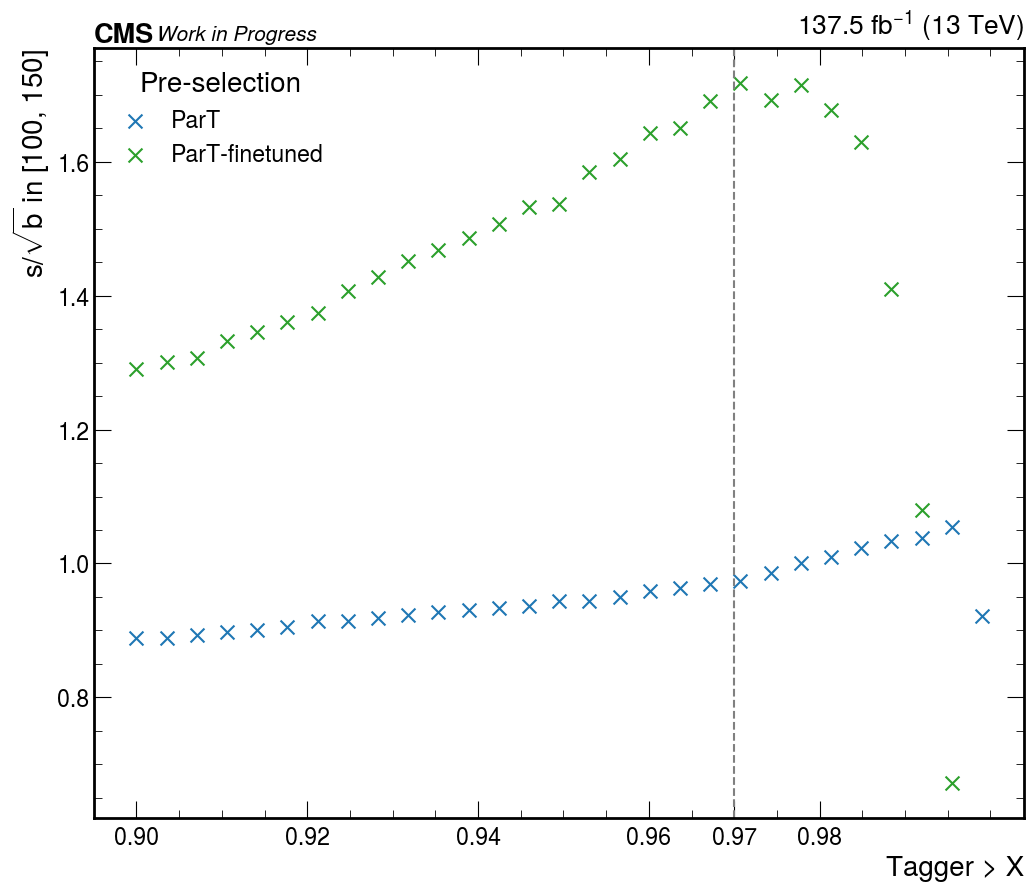

In [513]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:green",   
    
    "fj_ParT_score (no miso cut)": "tab:orange",

    "fj_ParT_score_finetuned (no miso cut)": "tab:red",      
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
    "fj_ParT_score (no miso cut)": "ParT-finetuned (w/o miso cut)",
    "fj_ParT_score_finetuned (no miso cut)": "ParT-finetuned (w/o miso cut)",    

}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))

for tagger in [
    "fj_ParT_score",
#     "fj_ParT_score (no miso cut)",

    "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned (no miso cut)",   
]:
    ax.scatter(tagger_cuts, s_over_b[tagger], marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])

ax.axvline(0.97, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(1.25, 2.25)
ax.legend(title=f"Pre-selection")
ax.set_ylabel(r"$s/\sqrt{b}$ in " + f"[{mass_window[0]}, {mass_window[1]}]");
ax.set_xlabel(r"Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])


lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/AN/misocutssss.pdf")

In [1908]:
# tagger_cuts = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.8]
# tagger_cuts = [0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95]


# tagger_cuts = [0.95, 0.955, 0.96, 0.965, 0.97, 0.975, 0.98, 0.985, 0.99]
# tagger_cuts = [0.90, 0.925, 0.95, 0.975, 0.99]

# tagger_cuts = np.linspace(0.9, 0.99, 19)
tagger_cuts = np.linspace(0.7, 0.97, 28)
# tagger_cuts = np.linspace(0.1, 0.85, 25)

wp = 0.97
mass_window = [80, 160]

years = ["2017", "2018", "2016", "2016APV"]

channels = ["ele", "mu"]

s_over_b = {}  
                        
for tagger in [
#     "fj_ParT_score",
#     "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned_HPO",

    "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned (after MET>X)",
    "fj_ParT_score_finetuned (after JetpT>300)",    
]:

        
    print("TAGGER:", tagger)
    s_over_b[tagger] = []

    for tagger_cut in tagger_cuts:
        print("tagger cut", tagger_cut)
        s, b = 0, 0
        for year in years:
            for ch in channels:
                for sample in events_dict["signal_region"][year][ch]:
                    if sample=="Data":
                        continue
                        
                    if "JetpT>300" in tagger:
                        df = events_dict["signal_region"][year][ch][sample]   # doesnt include low pt bin
                    else:
                        df = events_dict2["signal_region"][year][ch][sample]       # includes low pt bin                                        

                    # add tagger cut
                    if "fj_ParT_score_finetuned" in tagger:
                        df = df[df["fj_ParT_score_finetuned"]>tagger_cut]
                        # add inverted tagger cut
                        df = df[df["fj_ParT_score_finetuned"]<wp]
                    
                    else:
                        df = df[df["fj_ParT_score"]>tagger_cut]
                        # add inverted tagger cut
                        df = df[df["fj_ParT_score"]<wp]                        
                        
                    if "JetpT>300" in tagger:
                        df = df[df["fj_pt"]>300]
                    
                    if "MET>X" in tagger:
                        if ch=="ele":
                            df = df[df["met_pt"]>70]
                        else:
                            df = df[df["met_pt"]>50]
                            
#                     # remove high weight events
#                     df = df[df["event_weight"]<145]

                    df = df[df["fj_pt"]>300]
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]

                    df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                    ##############################    
                    if sample in utils.signals:
                        s += df["event_weight"].sum()
                    else:
                        b += df["event_weight"].sum()

        s_over_b[tagger].append(s/math.sqrt(b))

TAGGER: fj_ParT_score_finetuned
tagger cut 0.7
tagger cut 0.71
tagger cut 0.72
tagger cut 0.73
tagger cut 0.74
tagger cut 0.75
tagger cut 0.76
tagger cut 0.77
tagger cut 0.7799999999999999
tagger cut 0.7899999999999999
tagger cut 0.7999999999999999
tagger cut 0.8099999999999999
tagger cut 0.82
tagger cut 0.83
tagger cut 0.84
tagger cut 0.85
tagger cut 0.86
tagger cut 0.87
tagger cut 0.8799999999999999
tagger cut 0.8899999999999999
tagger cut 0.8999999999999999
tagger cut 0.9099999999999999
tagger cut 0.9199999999999999
tagger cut 0.9299999999999999
tagger cut 0.94
tagger cut 0.95
tagger cut 0.96
tagger cut 0.97


/var/folders/d7/p4v84gls67vdp9_q2rkkvkch0000gn/T/ipykernel_1296/3377203758.py:86: RuntimeWarning: invalid value encountered in double_scalars
  s_over_b[tagger].append(s/math.sqrt(b))


TAGGER: fj_ParT_score_finetuned (after JetpT>300)
tagger cut 0.7
tagger cut 0.71
tagger cut 0.72
tagger cut 0.73
tagger cut 0.74
tagger cut 0.75
tagger cut 0.76
tagger cut 0.77
tagger cut 0.7799999999999999
tagger cut 0.7899999999999999
tagger cut 0.7999999999999999
tagger cut 0.8099999999999999
tagger cut 0.82
tagger cut 0.83
tagger cut 0.84
tagger cut 0.85
tagger cut 0.86
tagger cut 0.87
tagger cut 0.8799999999999999
tagger cut 0.8899999999999999
tagger cut 0.8999999999999999
tagger cut 0.9099999999999999
tagger cut 0.9199999999999999
tagger cut 0.9299999999999999
tagger cut 0.94
tagger cut 0.95
tagger cut 0.96
tagger cut 0.97


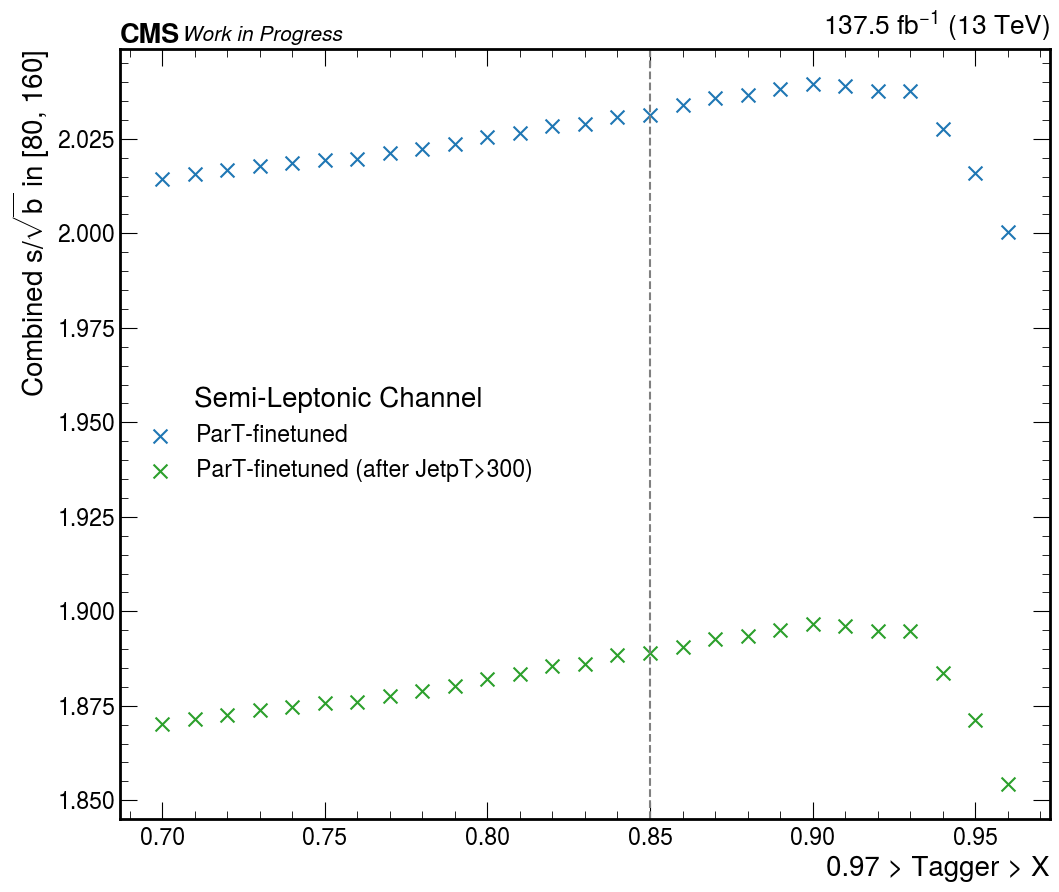

In [1909]:
color_dict = {    
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score (after MET>X)": "tab:red",    
    "fj_ParT_score (after JetpT>300)": "tab:green",        
    "fj_ParT_score (after MET>X and JetpT>300)": "tab:orange",        

    "fj_ParT_score_finetuned": "tab:blue",
    "fj_ParT_score_finetuned (after MET>X)": "tab:red",    
    "fj_ParT_score_finetuned (after JetpT>300)": "tab:green",        
    "fj_ParT_score_finetuned (after MET>X and JetpT>300)": "tab:orange",        
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score (after MET>X)": "ParT (after MET>X)",
    "fj_ParT_score (after JetpT>300)": "ParT (after JetpT>300)",
    "fj_ParT_score (after MET>X and JetpT>300)": "ParT (after MET>X and JetpT>300)",    
    
    "fj_ParT_score_finetuned": "ParT-finetuned",
    "fj_ParT_score_finetuned (after MET>X)": "ParT-finetuned (after MET>X)",
    "fj_ParT_score_finetuned (after JetpT>300)": "ParT-finetuned (after JetpT>300)",
    "fj_ParT_score_finetuned (after MET>X and JetpT>300)": "ParT-finetuned (after MET>X and JetpT>300)",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))
years = ["2017", "2018", "2016", "2016APV"]


for tagger in [
#     "fj_ParT_score",
#     "fj_ParT_score (after MET>X)",
#     "fj_ParT_score (after JetpT>300)",    
#     "fj_ParT_score (after MET>X and JetpT>300)",    

    "fj_ParT_score_finetuned",
#     "fj_ParT_score_finetuned (after MET>X)",
    "fj_ParT_score_finetuned (after JetpT>300)",    
#     "fj_ParT_score_finetuned (after MET>X and JetpT>300)",
]:
    if tagger == "fj_ParT_score_finetuned":
        soverb_high = 1.95
    else:
        soverb_high = 1.8
    
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.85, color="grey", linestyle="--")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"Combined $s/\sqrt{b}$ in " + f"[{mass_window[0]}, {mass_window[1]}]");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/soverb_medium_signal_region.pdf")

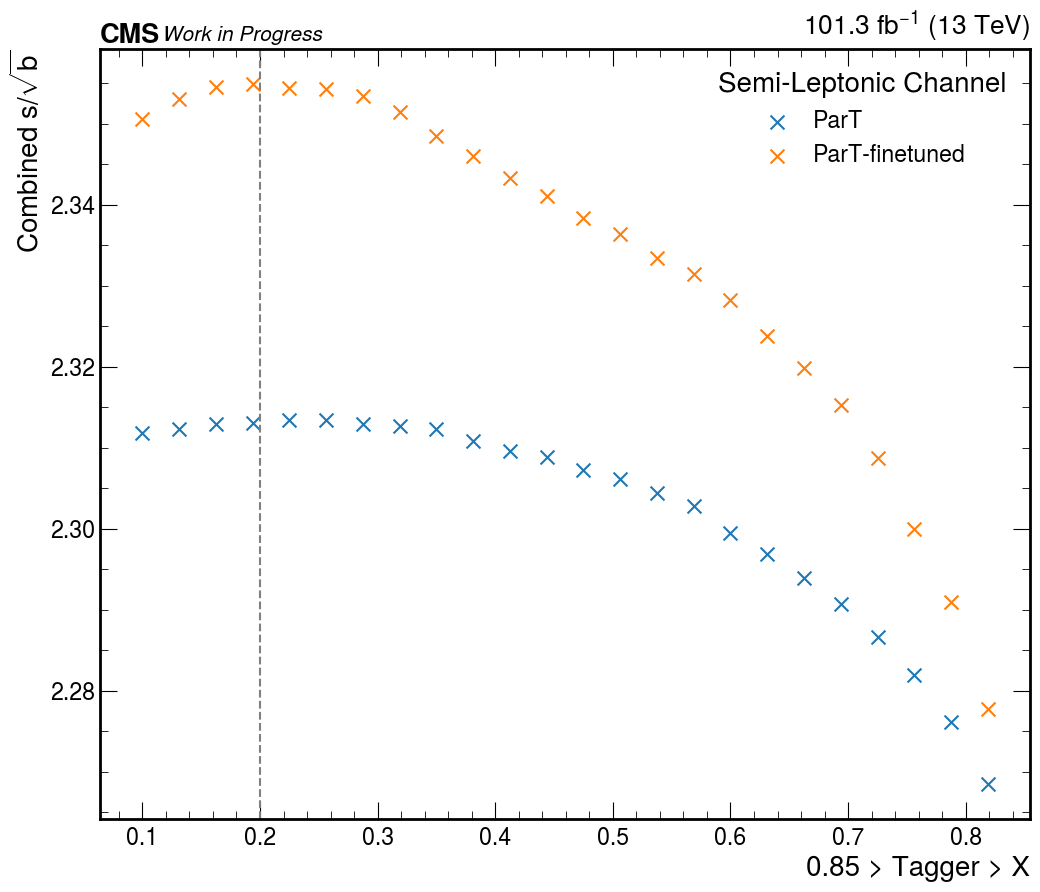

In [480]:
color_dict = {
    "fj_ParT_score": "tab:blue",
    "fj_ParT_score_finetuned": "tab:red",
    "fj_ParT_score_finetuned_HPO": "tab:green",
    "fj_ParT_score_finetuned_v2_nor2": "tab:orange",
}

lab_dict = {    
    "fj_ParT_score": "ParT",
    "fj_ParT_score_finetuned": "ParT-finetuned",
#     "fj_ParT_score_finetuned_HPO": "ParT-finetuned (HPO)",
    "fj_ParT_score_finetuned_HPO": "ParT-finetuned",    
#     "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer (HPO)",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned-singlelayer",
    "fj_ParT_score_finetuned_v2_nor2": "ParT-finetuned",
}


plt.rcParams.update({"font.size": 20})


fig, ax = plt.subplots(figsize=(12, 10))
years = ["2018", "2017"]


soverb_high = 2.26

for tagger in [
        "fj_ParT_score",
#         "fj_ParT_score_finetuned",
#         "fj_ParT_score_finetuned_HPO",


#         f"fj_ParT_score_finetuned_v2_10_5",
#         f"fj_ParT_score_finetuned_v2_10_12",   ### best: --start-lr 6.75e-3 --num-epochs 2500 norelu

#         f"fj_ParT_score_finetuned_v2_r1",
#         f"fj_ParT_score_finetuned_v2_r2",
#         f"fj_ParT_score_finetuned_v2_rs1",
#         f"fj_ParT_score_finetuned_v2_rs2",

#         f"fj_ParT_score_finetuned_v2_nor1",
    f"fj_ParT_score_finetuned_v2_nor2",
#         f"fj_ParT_score_finetuned_v2_nor3",
#         f"fj_ParT_score_finetuned_v2_nor4",
#         f"fj_ParT_score_finetuned_v2_nor5", 

#         f"fj_ParT_score_finetuned_v2_nors1",
#         f"fj_ParT_score_finetuned_v2_nors2",
]:
    ax.scatter(tagger_cuts, ((soverb_high**2+np.array(s_over_b[tagger])**2)**0.5), marker="x", s=100, label=lab_dict[tagger], color=color_dict[tagger])
#         ax.scatter(tagger_cuts, s_over_b[year][tagger], marker="x", s=100, label=tagger)

ax.axvline(0.2, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"Combined $s/\sqrt{b}$");
ax.set_xlabel(r"Tagger > X")
ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])


lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_low_signal_region.pdf")

In [170]:
events_dict["signal_region"][year][ch]["QCD"]["met_pt"]

1       642.511780
2         7.111576
4        41.294540
5       656.898438
6       183.150711
           ...    
2719     87.127525
2721    165.594070
2722    117.591286
2726    120.117790
2729     31.681070
Name: met_pt, Length: 12749, dtype: float32

In [ ]:
# # change epoch 5 and add epoch 19

# model["Model 1"]["M"] = [1.01, 1.01, 0.99, 1.00, 1.00, 1.01, 1.00, 1.00, 1.00, 1.00, 1.00, 1.01, 1.01, 1.00, 1.00, 1.02, 1.01, 1.01, 1.01]
# model["Model 1"]["IQR"] = [0.38, 0.34, 0.37, 0.36, 0.35, 0.35, 0.33, 0.35, 0.34, 0.35, 0.34, 0.33, 0.33, 0.32, 0.33, 0.36, 0.33, 0.33, 0.32] 
# model["Model 1"]["fm"] = [0.13, 0.15, 0.14, 0.15, 0.15, 0.15, 0.16, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.15, 0.15, 0.16, 0.16]
 
# model["Model 2"]["M"] = [1.05, 1.04, 1.03, 1.03, 1.03, 1.03, 1.03, 1.03, 1.02, 1.03, 1.03, 1.03, 1.03, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02]
# model["Model 2"]["IQR"] = [0.43, 0.40, 0.37, 0.36, 0.36, 0.34, 0.34, 0.34, 0.33, 0.34, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.33, 0.32, 0.32, 0.32]
# model["Model 2"]["fm"] = [0.13, 0.14, 0.14, 0.15, 0.15, 0.16, 0.17, 0.16, 0.17, 0.17, 0.17, 0.18, 0.17, 0.18, 0.18, 0.17, 0.17, 0.17, 0.17, 0.18]

In [1271]:
# 21, 31, 36, 38, 
model = {}
model["Jet"], model["MET"] = {}, {}

model["Jet"]["M"] = [1.02, 1.02, 1.02, 1.02, 1.02, 1.00, 1.00, 1.00, 1.00, 1.00, 0.99, 0.99, 1.00, 0.99, 
                     1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 
                     1.00, 1.01, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, ]
model["Jet"]["IQR"] = [0.40, 0.36, 0.35, 0.34, 0.36, 0.33, 0.32, 0.31, 0.31, 0.31, 0.31, 0.31, 0.30, 0.31, 
                       0.30, 0.30, 0.31, 0.30, 0.31, 0.31, 0.30, 0.31, 0.30, 0.31, 0.31, 0.31, 0.30, 
                       0.30, 0.31, 0.31, 0.30, 0.30,  0.31, 0.31, 0.31, 0.30, 0.31, 0.30, 0.30, 0.30, ]
model["Jet"]["fm"] = [0.14, 0.16, 0.16, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.18, 
                      0.17, 0.17, 0.17, 0.18, 0.17, 0.18, 0.18, 0.18, 0.17, 0.17, 0.18, 0.18, 0.18, 
                      0.18, 0.18, 0.17, 0.18, 0.18, 0.18, 0.17, 0.17, 0.18, 0.17, 0.17, 0.17, 0.18,]

model["MET"]["M"] = [6.00, 5.67, 5.61, 5.35, 5.34, 5.10, 5.43, 5.19, 5.32, 5.52, 5.06, 4.98, 4.67, 4.79, 
                     5.09, 4.82, 4.54, 4.67, 4.43, 4.42, 4.56, 4.79, 4.19, 4.60,  4.69, 4.07, 4.05, 
                     4.73, 4.48, 4.51, 4.32, 4.59, 4.56, 4.32, 4.69, 4.40, 4.47, 4.12, 4.28, 4.32, ]
model["MET"]["IQR"] = [12.63, 12.22, 11.70, 10.04, 9.48, 9.26, 9.98, 9.39, 9.41, 9.73, 9.58, 9.92, 9.93, 9.16, 
                       9.63, 9.05, 8.95, 8.88, 8.00, 8.34, 9.46, 8.29, 8.28, 8.89, 8.73, 8.87, 8.00, 
                       8.14, 8.75, 8.75, 8.34, 9.11, 8.60, 9.07, 9.12, 9.58, 9.08, 8.16, 9.16, 8.49, ]

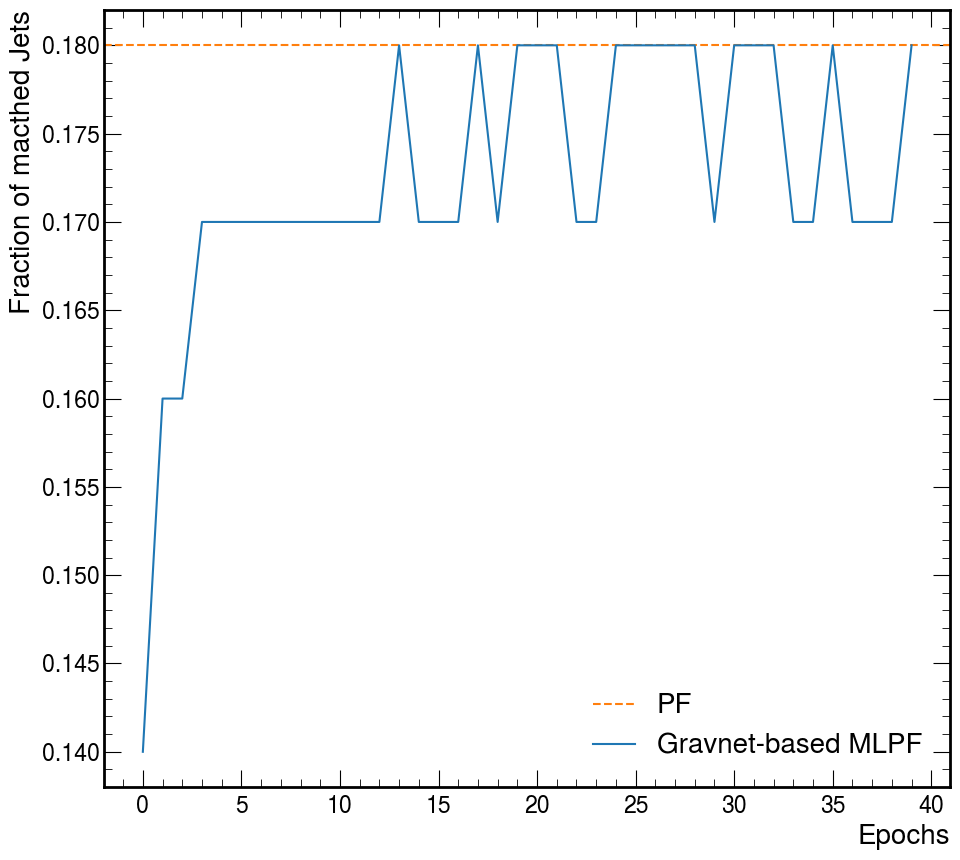

In [1285]:
fig, ax = plt.subplots(figsize=(10,9))

ax.axhline(0.18, linestyle="--", label="PF", color="tab:orange")
x = model["Jet"]["fm"]
ax.plot(x, label="Gravnet-based MLPF")


ax.set_xlabel("Epochs")
ax.set_ylabel(f"Fraction of macthed Jets")
# ax.set_xticks([0,2,4,6,8,10,12,14,16,18, 20])
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/Jet_fm.pdf")

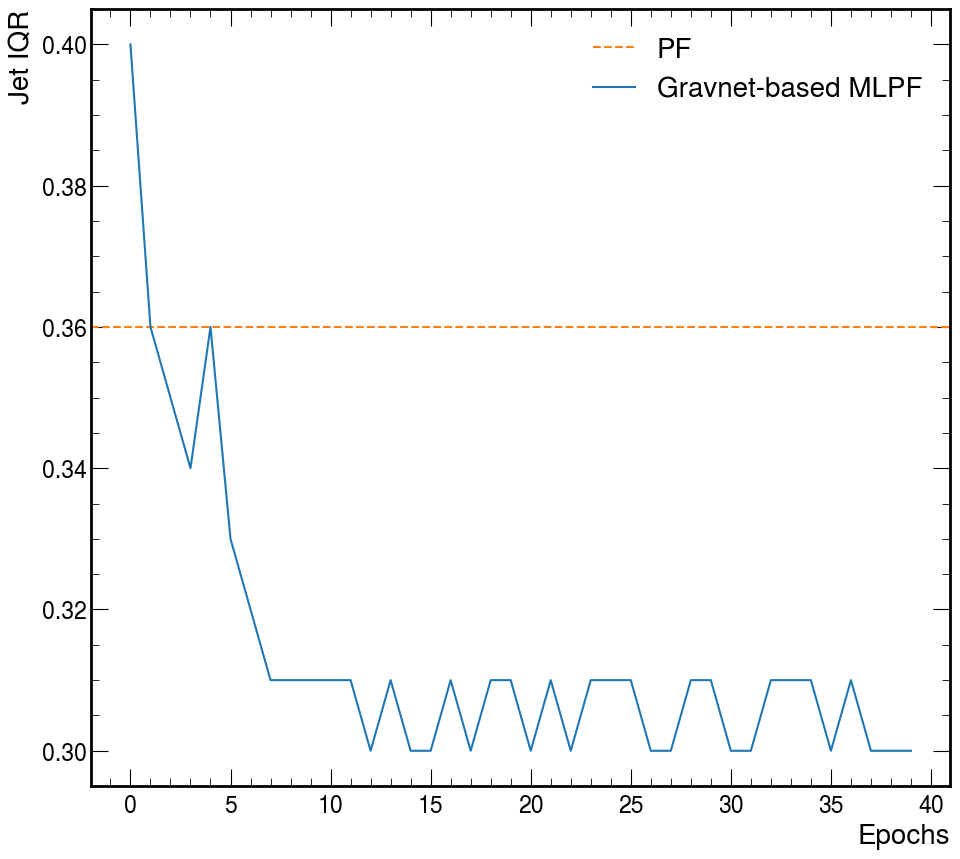

In [1286]:
fig, ax = plt.subplots(figsize=(10,9))

ax.axhline(0.36, linestyle="--", label="PF", color="tab:orange")
x = model["Jet"]["IQR"]
ax.plot(x, label="Gravnet-based MLPF")

ax.set_xlabel("Epochs")
ax.set_ylabel(f"Jet IQR")
# ax.set_xticks([0,2,4,6,8,10,12,14,16,18, 20])
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/Jet_IQR.pdf")

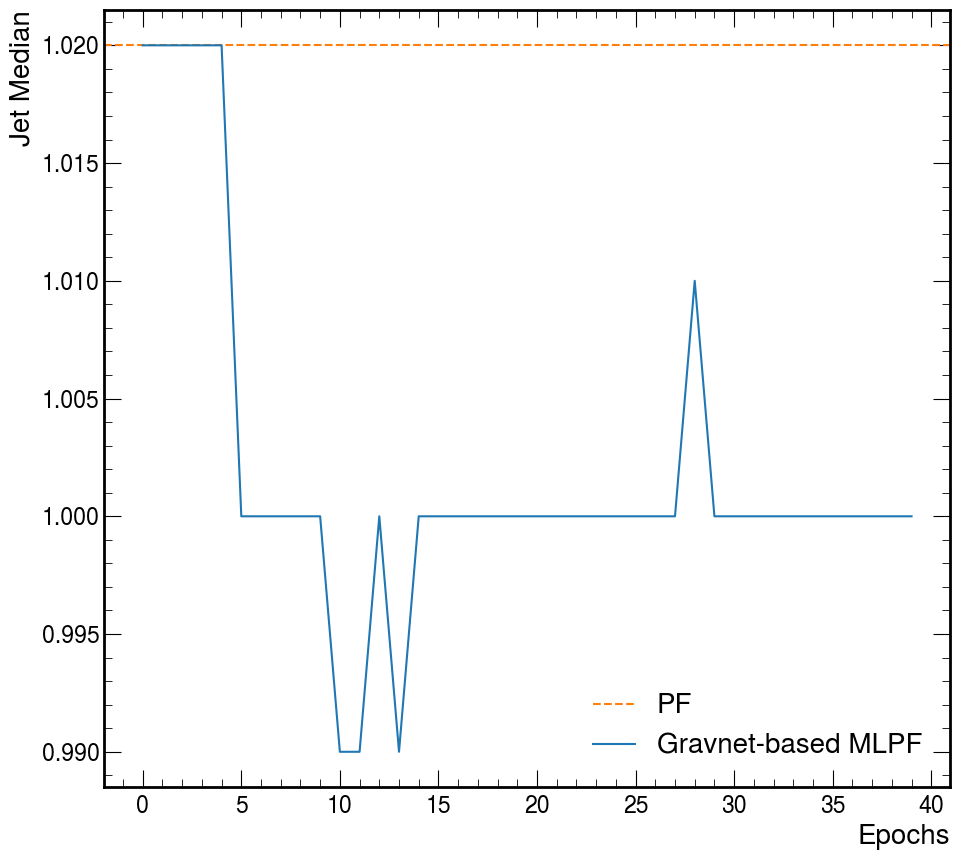

In [1288]:
fig, ax = plt.subplots(figsize=(10,9))

ax.axhline(1.02, linestyle="--", label="PF", color="tab:orange")
x = model["Jet"]["M"]
ax.plot(x, label="Gravnet-based MLPF")

ax.set_xlabel("Epochs")
ax.set_ylabel(f"Jet Median")
# ax.set_xticks([0,2,4,6,8,10,12,14,16,18, 20])
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/Jet_M.pdf")

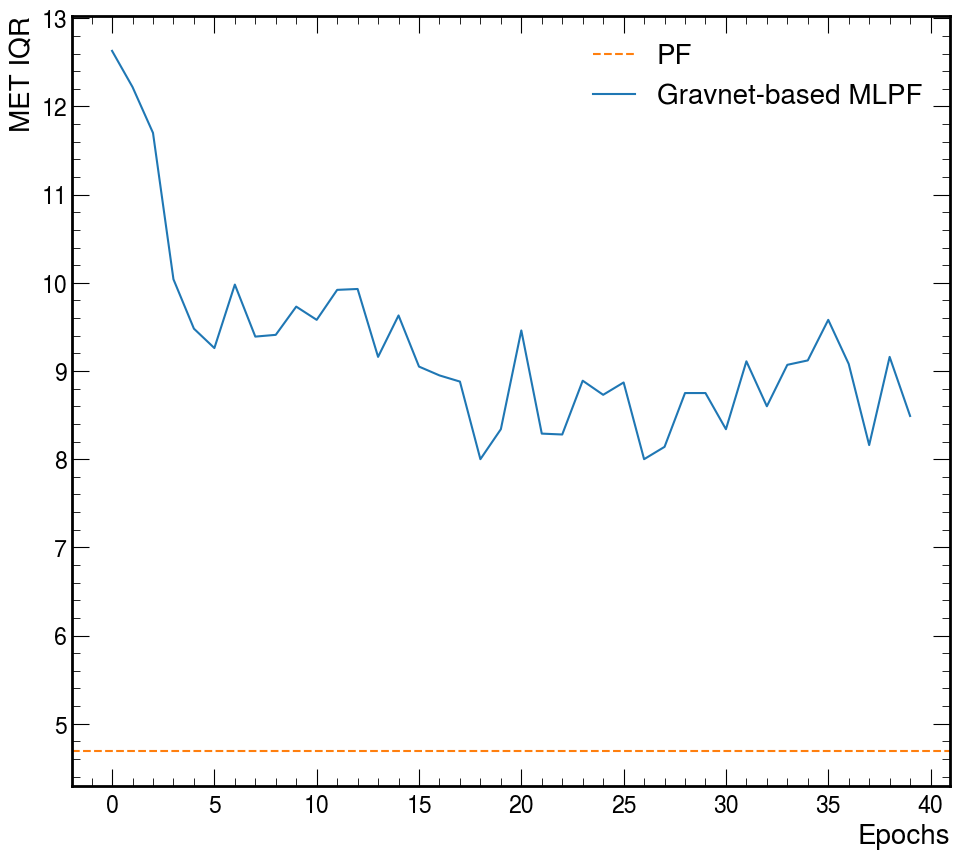

In [1291]:
fig, ax = plt.subplots(figsize=(10,9))

ax.axhline(4.69, linestyle="--", label="PF", color="tab:orange")
x = model["MET"]["IQR"]
ax.plot(x, label="Gravnet-based MLPF")

ax.set_xlabel("Epochs")
ax.set_ylabel(f"MET IQR")
# ax.set_xticks([0,2,4,6,8,10,12,14,16,18, 20])
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/MET_IQR.pdf")

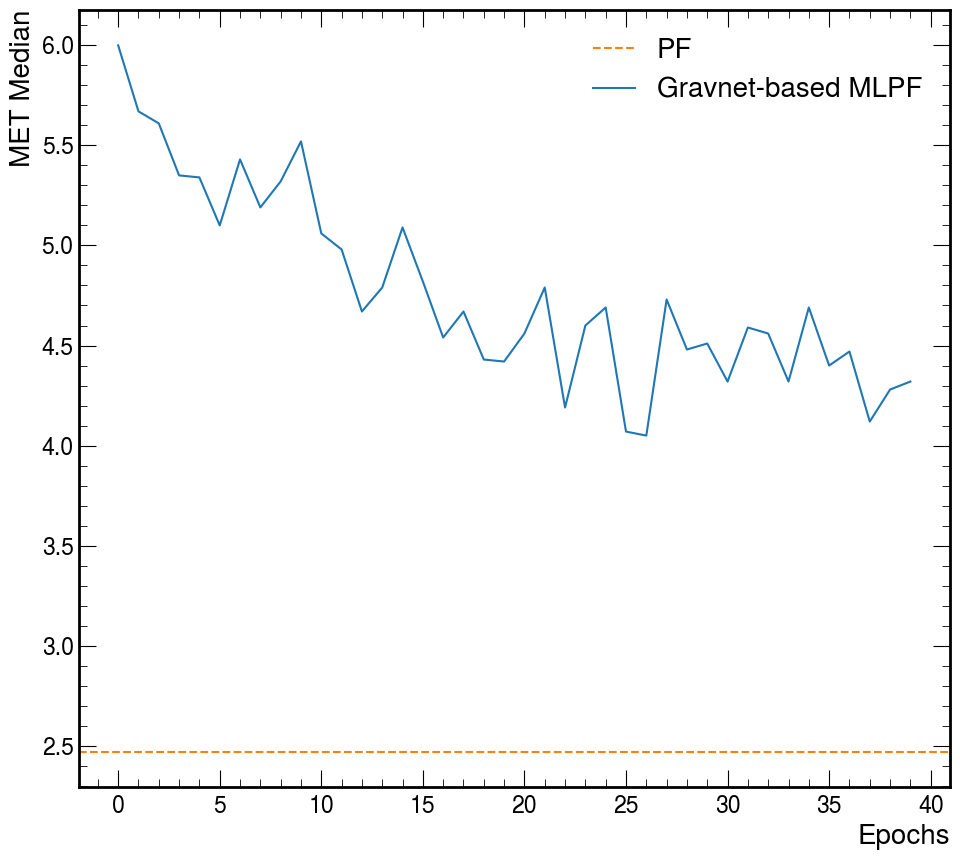

In [1290]:
fig, ax = plt.subplots(figsize=(10,9))

ax.axhline(2.47, linestyle="--", label="PF", color="tab:orange")
x = model["MET"]["M"]
ax.plot(x, label="Gravnet-based MLPF")

ax.set_xlabel("Epochs")
ax.set_ylabel(f"MET Median")
# ax.set_xticks([0,2,4,6,8,10,12,14,16,18, 20])
ax.legend(fontsize=20)
plt.tight_layout()
plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/MET_M.pdf")

In [891]:
! ls /Users/fmokhtar/Downloads/

mlpf_losses.pkl


In [997]:
import pickle as pkl
with open("/Users/fmokhtar/Downloads/mlpf_losses_1.pkl", "rb") as f:
    losses1 = pkl.load(f)
    
import pickle as pkl
with open("/Users/fmokhtar/Downloads/mlpf_losses_2.pkl", "rb") as f:
    losses2 = pkl.load(f)    

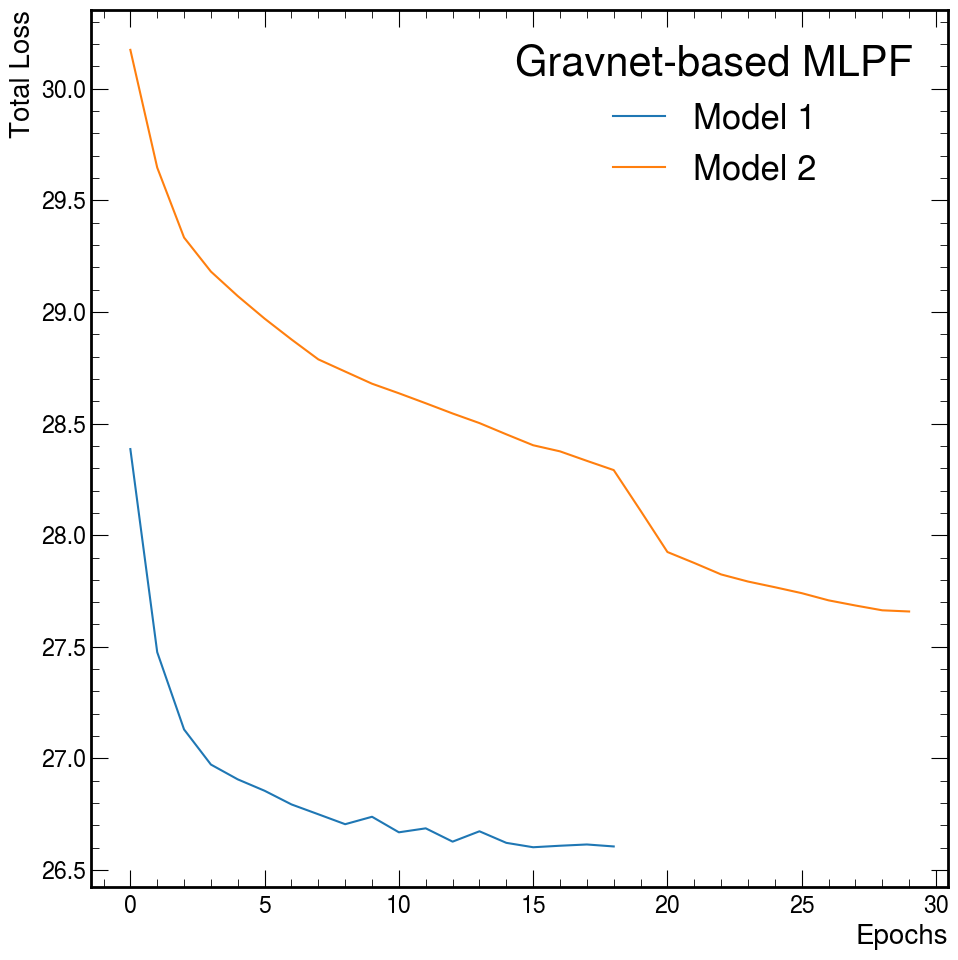

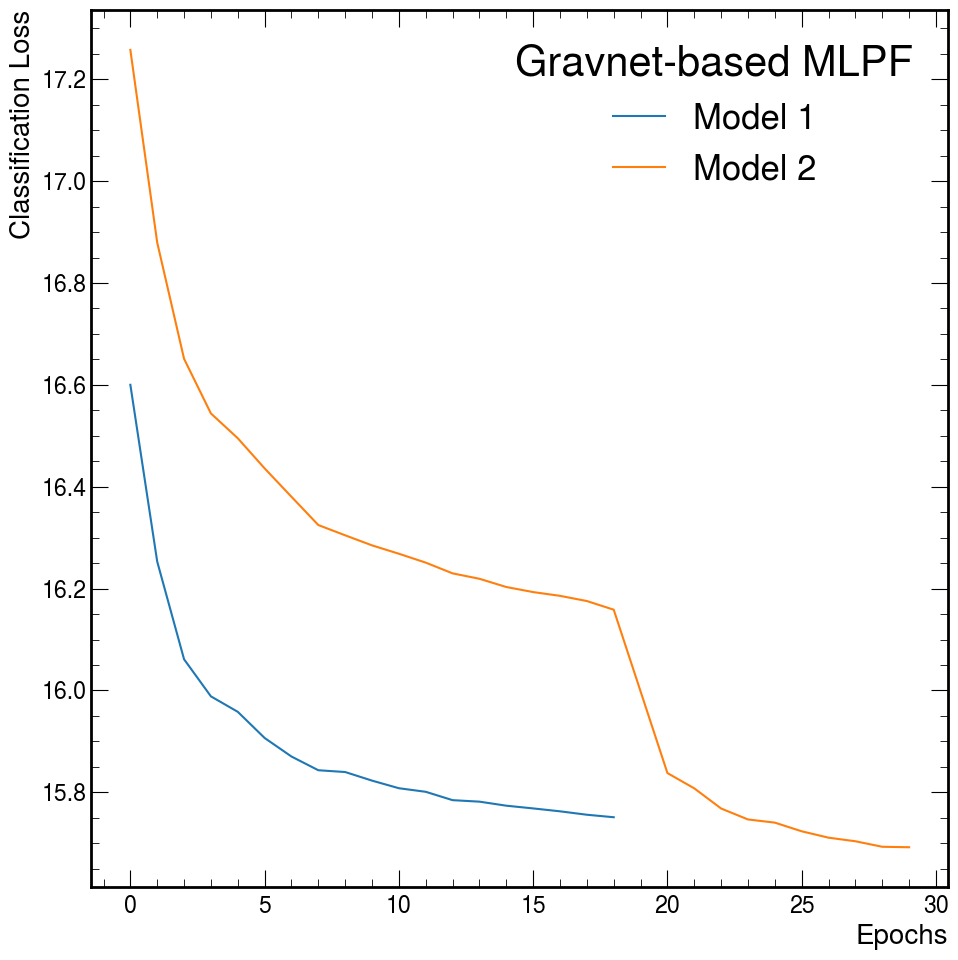

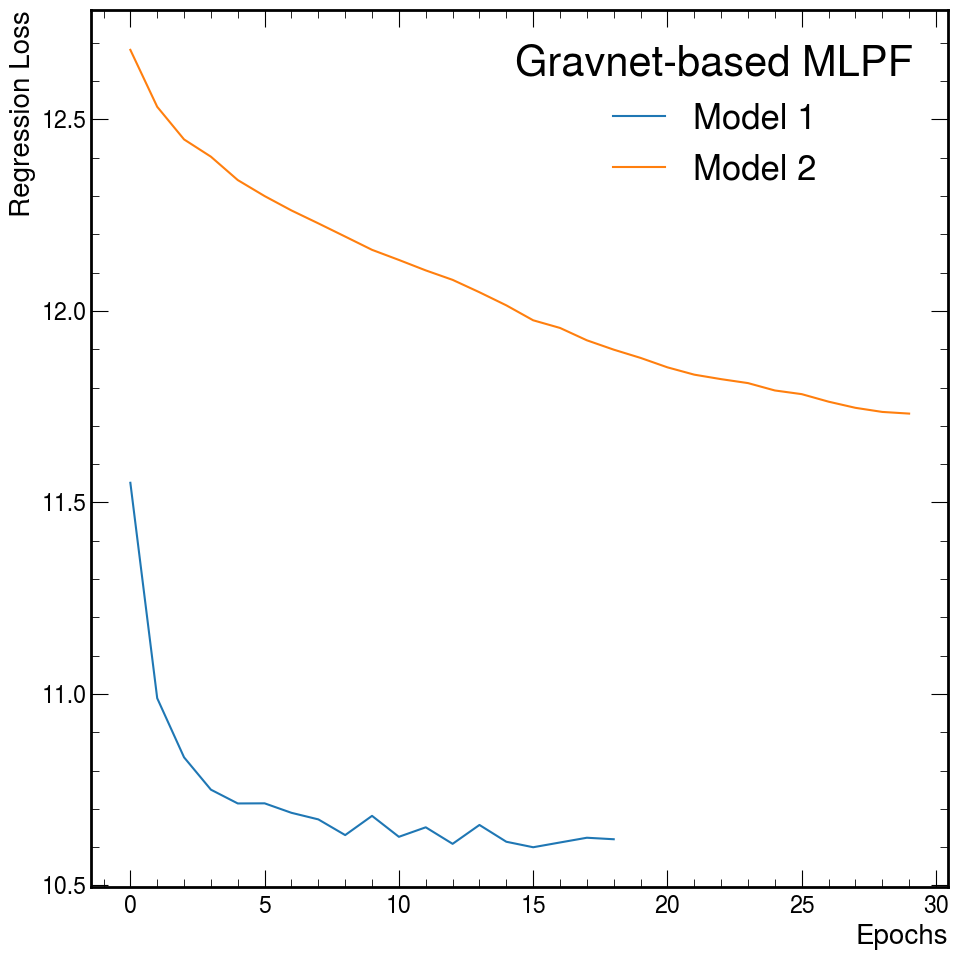

In [1003]:
for loss in ["Total", "Classification", "Regression"]:
    fig, ax = plt.subplots()

    ax.plot(losses1["valid"][loss], label="Model 1")
    ax.plot(losses2["valid"][loss], label="Model 2")
    
    ax.set_xlabel("Epochs")
    ax.set_ylabel(f"{loss} Loss")
#     ax.set_ylim(0.8 * losses["train"][loss][-1], 1.2 * losses["train"][loss][-1])
    ax.legend(title="Gravnet-based MLPF", loc="best", title_fontsize=30, fontsize=25)
    plt.tight_layout()
    plt.savefig(f"/Users/fmokhtar/Desktop/mlpfz/mlpf_loss_{loss}.pdf")

In [967]:
"checkpoint-01-28.385813.pth"[:13]

'checkpoint-01'

In [26]:
ch = "mu"
df_sig = events_dict["new_corrections"][year][ch]["VH"]


df_sig["fj_H_VV_isMatched"].sum() / len(df_sig)

1.0

In [27]:
df_sig.keys()

Index(['fj_msoftdrop', 'lep_pt', 'lep_isolation', 'lep_misolation',
       'lep_fj_dr', 'lep_met_mt', 'met_fj_dphi', 'met_pt', 'deta', 'mjj',
       'n_bjets_L', 'n_bjets_M', 'n_bjets_T', 'n_bjetsDeepCSV_L',
       'n_bjetsDeepCSV_M', 'n_bjetsDeepCSV_T', 'fj_lsf3', 'fj_minus_lep_m',
       'fj_pt', 'rec_higgs_m', 'fj_genH_pt', 'fj_genH_jet', 'fj_genV_dR',
       'fj_genVstar', 'genV_genVstar_dR', 'fj_nquarks', 'fj_ncquarks',
       'fj_lepinprongs', 'fj_H_VV_4q', 'fj_H_VV_elenuqq', 'fj_H_VV_munuqq',
       'fj_H_VV_taunuqq', 'fj_H_VV_isVlepton', 'fj_H_VV_isVstarlepton',
       'fj_H_VV_isMatched', 'gen_Vlep_pt', 'fj_genRes_mass', 'fj_genjetmass',
       'fj_genjetpt', 'weight_mu', 'weight_ele', 'fj_ParT_score',
       'fj_ParT_mass', 'event_weight', 'fj_ParT_score_finetuned'],
      dtype='object')

# Signal

In [517]:
ev = events_dict["new_correctionsNODPHI"]
for key in ev[year][ch]["ggF"]:
    print(key)

fj_msoftdrop
lep_pt
lep_isolation
lep_misolation
lep_fj_dr
lep_met_mt
met_fj_dphi
met_pt
deta
mjj
n_bjets_L
n_bjets_M
n_bjets_T
n_bjetsDeepCSV_L
n_bjetsDeepCSV_M
n_bjetsDeepCSV_T
fj_lsf3
fj_minus_lep_m
fj_pt
rec_higgs_m
fj_genH_pt
fj_genH_jet
fj_genV_dR
fj_genVstar
genV_genVstar_dR
fj_nquarks
fj_ncquarks
fj_lepinprongs
fj_H_VV_4q
fj_H_VV_elenuqq
fj_H_VV_munuqq
fj_H_VV_taunuqq
fj_H_VV_isVlepton
fj_H_VV_isVstarlepton
fj_H_VV_isMatched
gen_Vlep_pt
fj_genRes_mass
fj_genjetmass
fj_genjetpt
weight_mu
weight_ele
fj_ParT_score
fj_ParT_mass
abs_met_fj_dphi
event_weight
fj_ParT_score_finetuned


In [519]:
ev[year][ch]["ggF"]["fj_genH_jet"]

0        0.032142
10       0.025425
12       0.044504
15       0.040794
20       0.018813
           ...   
10652    0.052231
10655    0.147691
10660    0.045230
10665    0.042704
10670    0.094390
Name: fj_genH_jet, Length: 2879, dtype: float32

In [522]:
tagger = "fj_ParT_score_finetuned"

presel = {    
    "Pre-selection": f"fj_pt>0",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var2 = "abs_met_fj_dphi"

samples = ["ggF", "VBF", "VH", "ttH"]


var1 = "rec_higgs_m"
var1 = "lep_fj_dr"
var1 = "lep_pt"
var1 = "met_pt"
var1 = "fj_genH_jet"

if var1 == "rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 10)), name="var1", label=r"Higgs reconstructed mass [GeV]", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    )
elif var1 == "lep_fj_dr":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(35, 0.0, 0.8, name="var1", label=r"$\Delta R(Jet, Lepton)$", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    ) 
elif var1 == "lep_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(40, 30, 450, name="var1", label=r"Lepton $p_T$ [GeV]", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    ) 
elif var1 == "met_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(40, 0, 450, name="var1", label=r"MET", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    ) 
elif var1 == "fj_genH_jet":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(40, 0.0, 0.8, name="var1", label=r"dR(Jet, Higgs)", overflow=True),
        hist2.axis.Regular(
        35, 0, 3.14, name="var2", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True),
    )     
    
    
    
    
    
ev = events_dict["new_correctionsNODPHI"]

region, sel = list(presel.items())[0]

for year in years:
    for ch in channels:    

        for sample in samples:
            for ismatched in [True, False]:

                df = ev[year][ch][sample]

                df = df.query(sel)    
                            
                h.fill(
                    samples=sample,
                    var1=df[var1],
                    var2=df[var2],
                    weight=df["event_weight"],
                )     

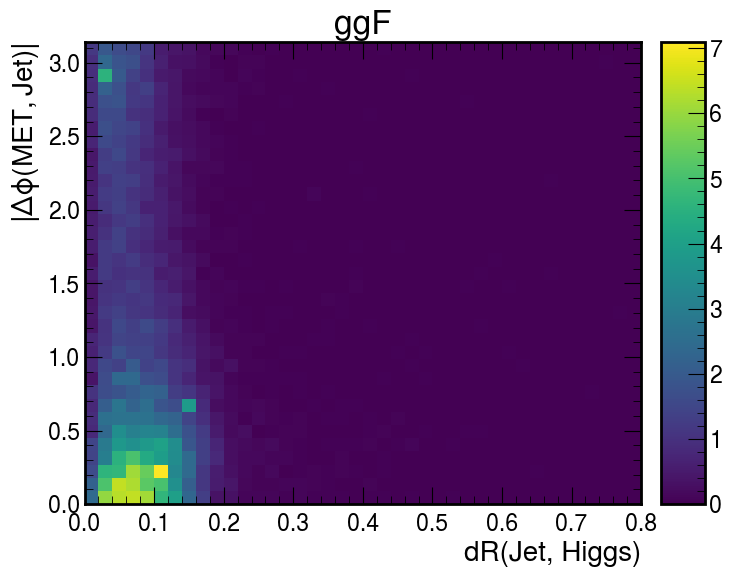

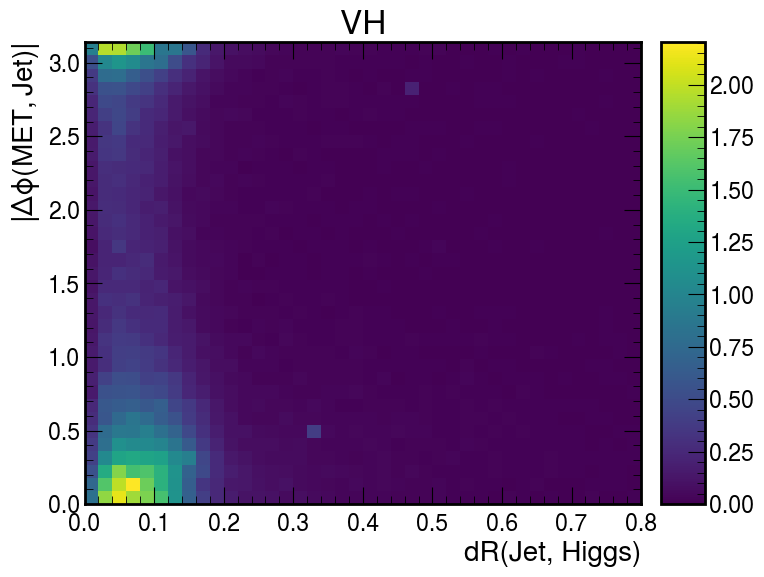

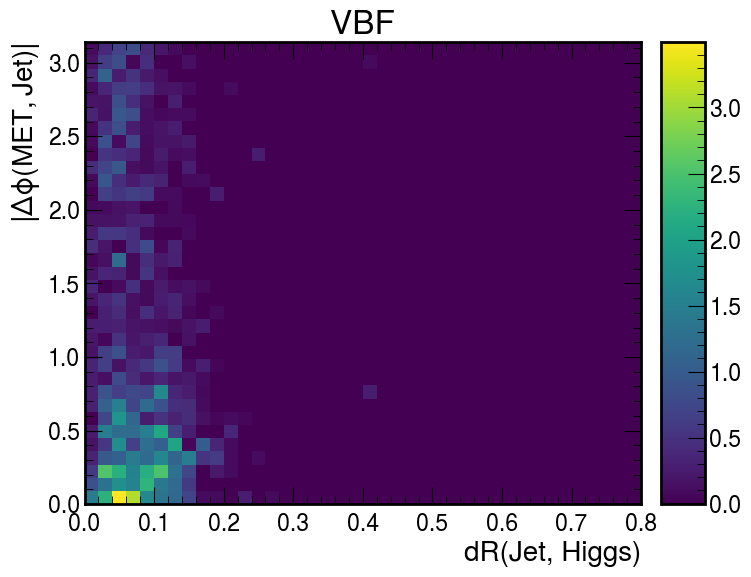

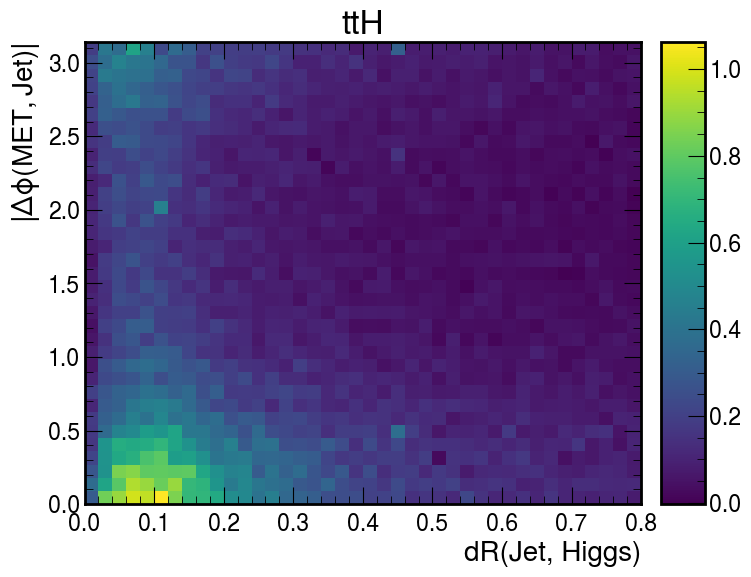

In [523]:
samples_to_plot = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
#      "QCD",
#     "DYJets",
#     "WJetsLNu",
#     "TTbar",
]

var1 = "abs_met_fj_dphi"
var2 = "met"

from matplotlib.colors import LogNorm


for sample in samples_to_plot:
    fig, ax = plt.subplots(figsize=(8, 6))
    hep.hist2dplot(h[{"samples": sample}], flow="none")
    ax.set_title(sample)

    plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/2d-{sample}.pdf")     

In [437]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    "Pre-selection": f"fj_pt>0",
    
#     "High purity signal region": f"({tagger}>0.97)",
#     "High purity signal region + MET>X": f"({tagger}>0.97) & (n_bjets_T==0)",
    
#     "High purity signal region + nbjetsL=0": f"({tagger}>0.97) & (n_bjets_L==0)",
#     "High purity signal region + nbjetsM=0": f"({tagger}>0.97) & (n_bjets_M==0)",
#     "High purity signal region + nbjetsT=0": f"({tagger}>0.97) & (n_bjets_T==0)",    
    
#     "Medium purity signal region + nbjetsT=0 + MET>X": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",   
    
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "rec_higgs_m"
var = "abs_met_fj_dphi"

samples = ["ggF", "VBF", "VH", "ttH"]

if var == "rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )
elif var == "abs_met_fj_dphi":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Regular(
        25, 0, 3.14, name="var", label=r"$\left| \Delta \phi(MET, Jet) \right|$", overflow=True
    ),
    )
    
else:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        utils.axis_dict[var],
    )    
ev = events_dict["sig"]

region, sel = list(presel.items())[0]

for year in ["2018"]:
    for ch in channels:    

        for sample in samples:
            for ismatched in [False]:

                df = ev[year][ch][sample]

                df = df.query(sel)    
                
                df = df[(df["fj_H_VV_isMatched"] == ismatched)]
                
                if ismatched:
                    lab = sample + "matched"
                else:
                    lab = sample
#                 df = df[(df["fj_H_VV_isVlepton"] == ismatched)]
#                 if ismatched:
#                     lab = sample + " (lepton from W)"
#                 else:
#                     lab = sample + " (lepton from W*)"
                if len(df[var])==0:
                    x = 0
                
                else:
                    x = df[var]
                    


                h.fill(
                    samples=lab,
                    var=x,
                    weight=df["event_weight"],
                )     

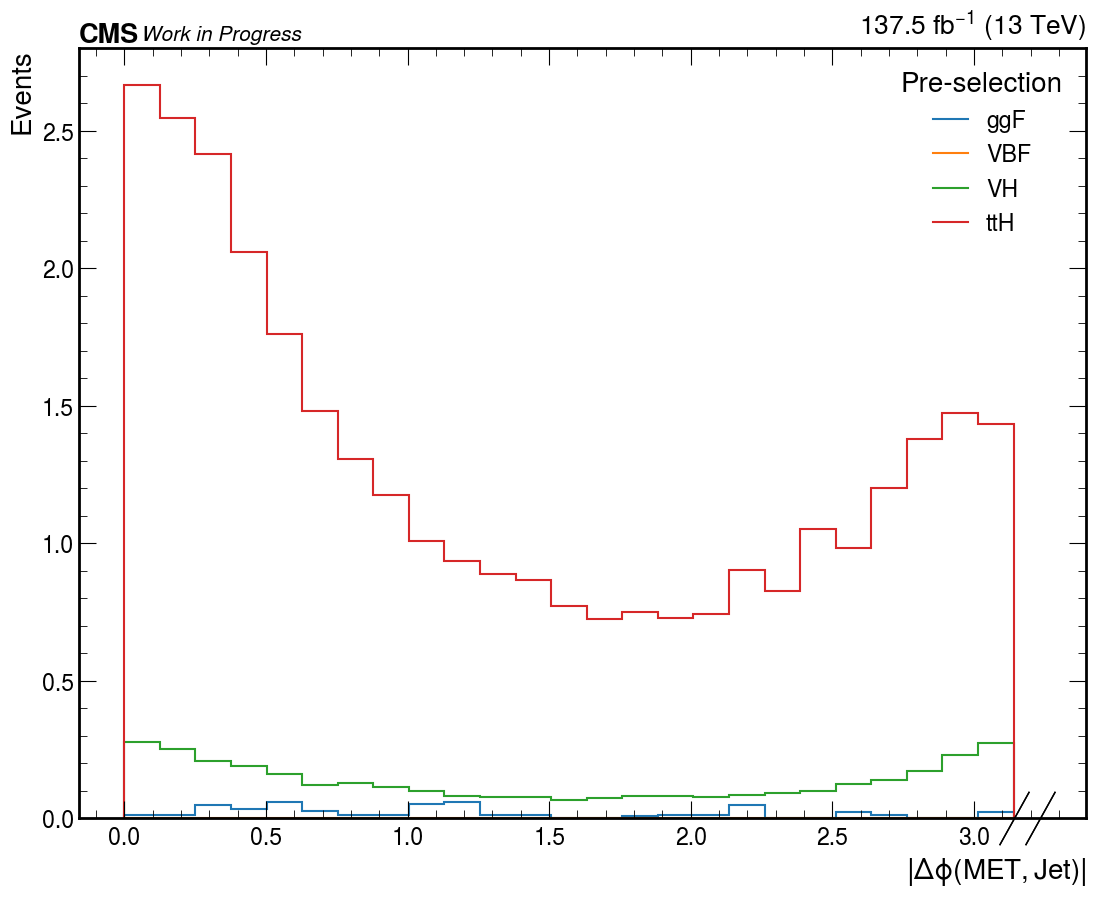

In [438]:
# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for sample in list(h.axes["samples"]):
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=True,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Events")
ax.set_ylim(0)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/z.pdf")     

In [473]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
def get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=False, misocut=None):

    mass_window = [100, 150]

    num_sig = {
        "ggF": 0, 
        "ttH": 0, 
        "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "DYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0
    s, b = 0, 0

    samples = [
        "ggF", 
        "VH",
        "VBF",
        "ttH",
        "QCD",
        "DYJets",
        "WJetsLNu",
        "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data"
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)
                    
                if MET_cut:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                
                if misocut:
                    if ch =="mu":
                        keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]<miso_cut ) )
                        df = df.loc[keep, :]                        
                
                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end

                ######################## soverb start
                df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]

                if sample in utils.signals:                
                    s += df["event_weight"].sum()
                else:
                    b += df["event_weight"].sum()
                ######################## soverb end

    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "Run2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
    if len(list(categories_sel.items()))!=0:
        print("Category:", rf"{category}")

    print("------------------------")

    if "SR" in list(presel.keys())[0]:
        print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
        print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

# Stacked hists

In [486]:
vars_to_plot = [
    "fj_minus_lep_m",
    "fj_pt",
    "lep_pt",
    "lep_fj_dr",
    "lep_met_mt",
    "met_fj_dphi",
    "met",    
    "rec_higgs_m",
    "fj_msoftdrop",    
    "fj_pt_over_lep_pt",    
    "deta",
    "mjj",
    "fj_ParT_mass",
    "fj_ParT_score_finetuned"
]

samples_to_plot = [
    "ggF", 
    "VH",
    "VBF",
    "ttH",
    "QCD",
    "DYJets",
    "WJetsLNu",
    "WZQQ",
    "TTbar",
    "SingleTop",
    "Diboson",
    "Data",
]

# samples_to_plot = ["QCD"]

In [614]:
# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {
    ################################################
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",        
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.5 + nbjetsT>0)": f"({tagger}>0.5) & (n_bjets_T>0)",    
    ################################################
    
#     "Pre-selection": f"fj_pt>0",
}

categories_sel = {
#     "VBF category": "(mjj>1000) & (deta>3.5)",
    rf"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
#     rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",    
    
}

channels = ["ele", "mu"]
# channels = ["mu"]
years = ["2018", "2017", "2016", "2016APV"]
# years = ["2016APV"]

num, den = 0, 0
threshold = 0
# fill histograms
hists = {}

# ev = events_dict["old_corrections"]
ev = events_dict["new_corrections"]
# ev = events_dict["new_correctionsNOMISO"]

for var in vars_to_plot:

    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Variable(list(range(50, 240, 10)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
#             hist2.axis.Regular(50, 0, 1, name="var", label=r"tagger", overflow=True)
            
        )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:
            
                region, sel = list(presel.items())[0]
                
                df = ev[year][ch][sample]

                df = df.query(sel)
                    
                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]

                for category, category_sel in categories_sel.items():
                    df = df.query(category_sel)
                
                
#                 if ch =="mu":
#                     miso_cut = 0.2
#                     keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]<miso_cut ) )
#                     df = df.loc[keep, :]              
                
                
                
#                 if sample != "Data":
#                     df["event_weight"] *= df["T_btagSF"]

                
# # #                 if "High" in region:
                if ("SR2" in region) and (sample == "DYJets"):
                    threshold = 100
                    den += len(df['event_weight'])
                    num += sum(df["event_weight"]>threshold)

                    df = df[df["event_weight"] < threshold]

# # #                 if "Medium" in region:

#                 if sample == "QCD":
#                     threshold = 10
#                     den += len(df['event_weight'])
#                     num += sum(df["event_weight"]>threshold)

#                     df = df[df["event_weight"] < threshold]

                    
                if var=="met":
                    x = df["met_pt"]
                elif var=="fj_pt_over_lep_pt":
                    x = df["fj_pt"]/df["lep_pt"] 
                elif var=="met_fj_dphi":
                    x = np.abs(df["met_fj_dphi"])
                else:
                    x = df[var]

                hists[var].fill(
                    samples=sample,
                    var=x,
                    weight=df["event_weight"],
                )     
try:
    print(f"Removing {num} out of {den} qcd events by applying qcd event_weight<{threshold} ({(100*num/den):.2f}%)")
except:
    z=1

In [615]:
plt.rcParams.update({"font.size": 20})
add_data = False

if "MET>X" in region:
    MET_cut = True
else:
    MET_cut = False
    
# if "dphi<" in region:
#     dphimet = dphimet
# else:
#     dphimet = None    

if "SR" in region:
    add_soverb=True
    blind_region=[90,160]
    if "SR1" in region:
        mult=10
    else:
        mult=30
else:
    add_soverb=True
    blind_region=None
    mult=1
    
from utils import plot_hists
# from utilsAN import plot_hists
# plot_hists(years, channels, hists, vars_to_plot,             
#             add_data=add_data,
#             logy=False,
#             add_soverb=add_soverb,
#             only_sig=False,
#             mult=mult,
#             outpath=f"/Users/fmokhtar/Desktop/AN/{years[0]}/",
# #             outpath=f"/Users/fmokhtar/Desktop/AN/RUN2/",           
#             text_=region,
# #             text_=region + "+ jetpt>300",           
# #             text_=region + f"\n category: {list(categories_sel.keys())[0]}",
# #             text_=region + f"\n category: {list(categories_sel.keys())[0]} \n Applying qcd event_weight<{threshold}",
# #             text_=region + f"\n Applying qcd event_weight<{threshold}",

#             blind_region=blind_region,
# #            save_as=f"{years[0]}_{channels[0]}"
#            save_as=f"{ch}"
           
#           )
print()
get_soverb(ev, tagger, presel, categories_sel, years, channels, MET_cut=MET_cut, misocut=miso_cut)


SR1 (tagger>0.97 + nbjetsT==0) (Run2):
Category: ggF category ($p_T$ $\in$ [300, inf])
------------------------
s/sqrt(b) in [100,150]: 1.36
------------------------
Signal: 37.58
- ttH: 2%
- VBF: 12%
- VH: 19%
- ggF: 67%
------------------------
Background: 732.23
- DYJets: 3%
- QCD: 7%
- Others: 9%
- TTbar: 23%
- WJetsLNu: 58%


In [616]:
(1.14**2 + 1.36**2)**0.5    # vbf, ggf

1.77459854615065

In [613]:
(1.14**2 + 1.2**2 + 0.63**2 + 0.21**2)**0.5    # vbf, (300-450, 450-650 , 650-inf)

1.7834236737242217

In [617]:
(1.01**2 + 1.62**2)**0.5    # ele, mu

1.9090573590125575

In [485]:
(1.36**2 + 1.2**2)**0.5

1.8137254478007414

In [554]:
(0.69**2 + 1.09**2 + 0.48**2 + 1.22**2)**0.5

1.8392933425639315

In [537]:
(1.20**2 + 0.66**2)**0.5

1.3695254652615994

In [542]:
(1.20**2 + 0.6**2 + 0.27**2)**0.5

1.3685393673548452

In [580]:
(1.06**2 + 1.665**2)**0.5   # ele, mu

1.9737844360517185

In [603]:
(1.01**2 + 1.62**2)**0.5   # ele, mu

1.9090573590125575

In [432]:
(1.28**2 + 1.2**2)**0.5    # SR1: ggf + vbf

1.7545369759569047

In [456]:
sig_vbf = 1.34386
sig_ggF = 1.21626

In [458]:
(sig_vbf**2 + sig_ggF**2)**0.5    # method 1

1.8125253342229455

In [459]:
S_vbf = 5.629 + 8.134
S_ggF = 39.425 + 58.901

In [460]:
(sig_vbf*S_vbf + sig_ggF*S_ggF)/((sig_vbf**2 + sig_ggF**2)**0.5)    # method 2

76.18405289722428

In [ ]:
1.34386

In [461]:
(1.75**2 + 0.47**2)**0.5    # SR1 + SR2

1.812015452472743

In [433]:
(1.28**2 + 1.2**2 + 0.4**2)**0.5   # + SR2 ggf

1.799555500672319

In [434]:
(1.28**2 + 1.2**2 + 0.4**2 + 0.26**2)**0.5  # + SR2 vbf

1.8182409081307132

In [436]:
(1.8**2 + 1.8**2)**0.5

2.545584412271571

In [387]:
(1.72**2 + 1.04)**0.5

1.999599959991998

In [380]:
(1.98**2 + 0.76)**0.5

2.1634232133357543

In [492]:
(1.51**2 + 1.36**2 + 0.68**2)**0.5

2.1429185705481206

In [495]:
(1.51**2 + 1.52**2)**0.5

2.142545215392198

In [577]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
    
#     "Pre-selection": f"{tagger}>0.5",    
#     "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
#     "Top CR (tagger>0.5 + nbjetsT>0)": f"({tagger}>0.5) & (n_bjets_T>0)", 
    
    "Tagger>0.50": f"({tagger}>0.50)",
#     "Tagger>0.60": f"({tagger}>0.60)",
#     "Tagger>0.70": f"({tagger}>0.70)",
#     "Tagger>0.80": f"({tagger}>0.80)",
    "Tagger>0.85": f"({tagger}>0.85)",    
#     "Tagger>0.90": f"({tagger}>0.90)",    
    "Tagger>0.97": f"({tagger}>0.97)",        
    

}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "rec_higgs_m"

samples = ["ggF", "VBF", "VH", "ttH"]
samples = ["WJetsLNu", "QCD"]
samples = ["WJetsLNu"]
samples = ["TTbar"]

h = hist2.Hist(
#     hist2.axis.StrCategory([], name="corr", growth=True),
    hist2.axis.StrCategory([], name="region", growth=True),    
    hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
#     hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    
)
ev = events_dict["new_corrections"]

for region, sel in presel.items():

    for year in years:
        for ch in channels:   
            for sample in samples:

                df = ev[year][ch][sample]

                df = df.query(sel)    

                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]

                h.fill(
                    region=region,
                    var=df[var],
                    weight=df["event_weight"],
                )     

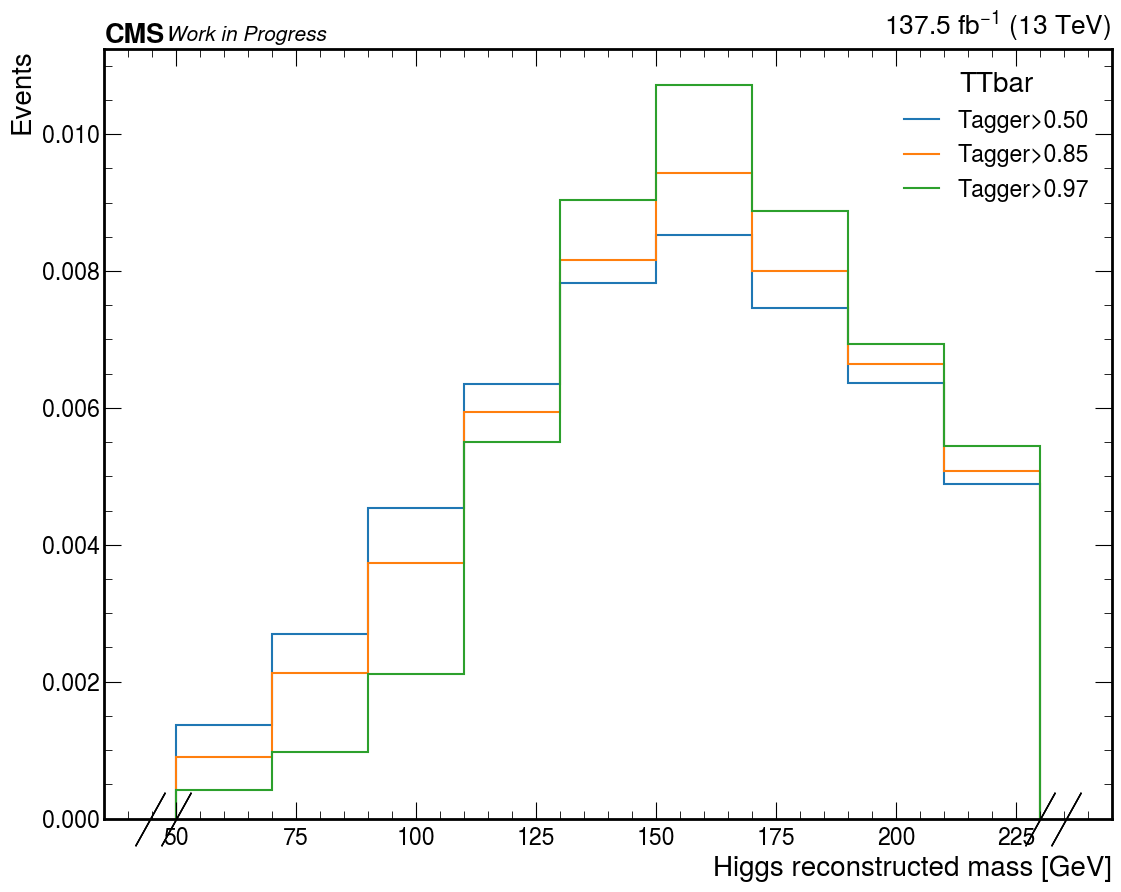

In [578]:
# different regions
fig, ax = plt.subplots(figsize=(13, 10))
for region in presel:
    hep.histplot(h[{"region": region}].project("var"),
        label=region,
        density=True,
#         yerr=True,
    )
ax.legend(title=", ".join(sample for sample in samples), loc="upper right")
ax.set_ylabel("Events")
# ax.set_ylim(0, 0.015)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/z.pdf")     

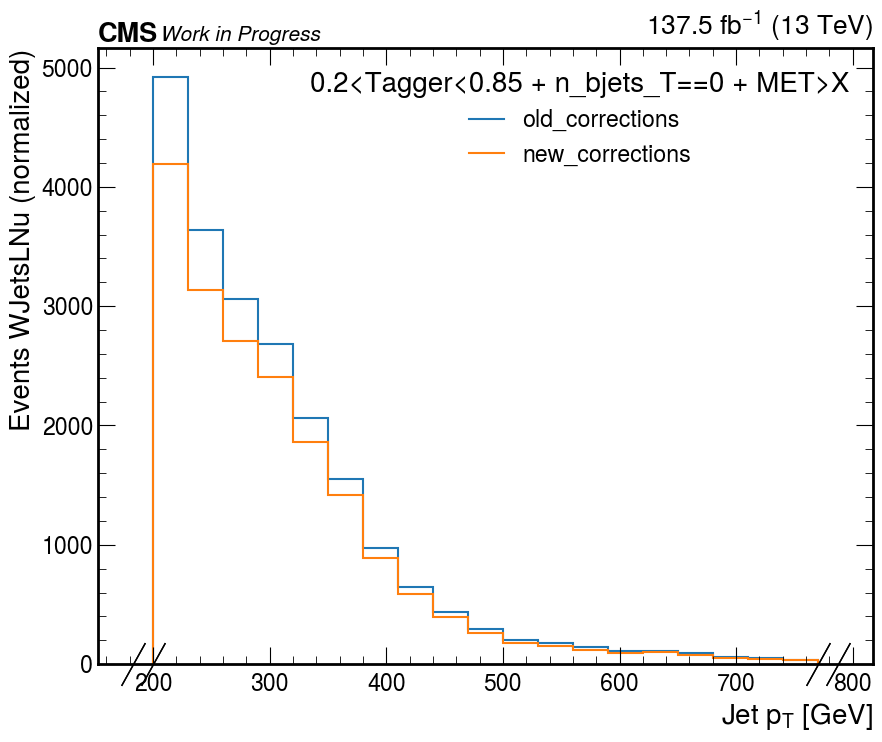

In [207]:
# different corrections
fig, ax = plt.subplots(figsize=(10, 8))
for corr in ["old_corrections", "new_corrections"]:
    hep.histplot(h[{"corr": corr}].project("var"),
        label=corr,
        density=False,
#         yerr=True,
    )
ax.legend(title=region, loc="upper right")
ax.set_ylabel(f"Events {sample} (normalized)")
# ax.set_ylim(0, 0.013)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/wjetscorr.pdf")     

In [975]:
tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

presel = {    
#     "Tagger>0.95": f"({tagger}>0.95)",
#     "Tagger>0.85": f"({tagger}>0.85)",
#     "Tagger>0.50": f"({tagger}>0.5)",
#     "Tagger>0.20": f"({tagger}>0.2)",
#     "Tagger>0.10": f"({tagger}>0.1)",
    "Tagger>0.97": f"({tagger}>0.97)",
#     "Tagger>0.85": f"({tagger}>0.85)",
    "0.85>Tagger>0.2": f"({tagger}>0.2) & ({tagger}<0.85)",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
var = "lep_met_mt"
sample = "WJetsLNu"
h = hist2.Hist(
    hist2.axis.StrCategory([], name="region", growth=True),
    hist2.axis.Variable(list(range(0, 100, 5)), name="var", label=r"mT", overflow=True)
)

for region, sel in presel.items():
                
    for year in years:
        for ch in channels:

            if "QCD" in region:
                df = events_dict["qcd_region"][year][ch][sample]
            else:
                df = events_dict["signal_region"][year][ch][sample]

            df = df.query(sel)    

#             if "High" not in region:
#                 if ch=="ele":
#                     df = df[df["met_pt"]>70]
#                 else:
#                     df = df[df["met_pt"]>50]    

#             else:
#                 threshold = 4
#                 df = df[df["event_weight"]<threshold]
                    
            h.fill(
                region=region,
                var=df[var],
                weight=df["event_weight"],
            )     


(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Work in Progress'))

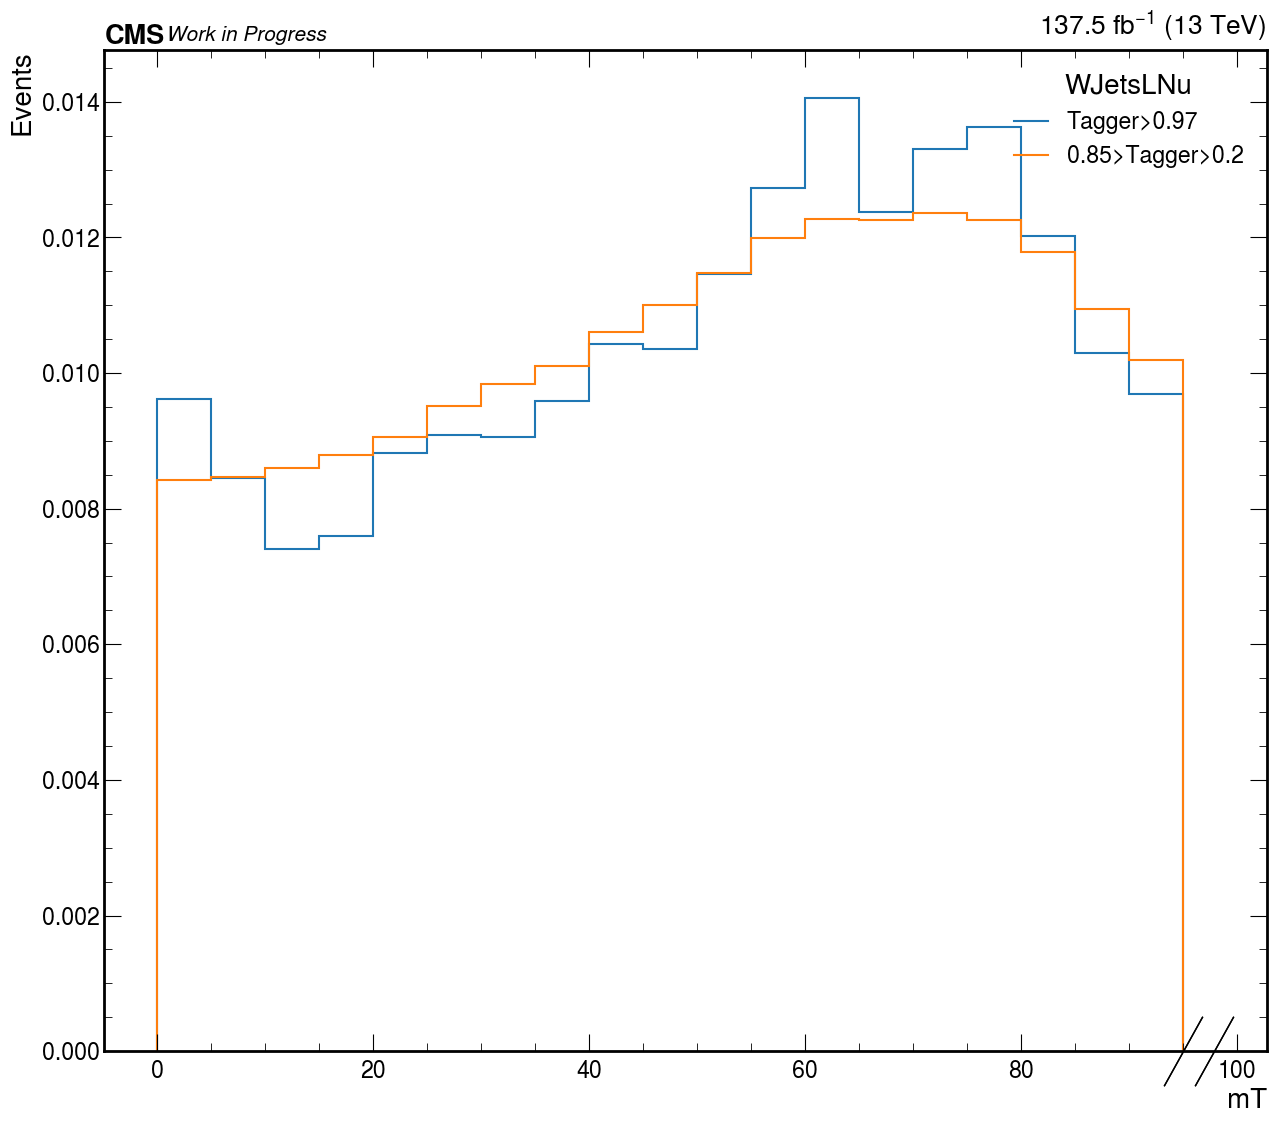

In [976]:
fig, ax = plt.subplots(figsize=(15, 13))
for region in presel:
    hep.histplot(h[{"region": region}].project("var"),
        label=region,
        density=True,
#         yerr=False,
    )
ax.legend(title=sample, loc="upper right")
ax.set_ylabel("Events")
# ax.set_ylim(0, 0.01)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
# plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/z.pdf")     

# WJetsLNu corrections

In [161]:
samples_to_plot = [
    'WJetsToLNu_HT-70To100',
    'WJetsToLNu_HT-100To200',
    'WJetsToLNu_HT-200To400',
    'WJetsToLNu_HT-400To600',
    'WJetsToLNu_HT-600To800',
    'WJetsToLNu_HT-800To1200',
    'WJetsToLNu_HT-1200To2500',
    'WJetsToLNu_HT-2500ToInf',    
]

In [181]:
tagger = "fj_ParT_score_finetuned"
presel = {
#     "Pre-selection": f"fj_pt>0",       

    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)",
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      

corr = "new_corrections_wjets"
ev = events_dict[corr]

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            try:
                df = ev[year][ch][sample]
                df = df.query(sel)
                if "MET>X" in region:
                    if ch=="ele":
                        df = df[df["met_pt"]>70]
                    else:
                        df = df[df["met_pt"]>50]
                x = df[var]                            
                if len(x)==0:
                    x = 0   
                w = df["event_weight"]
                
            except:
                print(f"{sample} does not exist in {corr}")
                x = 0
                w = 0
                
            h.fill(
                samples=sample, var=x, weight=w,
            )

WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets
WJetsToLNu_HT-70To100 does not exist in new_corrections_wjets


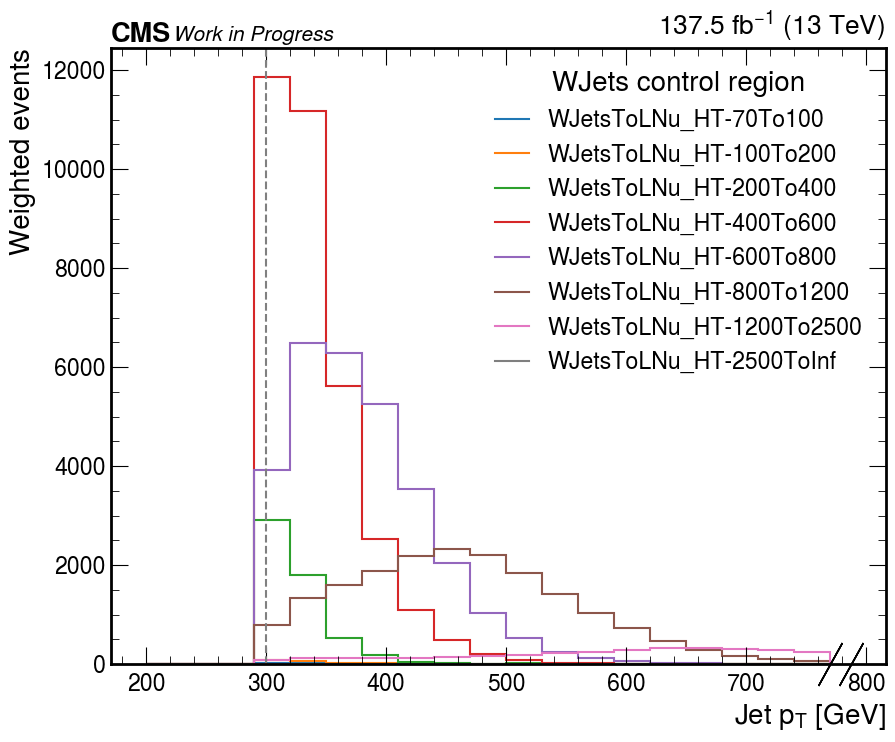

In [182]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/wjetscorr.pdf")     

# High qcd weights

In [1855]:
samples_to_plot = list(events_dictqcd["signal_region"]["2017"]["ele"].keys())
samples_to_plot

['QCD_Pt_3200toInf',
 'QCD_Pt_1800to2400',
 'QCD_Pt_2400to3200',
 'QCD_Pt_1000to1400',
 'QCD_Pt_600to800',
 'QCD_Pt_300to470',
 'QCD_Pt_170to300',
 'QCD_Pt_800to1000',
 'QCD_Pt_470to600',
 'QCD_Pt_1400to1800']

In [1856]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "Pre-selection": f"fj_pt>0",       

#     "High purity signal region": f"({tagger}>0.97)",
#     "High purity signal region + MET>X": f"({tagger}>0.97)",
    
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
#     "Medium purity signal region + MET>X": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
#     "WJets control region + MET>X": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
}

channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

# fill histograms
hists = {}

# var = "rec_higgs_m"
var = "fj_pt"
# var = "event_weight"
if var=="rec_higgs_m":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(50, 240, 20)), name="var", label=r"Higgs reconstructed mass [GeV]", overflow=True)
    )  
elif var == "fj_pt":
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(200, 800, 30)), name="var", label=r"Jet $p_T$ [GeV]", overflow=True)
    )      
else:
    h = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        hist2.axis.Variable(list(range(0, 500, 20)), name="var", label=r"Event weight", overflow=True)
    )      

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            region, sel = list(presel.items())[0]

            df = events_dictqcd["signal_region"][year][ch][sample]
            df = df.query(sel)

            if "MET>X" in region:
                if ch=="ele":
                    df = df[df["met_pt"]>70]
                else:
                    df = df[df["met_pt"]>50]

            x = df[var]
            if len(x)==0:
                x = 0   
                
            if var=="event_weight":
                h.fill(
                    samples=sample, var=x,
                )

            else:
                h.fill(
                    samples=sample, var=x, weight=df["event_weight"],
                )

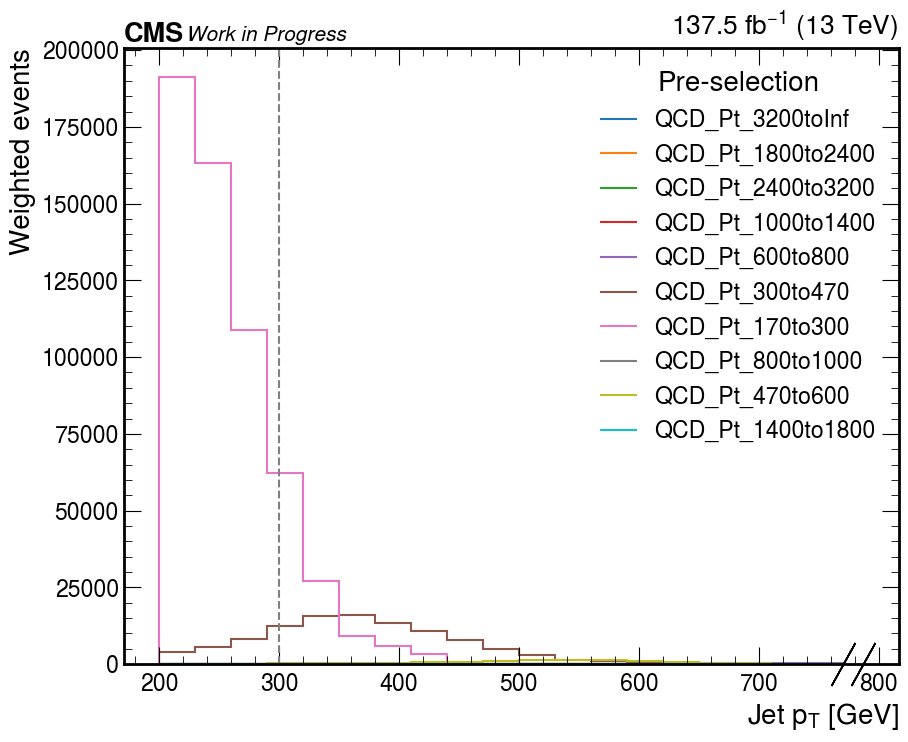

In [1857]:
fig, ax = plt.subplots(figsize=(10, 8))
for sample in samples_to_plot:
    hep.histplot(h[{"samples": sample}].project("var"),
        label=sample,
#         density=True,
#         yerr=False,
    )
ax.axvline(300, linestyle="--", color="grey")
ax.legend(title=region, loc="upper right")
ax.set_ylabel("Weighted events")
# ax.set_ylim(0.01, 10e4)
# ax.set_ylim(0, 2500)
# ax.set_yscale("log")

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/qcd_high_weights_wjets_jetpt.pdf")     

# soverb

In [149]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]

In [150]:
samples

['ggF',
 'VH',
 'VBF',
 'ttH',
 'QCD',
 'DYJets',
 'WJetsLNu',
 'WZQQ',
 'TTbar',
 'SingleTop',
 'Diboson',
 'Data']

In [333]:
# tagger = "ParT_finetuned"
tagger = "fj_ParT_score_finetuned"

presel = {
#     "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)", 
    "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20)", 

#     "WJets control region + dR>0.2": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0) & (lep_fj_dr>0.2)",    

#     "Top control region": f"({tagger}<0.2) & (n_bjets_T>0)",  
#     "Top control region + dR>0.1": f"({tagger}<0.20) & (n_bjets_T>0) & (lep_fj_dr>0.1)",      

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
#     "Lep iso": f"fj_pt>0",
}

categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) | (deta<3.5) ) & (fj_pt<300)",    
#     "ggF_pt300toinf": "( (mjj<1000) | (deta<3.5) ) & (fj_pt>300)",
    
}

mass_window = [80, 160]

years = ["2018", "2017", "2016APV", "2016"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "DYJets": 0,
    "Others": 0,
}

deno_sig, deno_bkg = 0, 0
s, b = 0, 0

for year in years:
    for ch in channels:
        for sample in samples:
            if sample=="Data":
                continue

            for k, v in presel.items():
                if "QCD" in k:
                    df = events_dict["qcd_region"][year][ch][sample]
                else:
                    df = events_dict["signal_region"][year][ch][sample]

                df = df.query(v)  
                
#                 if "High" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<140]
#                 if "Medium" in k:
#                     if sample == "QCD":
#                         df = df[df["event_weight"]<200]
            
#             for category, category_sel in categories_sel.items():
#                 df = df.query(category_sel)            
            
#             if sample == "QCD":
#                 df = df[df["event_weight"]<50]
                
#             if ch=="ele":
#                 df = df[df["met_pt"]>70]
#             else:
#                 df = df[df["met_pt"]>50]
                
#             df = df[df["n_bjets_L"]==0]
#             df = df[df["lep_fj_dr"]>0.2]
            df = df[df["lep_met_mt"]>40]
    
#             df = df[(df["fj_pt"]/df["lep_pt"])<3]

#             df = df[np.abs(df["met_fj_dphi"])<2.5]

#             df = df[df["fj_ParT_mass"]<50]

#             df = df[df["fj_pt"]>250]
            ######################## composition start
            if sample in utils.signals:
                
                deno_sig += df["event_weight"].sum()
                num_sig[sample] += df["event_weight"].sum()
            else:
                deno_bkg += df["event_weight"].sum()
                
                if sample in dominant_backgrounds:
                    num_bkg[sample] += df["event_weight"].sum()
                else:
                    num_bkg["Others"] += df["event_weight"].sum()     
            ######################## composition end
            
            ######################## soverb start
            df = df[(df["rec_higgs_m"]>=mass_window[0]) & (df["rec_higgs_m"]<=mass_window[1])]
    
            if sample in utils.signals:                
                s += df["event_weight"].sum()
            else:
                b += df["event_weight"].sum()
            ######################## soverb end

In [334]:
num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

if len(years) == 4:
    lab = "Run2"
else:
    lab = "_".join(years)

print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')
# print("Category:", category)

print("------------------------")

if "purity" in list(presel.keys())[0]:
    print("\033[1m" + rf"s/sqrt(b) in [{mass_window[0]},{mass_window[1]}]: {s/math.sqrt(b):.2f}" + '\033[0m')
    print("------------------------")

print(f"Signal: {deno_sig:.2f}")
for sample in num_sig:
    print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")
    
print("------------------------")
print(f"Background: {deno_bkg:.2f}")
for sample in num_bkg:
    if sample=="":
        print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
    else:
        print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%") 

WJets control region (Run2):
------------------------
Signal: 475.17
- ttH: 16%
- VH: 17%
- VBF: 20%
- ggF: 47%
------------------------
Background: 497404.16
- Others: 2%
- QCD: 5%
- DYJets: 15%
- TTbar: 18%
- WJetsLNu: 59%


In [587]:
(0.74**2 + 0.81**2 + 0.59**2)**0.5   # VBF / ggF200-300 / ggF300-450 / ggF450-inf

1.2457126474432216

# WJetsLNu region

In [455]:
tagger = "fj_ParT_score_finetuned_v2_nor2"

# mass_window = [50, 200]

years = ["2018", "2017"]
# years = ["2017"]
channels = ["ele", "mu"]

num_sig = {
    "ggF": 0, 
    "ttH": 0, 
    "VH": 0,
    "VBF": 0,
}
num_bkg = {
    "WJetsLNu": 0, 
    "TTbar": 0, 
    "QCD": 0,
    "Others": 0,
}
deno_sig, deno_bkg = 0, 0

# tagger_cuts = [0.01, 0.02, 0.03, 0.04, 0.07, 0.09, 0.1, 0.2, 0.8]
# tagger_cuts = np.linspace(0.01, 0.8, 21)
tagger_cuts = np.linspace(0.01, 0.3, 21)
ttt = []
for tagger_cut in tagger_cuts:
    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                df = events_dict[year][ch][sample]

    #             df = df[(df["rec_higgs_m"]>mass_window[0]) & (df["rec_higgs_m"]<mass_window[1])]

                df = df[df["event_weight"]<140]
                df = df[df[tagger]<0.85]
                df = df[df[tagger]>tagger_cut]
                df = df[df["n_bjets_L"]==0]                


                if sample in utils.signals:
                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()
                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()
                        
    ttt.append(100*(num_bkg["WJetsLNu"]/deno_bkg))  

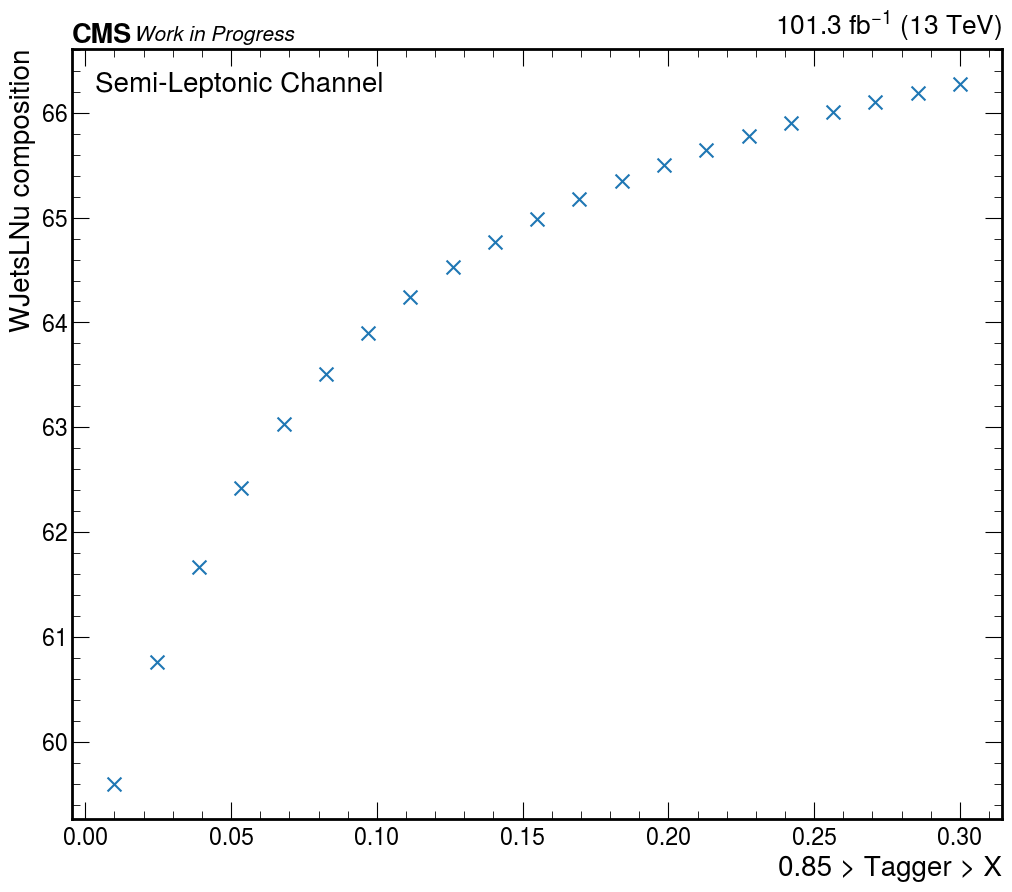

In [456]:
years = ["2018", "2017"]
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tagger_cuts, ttt, marker="x", s=100)

# ax.axvline(0.85, color="grey", linestyle="--")#, label=rf"125 GeV")

# ax.set_ylim(0, 1.4)
ax.legend(title=f"Semi-Leptonic Channel")
ax.set_ylabel(r"WJetsLNu composition");
ax.set_xlabel(r"0.85 > Tagger > X")
# ax.set_xlabel(rf"{wp} > Tagger > X")
# ax.set_xticks(tagger_cuts)
# ax.set_xticks([0.9, 0.92, 0.94, 0.96, 0.97, 0.98])

lum_ = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/soverb_W_region4.pdf")  

# Sculpting

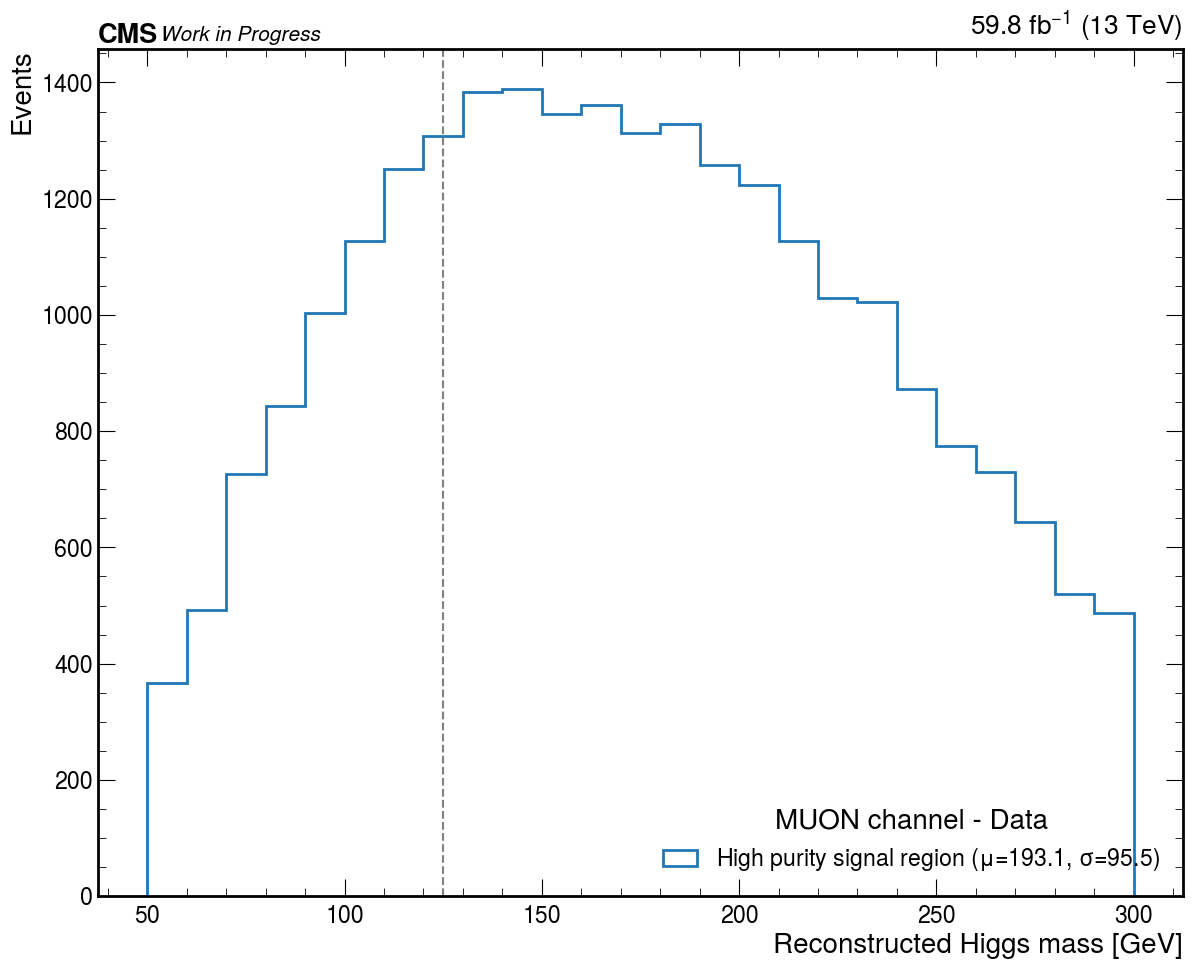

In [531]:
plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score_finetuned_v2_10_12"
tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
#     "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  

#     "Top control region + dR>0.1": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.1)",
#     "Top control region + dR>0.2": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.2)",
#     "Top control region + dR>0.3": f"({tagger}<0.3) & (n_bjets_T>0) & (lep_fj_dr>0.3)",
#     "Top control region + dR>0.4": f"({tagger}<0.9) & (n_bjets_T>0) & (lep_fj_dr>0.4)",
    
#     "WJets control region": f"({tagger}<0.80) & ({tagger}>0.20) & (n_bjets_L==0)",

#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
    
#     "ParT-finetuned>0.97": f"(fj_ParT_score_finetuned_v2_nor2>0.97)",
#     "ParT>0.99": f"(fj_ParT_score>0.99)"
    
    
}

nice_ch = {
    "ele": "ELECTRON",
    "mu": "MUON",
}

sample = "Data"
channels = ["mu"]#, "ele"]
years = ["2018"]#, "2017"]

fig, ax = plt.subplots(figsize=(14, 11))
for k, v in presel.items():
    
    for year in years:

        if "QCD" in k:
            region="qcd_region"
        else:
            region="signal_region"

        df1 = events_dict[region][year]["mu"][sample]    
        df2 = events_dict[region][year]["ele"][sample]

        df = pd.concat([df1, df2])

        if len(years) > 1:
            df1 = events_dict[region][years[1]]["mu"][sample]    
            df2 = events_dict[region][years[1]]["ele"][sample]

            df11 = pd.concat([df1, df2])

            df = pd.concat([df, df11])
            break
            
    bins = 26

    df1 = df.copy().query(v)

    x = df1["rec_higgs_m"]
#     w = df1["event_weight"]

    ax.hist(
        x, 
        bins=np.linspace(50,300,bins), 
#         weights=w,
#         density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--")#, label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

In [514]:
all_files = glob.glob("ttt/*")
log_files = glob.glob("ttt/log*")

In [505]:
all_files

['ttt/t', 'ttt/log.txt', 'ttt/a.txt']

In [506]:
log_files

['ttt/log.txt']

# Data

In [620]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [626]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
    "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [200, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>200) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [300, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>300)",
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
# channels = ["mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1 (tagger>0.97 + nbjetsT==0)": 10,
#     "SR2 (0.97>tagger>0.85 + nbjetsT==0)": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


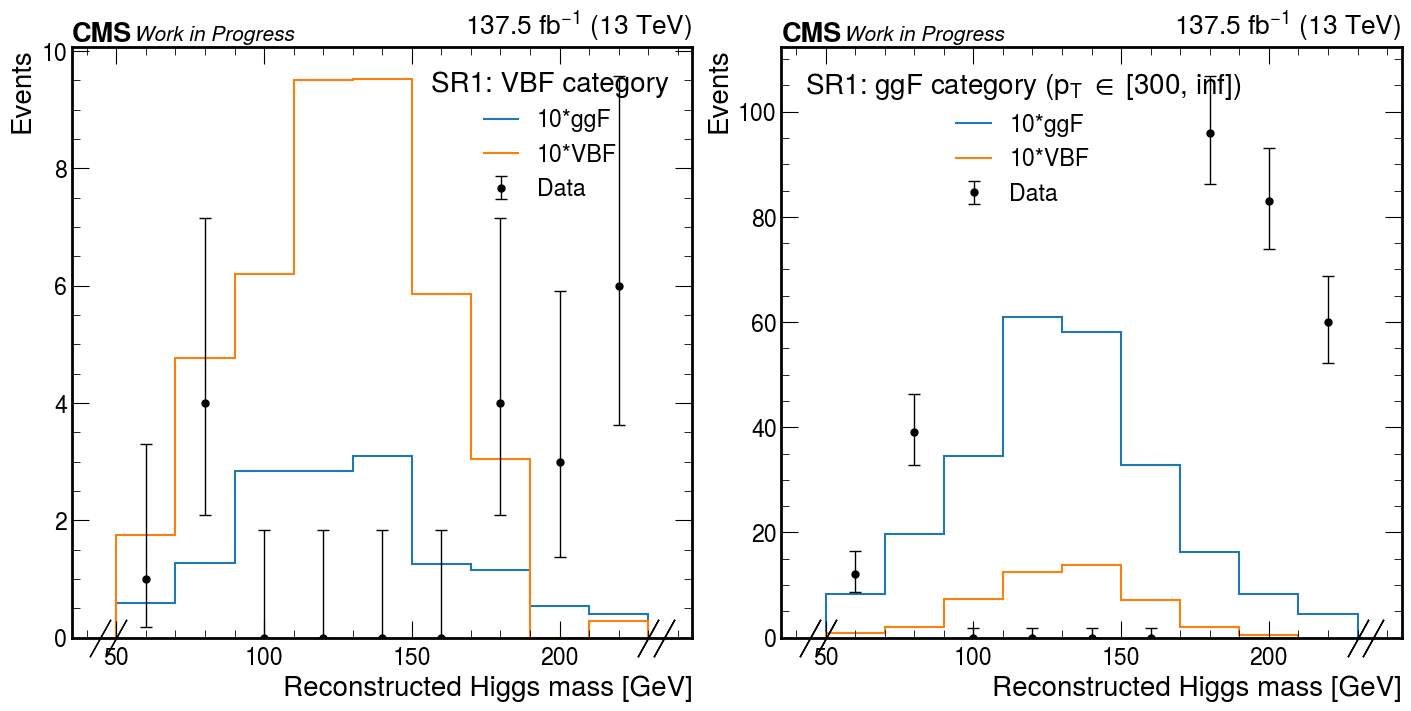

In [627]:
fig, axs = plt.subplots(1, 2, figsize=(14,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
                

    axs[i].legend(title=f"SR1: {category}")
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/ww3.pdf")

In [628]:
################### option 2
def blindBins(h, blind_region, blind_samples=[]):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_samples`` specified, only blind those samples, else blinds all.

    CAREFUL: assumes axis=0 is samples, axis=3 is mass_axis

    """

    h = h.copy()

    massbins = h.axes["mass_observable"].edges

    lv = int(np.searchsorted(massbins, blind_region[0], "right"))
    rv = int(np.searchsorted(massbins, blind_region[1], "left") + 1)

    if blind_samples:
        for blind_sample in blind_samples:
            sample_index = np.argmax(np.array(list(h.axes[0])) == blind_sample)
            h.view(flow=True)[sample_index, :, :, lv:rv] = 0

    else:
        h.view(flow=True)[:, :, :, lv:rv] = 0

    return h

plt.rcParams.update({"font.size": 20})

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

regions_sel = {
#     "Pre-selection": f"{tagger}>0.5",    
    "SR1 (tagger>0.97 + nbjetsT==0)": f"({tagger}>0.97) & (n_bjets_T==0)",
    "SR2 (0.97>tagger>0.85 + nbjetsT==0)": f"({tagger}<0.97) & ({tagger}>0.85) & (n_bjets_T==0)",
#     "WJets CR (0.85>tagger>0.50 + nbjetsT==0)": f"({tagger}<0.85) & ({tagger}>0.50) & (n_bjets_T==0)",    
#     "Top CR (tagger>0.85 + nbjetsT>0)": f"({tagger}>0.85) & (n_bjets_T>0)", 
    
}

categories_sel = {
#     "VBF category": "(mjj>1000) & (deta>3.5)",
#     rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
#     rf"ggF category ($p_T$ $\in$ [450, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>450)",
    
    rf"ggF category ($p_T$ $\in$ [300, 450])": "(mjj<1000) & (deta<3.5) & (fj_pt>300) & (fj_pt<450)",
    rf"ggF category ($p_T$ $\in$ [450, 650])": "(mjj<1000) & (deta<3.5) & (fj_pt>450) & (fj_pt<650)",
    rf"ggF category ($p_T$ $\in$ [650, inf])": "(mjj<1000) & (deta<3.5) & (fj_pt>650)",        
}

samples = ["Data", "ggF", "VBF"]
channels = ["ele", "mu"]
blind = True
blind_region = (90, 160)

years = ["2018", "2017", "2016", "2016APV"]
lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0
    

# fill histograms
hists = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),            
    hist2.axis.StrCategory([], name="regions", growth=True),
    hist2.axis.StrCategory([], name="categories", growth=True),    
    hist2.axis.Variable(
        list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
    ),
)        

mult = {
    "SR1 (tagger>0.97 + nbjetsT==0)": 10,
    "SR2 (0.97>tagger>0.85 + nbjetsT==0)": 100,
}

for sample in samples:
    for year in years:
        for ch in channels:
            df = ev[year][ch][sample]
            for region, region_sel in regions_sel.items():
                for category, category_sel in categories_sel.items():
                    df1 = df.copy().query(region_sel)
                    df1 = df1.query(category_sel)

                    if ((sample=="ggF") or (sample=="VBF")):
                        df1["event_weight"]=df1["event_weight"]*mult[region]

                    hists.fill(
                        samples=sample,
                        regions=region,
                        categories=category,
                        mass_observable=df1["rec_higgs_m"],
                        weight=df1["event_weight"],
                    )

INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral
INFO:matplotlib.mathtext:Substituting symbol \in from STIXGeneral


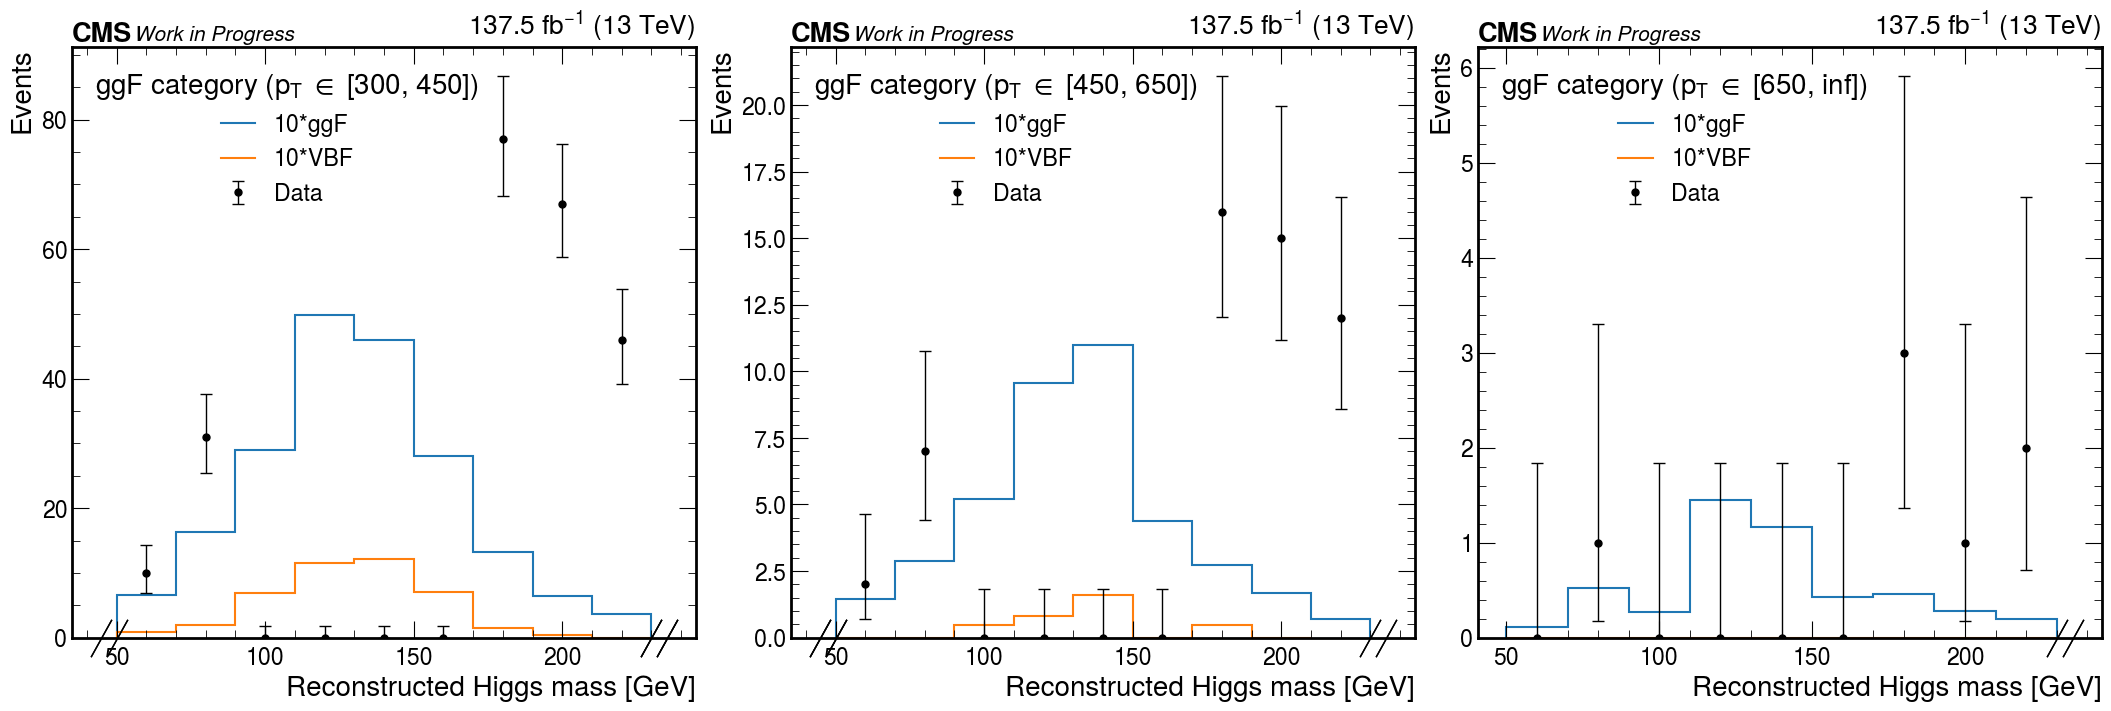

In [629]:
fig, axs = plt.subplots(1, 3, figsize=(21,7), constrained_layout=True)

region = list(regions_sel.items())[0][0]
for i, category in enumerate(categories_sel):
    for sample in samples:
        
        
        if sample == "Data":
            if blind:
                hists = blindBins(hists, (blind_region[0],blind_region[1]), blind_samples=["Data"])
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   
            
        else:
            if mult[region]==1:
                lab = sample            
            else:
                lab = f"{mult[region]}*{sample}"
            
            hep.histplot(
                hists[{"samples": sample, "regions": region, "categories": category}],
                ax=axs[i],
                histtype="step",
                label=lab,
            )    
            
    axs[i].legend(title=category)
    axs[i].set_ylabel(f"Events")
    axs[i].set_xlabel(f"Reconstructed Higgs mass [GeV]")
    axs[i].set_ylim(0)    
    hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=axs[i], fontsize=20)
    hep.cms.text("Work in Progress", ax=axs[i], fontsize=15)
#     if i==2:
#         axs[i].set_yticks([0,4,8,12,16])
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku5/ww2.pdf")

In [631]:
for key in df.keys():
    print(key)

fj_msoftdrop
lep_pt
lep_isolation
lep_misolation
lep_fj_dr
lep_met_mt
met_fj_dphi
met_pt
deta
mjj
n_bjets_L
n_bjets_M
n_bjets_T
n_bjetsDeepCSV_L
n_bjetsDeepCSV_M
n_bjetsDeepCSV_T
fj_lsf3
fj_minus_lep_m
fj_pt
rec_higgs_m
fj_genH_pt
fj_genH_jet
fj_genV_dR
fj_genVstar
genV_genVstar_dR
fj_nquarks
fj_ncquarks
fj_lepinprongs
fj_H_VV_4q
fj_H_VV_elenuqq
fj_H_VV_munuqq
fj_H_VV_taunuqq
fj_H_VV_isVlepton
fj_H_VV_isVstarlepton
fj_H_VV_isMatched
gen_Vlep_pt
fj_genRes_mass
fj_genjetmass
fj_genjetpt
weight_mu
weight_ele
fj_ParT_score
fj_ParT_mass
abs_met_fj_dphi
event_weight
met_relpt
fj_ParT_score_finetuned_v2-1111-10noMass1
fj_ParT_score_finetuned_v2_1-12
fj_ParT_score_finetuned


# QCD

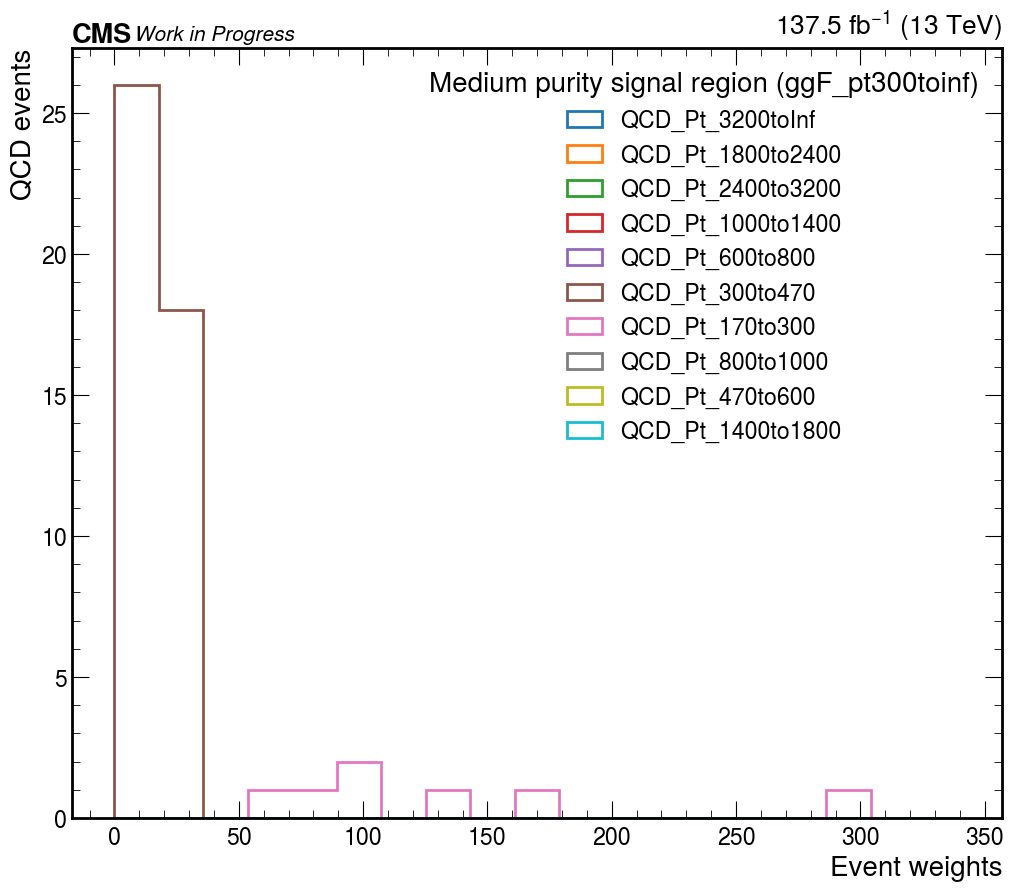

In [573]:
################### option 1
plt.rcParams.update({"font.size": 20})
nice_ch = {
    "ele": "Electron",
    "mu": "Muon",
}

# tagger = "fj_ParT_score"
tagger = "fj_ParT_score_finetuned"

region_sel = {
#     "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",    
#     "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",   
    
#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",
#     "Top control region": f"({tagger}<0.30) & (n_bjets_T>0)",  
#     "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  
}
categories_sel = {
#     "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
#     "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
blind = True
blind_region = (80, 160)
mult = 10

years = ["2018", "2017", "2016APV", "2016"]
sample="QCD"

fig, ax = plt.subplots(figsize=(12,10))    

ws = {}

for sample in events_dict2["signal_region"]["2017"][ch]:
    ws[sample] = []
    for year in years:
        for ch in ["ele", "mu"]:
            try:
                df = events_dict2["signal_region"][year][ch][sample]
            except:
                continue

            for region, sel in region_sel.items():
                df = df.query(sel)

            for category, category_sel in categories_sel.items():
                df = df.query(category_sel)

            w = df[f"event_weight"]
            ws[sample] += w.tolist() 
    
    ws[sample] = np.array(ws[sample])
    ws[sample] = ws[sample][ws[sample]>10]

    bins = 20
    ax.hist(
        ws[sample],
        bins=np.linspace(0,340,bins), 
        histtype="step", 
        linewidth=2, 
        label=sample
    )
#     break

lum = 0
for year in years:
    lum += luminosity[ch][year] / 1000.0

ax.legend(title=f"{region} ({category})", loc="upper right")

ax.set_ylabel(f"QCD events")
ax.set_xlabel(f"Event weights")  
ax.set_ylim(0)

hep.cms.lumitext("%.1f " % lum + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku2/WWW_QCD_weights_medium_{category}.pdf")        

In [740]:
def plot_ratio(h, years, region1 = "Medium_signal_region", region2 = "QCD_region", sample="QCD", category="VBF", tag=""):
    
    fig, (ax, rax) = plt.subplots(
        nrows=2,
        ncols=1,
        figsize=(10, 10),
        gridspec_kw={"height_ratios": (4, 2), "hspace": 0.07},
        sharex=True,
    )

    hep.histplot(
        h[{"region": region1, "categories": category}],
        ax=ax,
#         histtype="step",
        histtype="errorbar",        
        label=region1,
        density=True
    )
    hep.histplot(
        h[{"region": region2, "categories": category}],
        ax=ax,
        histtype="step",
        label=region2,
        density=True    
    )

    from hist.intervals import ratio_uncertainty

    data_val = h[{"region": region1, "categories": category}].values()
    tot_val = h[{"region": region2, "categories": category}].values()
    yerr = ratio_uncertainty(data_val, tot_val, "poisson")
    

    data_val /= data_val.sum()
    tot_val /= tot_val.sum()


    hep.histplot(
        data_val / tot_val,
        h[{"region": region1, "categories": category}].axes.edges[0],
        yerr=yerr,
        ax=rax,
        histtype="step",
        color="k",
#         capsize=4,
    )
    ax.set_xlabel("")
    rax.set_xlabel(f"{h.axes[-1].label}")  # assumes the variable to be plotted is at the last axis

    rax.set_ylabel("Ratio", fontsize=20, loc="center")

    
#     rax.set_ylim(0, 0.004)
#     rax.set_yticks([0, 0.4, 1, 1.4])
    
    rax.axhline(1, ls="--", color="k")    
#     rax.set_ylim(0, 2.5)
#     rax.set_yticks([0, 0.4, 1, 1.4])

    ax.legend(title=category)
    
    lum_ = 0
    for year in years:
        lum = 0
        for ch in ["ele", "mu"]:
            with open("../fileset/luminosity.json") as f:
                lum += json.load(f)[ch][year] / 1000.0

        lum_ += lum / len(channels)

    hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)

    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    
    
    ax.set_ylabel(f"Normalized {sample} events")
    
    if tag:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}_{tag}.pdf")        
    else:
        plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku3/ratio_{sample}.pdf")   

In [741]:
tagger = "fj_ParT_score_finetuned"
presel = {
    "High purity signal region": f"({tagger}>0.97)",
    "Medium purity signal region": f"({tagger}<0.97) & ({tagger}>0.85)",
    "Low purity signal region": f"({tagger}<0.85) & ({tagger}>0.20)",
    "0.85>Tagger>0.20": f"({tagger}<0.85) & ({tagger}>0.20)",

#     "WJets control region": f"({tagger}<0.85) & ({tagger}>0.20) & (n_bjets_L==0)",   
    
#     "Top control region": f"({tagger}<0.20) & (n_bjets_T>0)",  
    "QCD control region": f"({tagger}<0.20) & (n_bjets_T==0)",  

}

categories_sel = {
    "VBF_pt200toinf": "( (mjj>1000) & (deta>3.5) )",
    "ggF_pt200to300": "( (mjj<1000) & (deta<3.5) & (fj_pt<300) )",
    "ggF_pt300toinf": "( (mjj<1000) & (deta<3.5) & (fj_pt>300) )",
    
}
            
channels = ["ele", "mu"]
years = ["2018", "2017", "2016", "2016APV"]

sample = "QCD"

# fill histograms
hists = {}
for var in vars_to_plot:
            
    if var == "rec_higgs_m":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            hist2.axis.StrCategory([], name="categories", growth=True),            
            hist2.axis.Variable(
                list(range(50, 240, 20)), name="mass_observable", label=r"Higgs reconstructed mass [GeV]", overflow=True
            )
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="region", growth=True),
            utils.axis_dict[var],
        )
        
    for year in years:
        for ch in channels:
                
            for region, region_sel in presel.items():
                for category, category_sel in categories_sel.items():
                
                    if "QCD control region" in region:
                        df = events_dict["qcd_region"][year][ch][sample]
                    else:
                        df = events_dict["signal_region"][year][ch][sample]

                    if "High" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<140]
                    elif "Medium" in region:
                        if sample == "QCD":
                            df = df[df["event_weight"]<200]

                    df = df.query(region_sel)
                    df = df.query(category_sel)

                    hists[var].fill(
                        region=region,
                        categories=category,
                        mass_observable=df[var],
                        weight=df["event_weight"],
                    )     

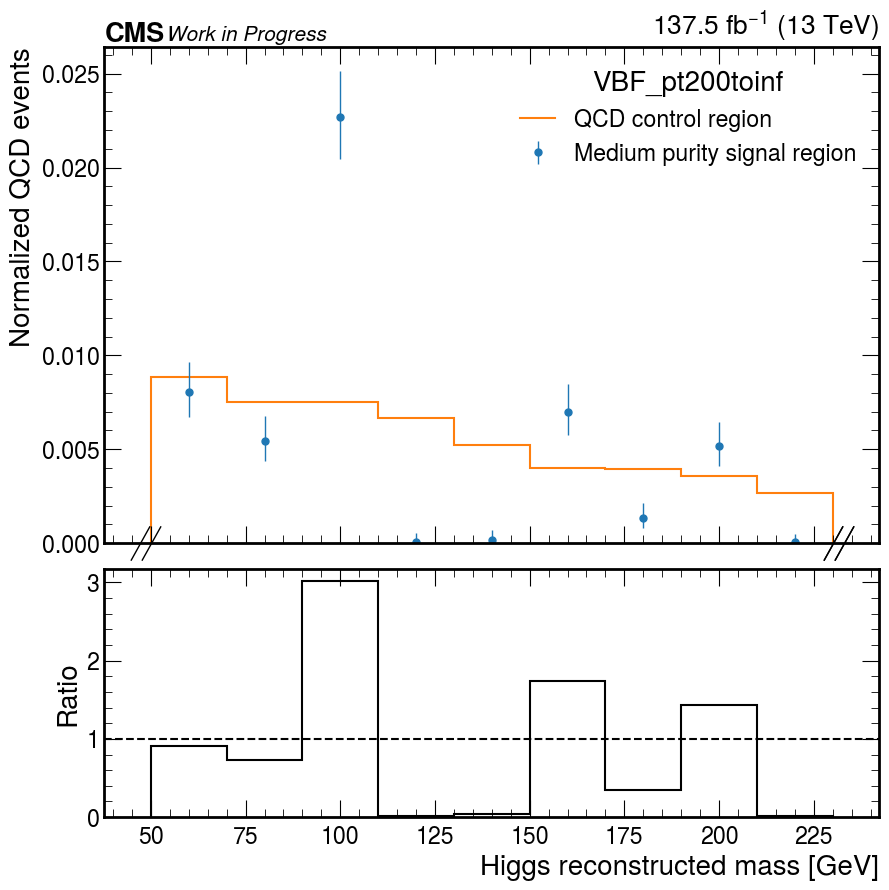

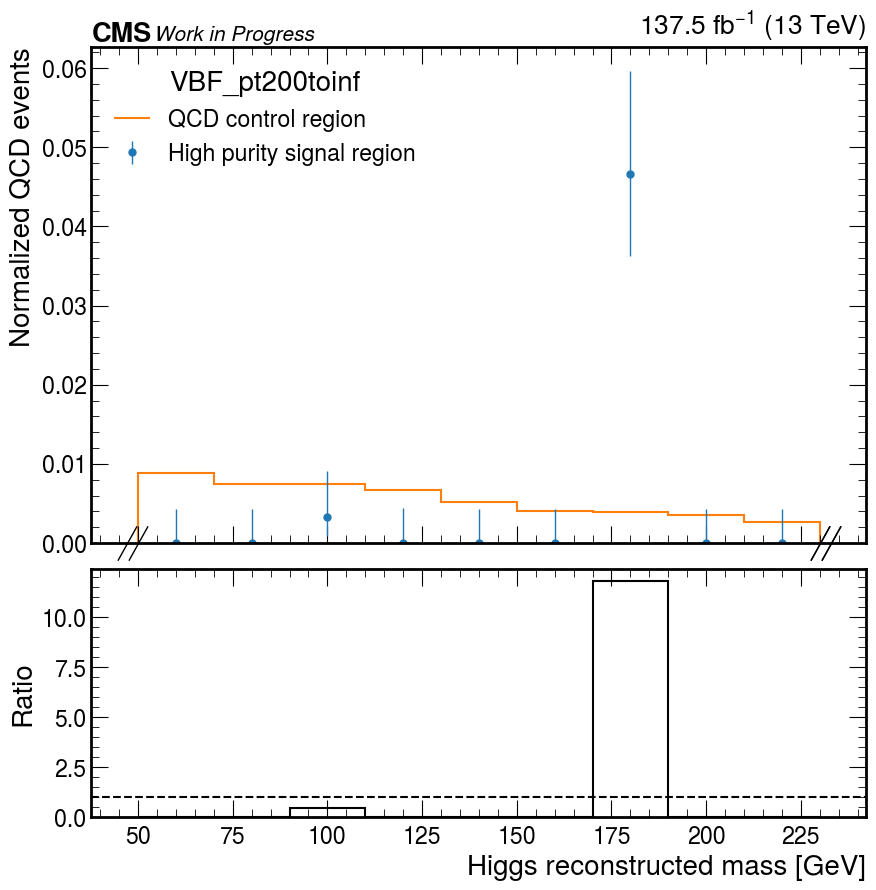

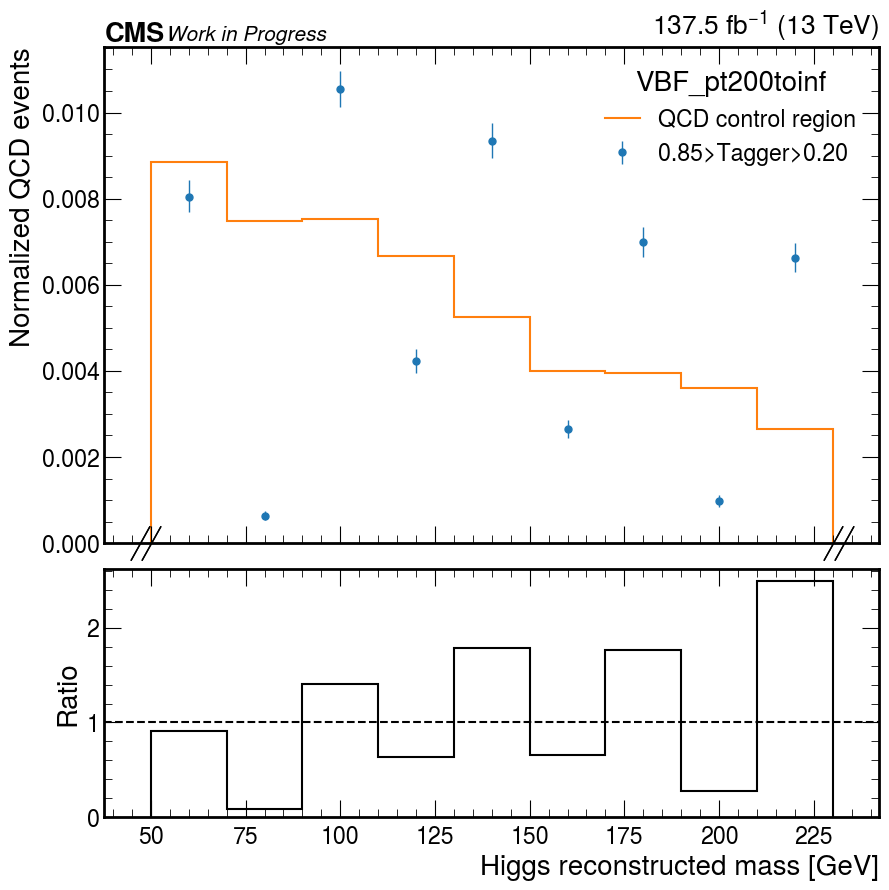

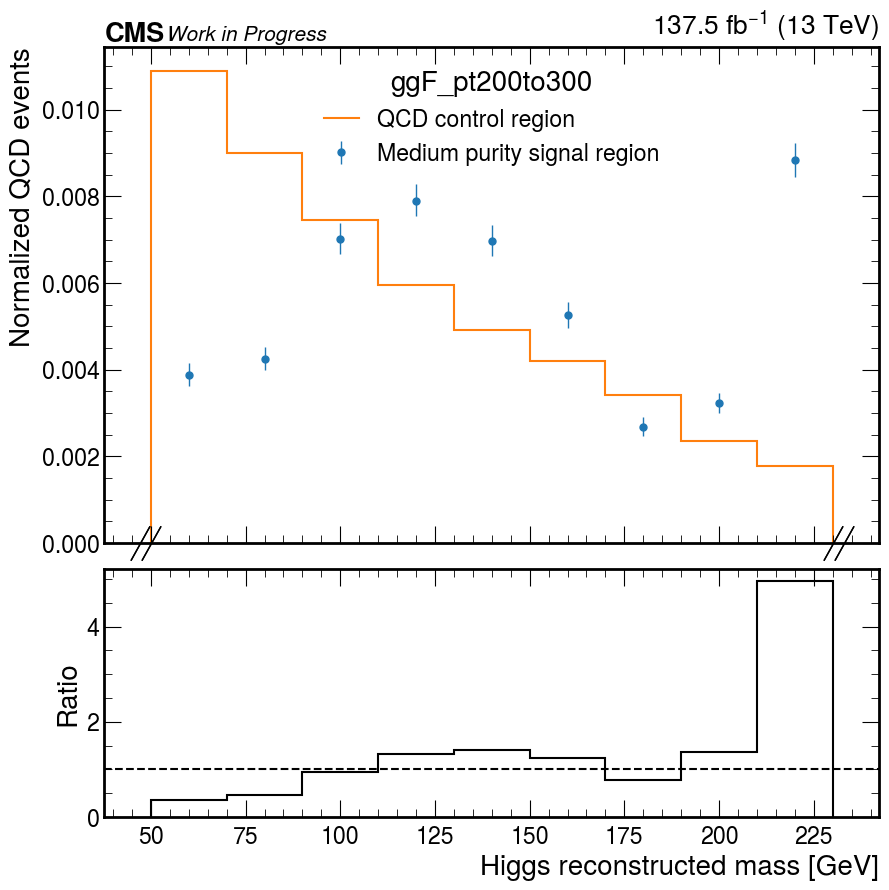

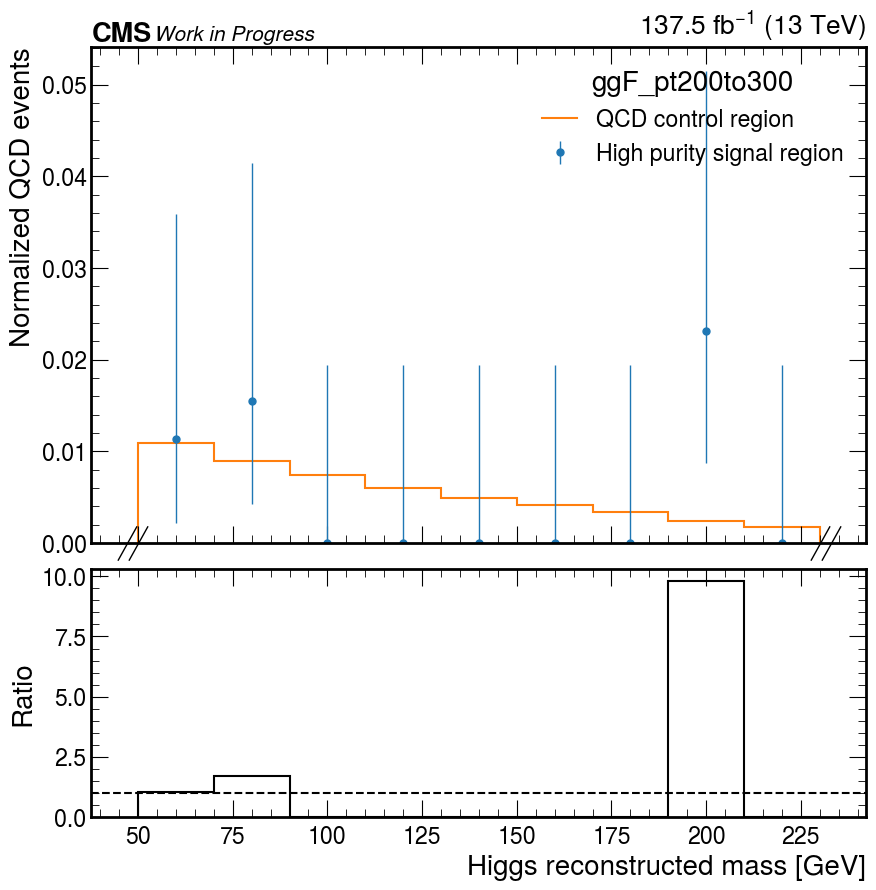

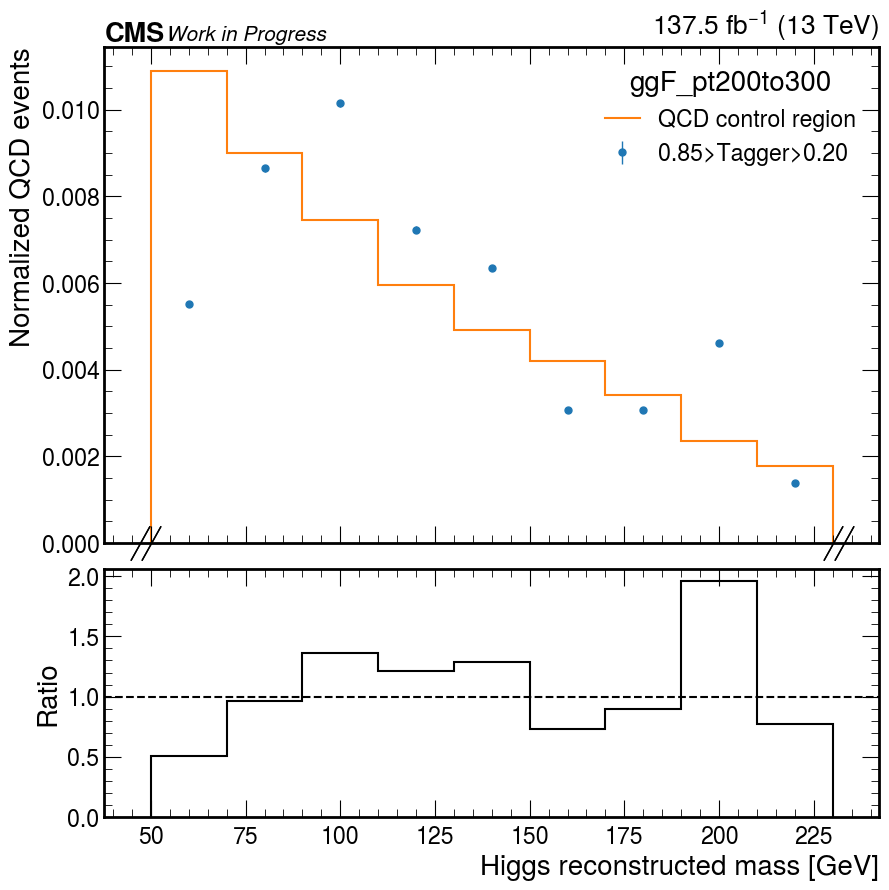

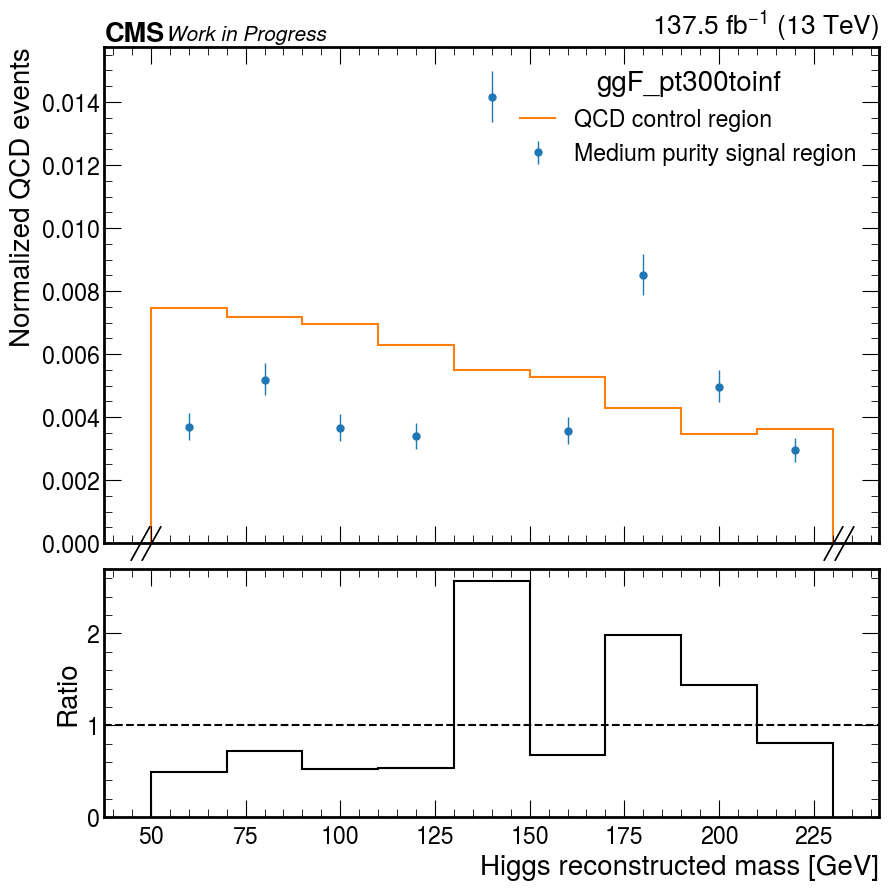

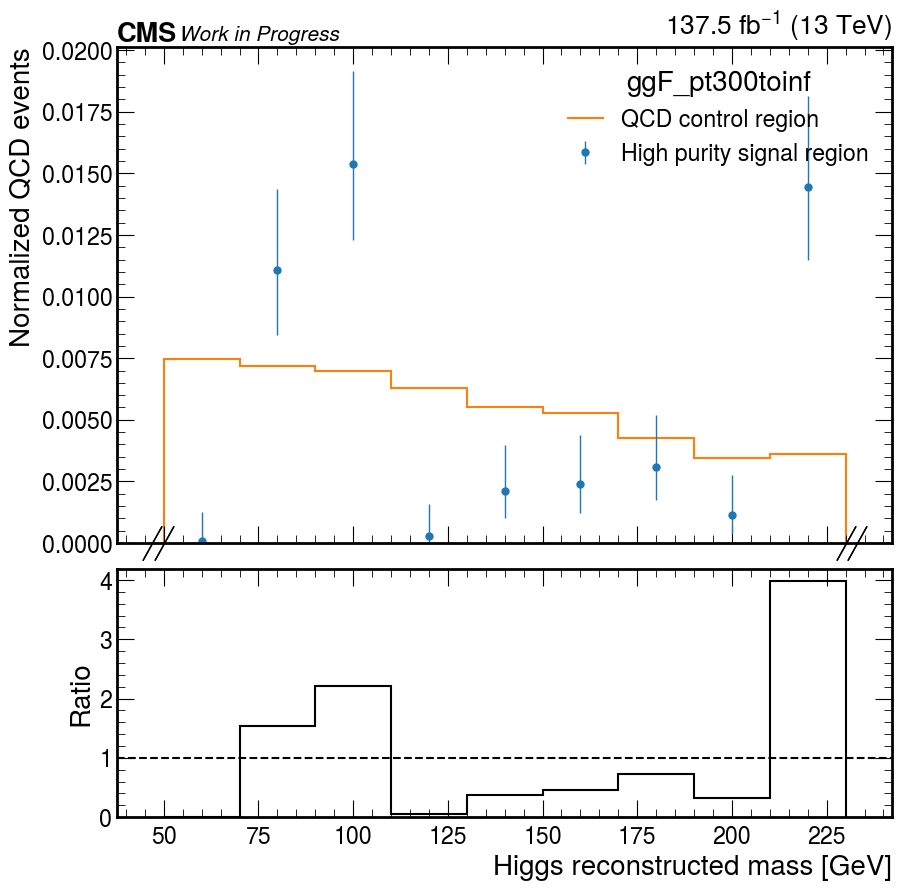

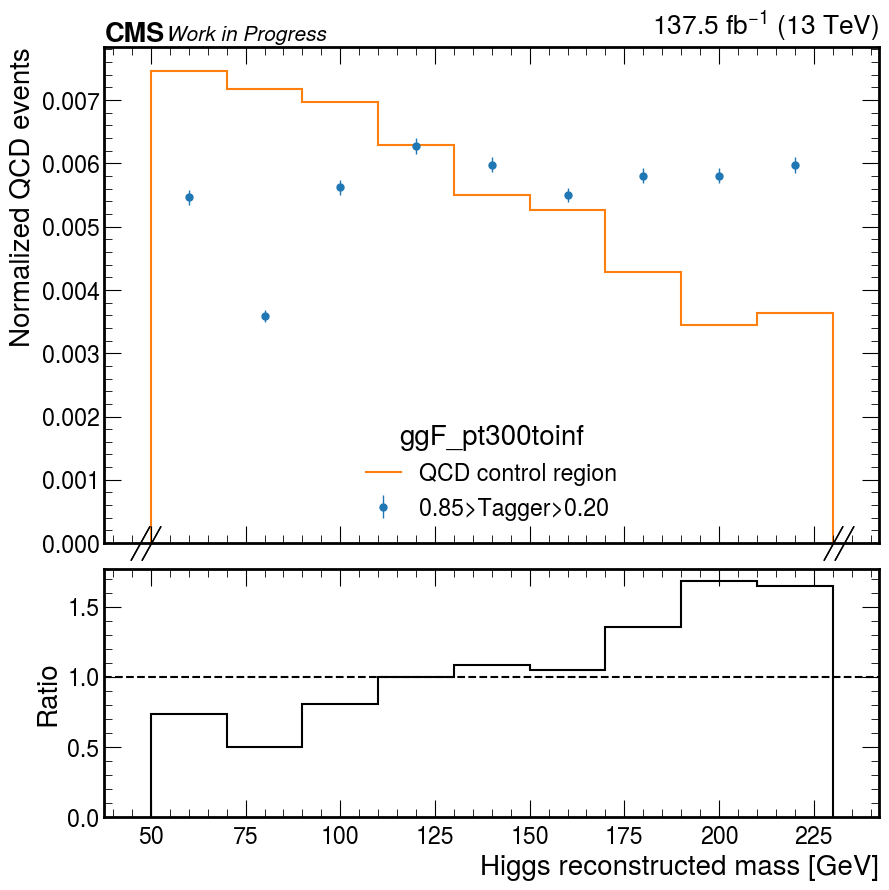

In [754]:
region_dic = {
    "Medium purity signal region": "medium",
    "High purity signal region": "high",
    "0.85>Tagger>0.20": "low",    
}

for category in ["VBF_pt200toinf", "ggF_pt200to300", "ggF_pt300toinf"]:
    
    for region in region_dic:
        plot_ratio(hists["rec_higgs_m"], 
                   years, 
                   region1 = region,
                   region2 = "QCD control region",
                   sample=sample,
                   category=category,
                   tag=f"{category}_{region_dic[region]}"
                  )

In [ ]:
fig, ax = plt.subplots(figsize=(14, 11))
ax.hist(
    x, 
    bins=np.linspace(50,300,bins), 
    weights=w,
    density=True, 
    histtype="step", 
    linewidth=2, 
    label=rf"{k} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
)

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0)

lum_=0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    lum_ += lum / len(channels)

hep.cms.lumitext("%.1f " % lum_ + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakikopku/mass_sculpting_{sample}.pdf")        

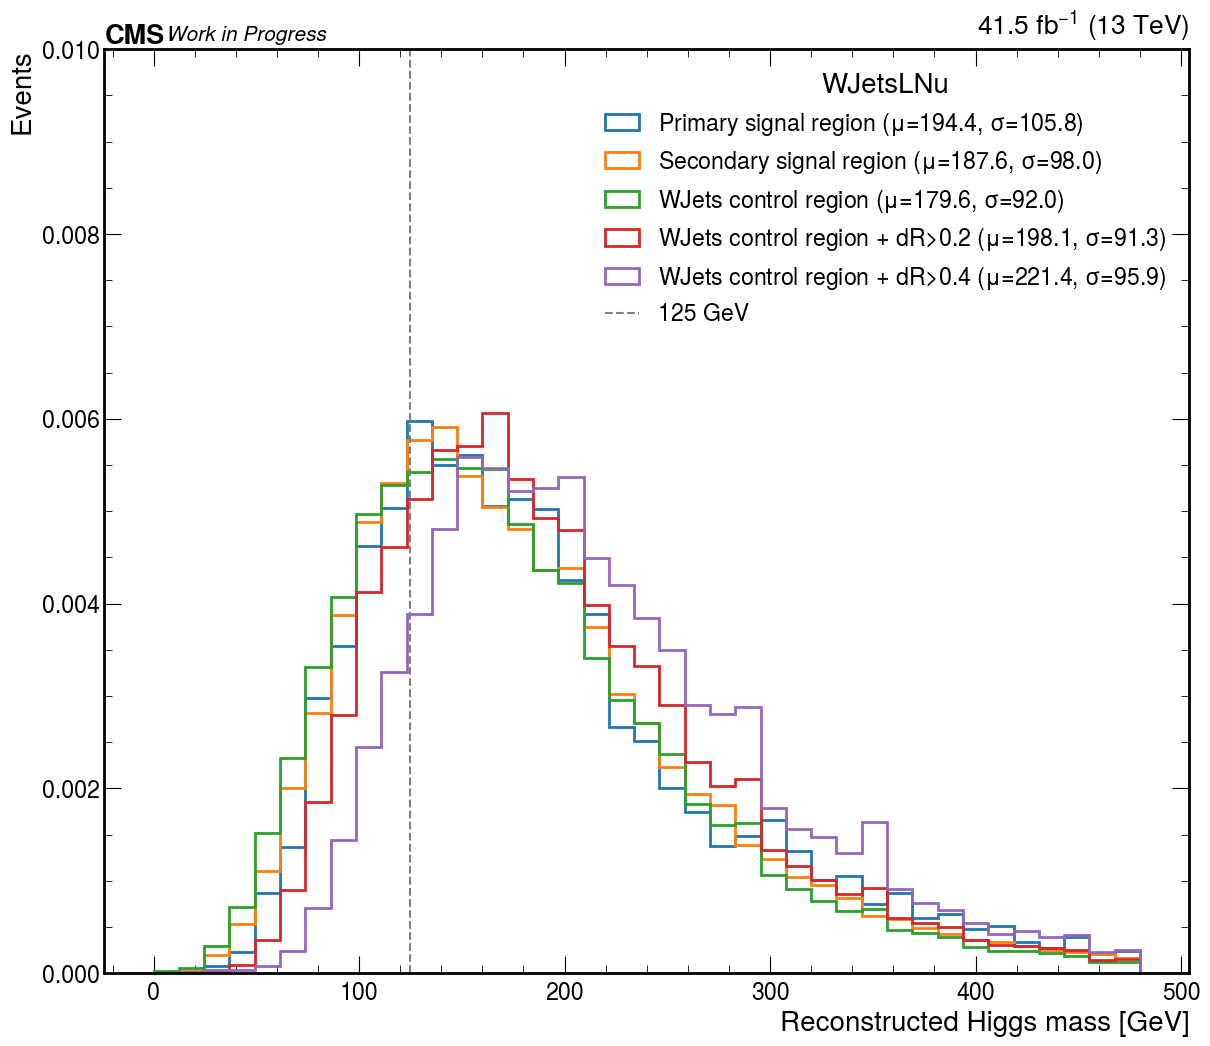

In [140]:
fig, ax = plt.subplots(figsize=(14, 12))
for region, sel in presel.items():

    df1 = df.copy().query(sel)

    x = df1["rec_higgs_m"]
    ax.hist(
        x, 
        bins=np.linspace(0,480,bins), 
        weights=df1["weight"],
        density=True, 
        histtype="step", 
        linewidth=2, 
        label=rf"{region} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
    )

ax.axvline(125, color="grey", linestyle="--", label=rf"125 GeV")

if len(channels) > 1:
    ax.legend(title=f"{sample}")    
else:
    ax.legend(title=f"{nice_ch[ch]} channel - {sample}")


ax.set_ylabel("Events")
ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
ax.set_ylim(0, 0.01)

luminosity = 0
for year in years:
    lum = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum += json.load(f)[ch][year] / 1000.0

    luminosity += lum / len(channels)    
        
hep.cms.lumitext("%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
plt.savefig(f"/Users/fmokhtar/Desktop/farakiko/{sample}.pdf")  

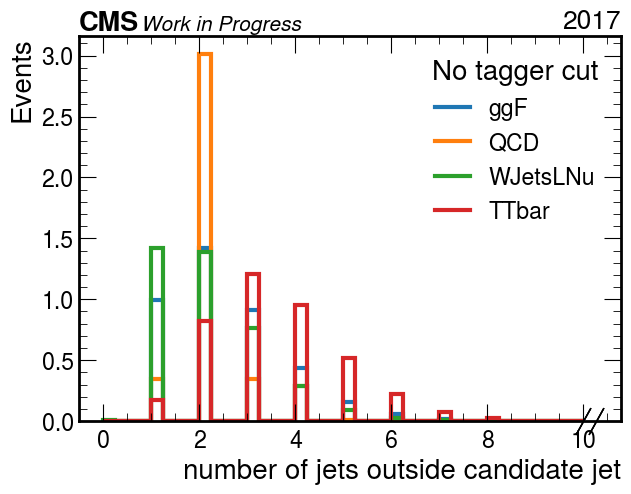

In [20]:
samples_to_plot = [
    "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
     "QCD",
#     "DYJets",
    "WJetsLNu",
    "TTbar",
]

### Example of a 1-d histogram
# make simple 1d-histogram of `lep_pt`
plt.rcParams.update({"font.size": 20})

var = "nj"
# var = "met_fj_dphi"
# var = "lep_met_mt"
# var = "mjj"


h = hist2.Hist(
    hist2.axis.StrCategory([], name="samples", growth=True),
    utils.axis_dict[var],
)  
    
fig, ax = plt.subplots(figsize=(7, 5))

for sample in samples_to_plot:
    for year in years:
        for ch in channels:

            df = events_dict[year][ch][sample]

            # tagger cut
    #         df = df[df["inclusive_score"]>0.9]

    #         df = df[df["lep_fj_dr"]>0.03]        
            df = df[df["n_bjets_M"]<2]
    #         df = df[(df["rec_W_lnu_pt"]/df["rec_W_qq_pt"])<4.8]

            h.fill(
                samples=sample,
                var=df[var],
                weight=df["event_weight"]
            )

for sample in samples_to_plot:
    if sample in utils.sig_labels:
        lab = utils.sig_labels[sample]
    else:
        lab = sample
        
    hep.histplot(
        h[{"samples":sample}],
        ax=ax,
        label=lab,
        linewidth=3,
        density=True
    )

# ax.set_title("Without dR(Jet,Lepton)>0.03")
ax.legend(title=f"No tagger cut")
ax.set_ylabel("Events");  
hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15);

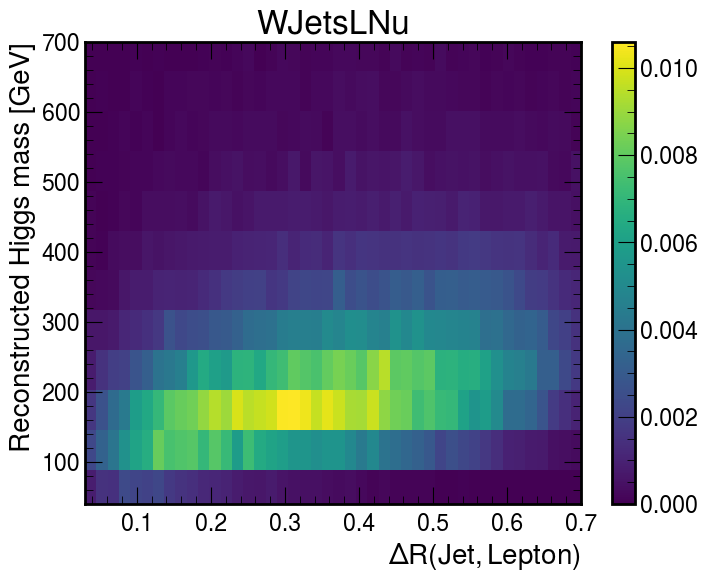

In [16]:
samples_to_plot = [
#     "HWW", 
#     "VH",
#     "VBF",
#     "ttH",
#      "QCD",
#     "DYJets",
    "WJetsLNu",
#     "TTbar",
]

var1 = "lep_fj_dr"
var2 = "rec_higgs_m"

from matplotlib.colors import LogNorm
fig, ax = plt.subplots(figsize=(8, 6))

for sample in samples_to_plot:
    for year in years:
        for i, ch in enumerate(channels):
            df = events_dict[year][ch][sample]

            df = df[df["inclusive_score"]>0.99]
            df = df[df["fj_pt"]>220]

            if i==0:
                dff = df
            else:
                dff = pd.concat([dff, df])


    x = dff[var1].dropna()
    y = dff[var2].dropna()

    plt.hist2d(
        x,
        y,
        density=True,
#         norm=LogNorm(),
        bins=[50,50]
          )

ax.set_xlim(0.03,0.7)
ax.set_ylim(40, 700)
ax.set_xlabel(r"$\Delta R(Jet,Lepton)}$");
ax.set_ylabel(r"Reconstructed Higgs mass [GeV]");
ax.set_title(sample)
plt.colorbar()

### save plot
save_as = f"/Users/fmokhtar/Desktop/hww/{samples_dir[3:]}/"
plt.savefig(f"{save_as}/2d-{var1}-{var2}-{sample}.pdf", bbox_inches='tight')